## Installing/loading the required libraries
Set the variable `INSTALL` to `TRUE` to install the libraries, set to `FALSE` once this has been done.

In [52]:
required_libs = c("dplyr", "readr", "sqldf", "igraph", "ggraph", "raster")
for (l in required_libs) {
    if (!require(l, character.only = TRUE)) {
        install.library(l)
        library(l, character.only = TRUE)
    }
}

# Load the data
We load two data files: `air_travel_MB.csv` contains the network description and `airport_codes_CAN.csv`, which has some information about all airfields in Canada.

The data in air_travel_MB is pre-processed. It represents an extreme simplification of a much more complete dataset (Rows: 2,757,430; Columns: 19) giving, for a given time period, the total number of travellers between 3734 airports worldwide along trips including up to 5 intermediate stops. 

What I did is to keep only the airports in Manitoba. Any airport outside of Manitoba is set as `RoW` (rest of the world). Also, the existing multi-leg trips within Manitoba are "decomposed": if the data had 10 people flying, say, YWG$\to$YQD$\to$YTH (Winnipeg to The Pas to Thompson), these would appear as 10 people flying from YWG to YQD and 10 people flying from YQD to YTH. 

Flights to and from RoW are decomposed the same way as flights within Manitoba, increasing the number of trips between RoW and YWG. Indeed, 5 passengers flying RoW$\to$YWG$\to$YQD and 5 passengers flying RoW$\to$YWG$\to$YBR (Brandon) will show as 10 passengers flying RoW to YWG, together with 5 passengers flying YWG$\to$YQD and 5 passengers flying YWG$\to$YBR.

In [53]:
air_travel_MB <- read_delim("air_travel_MB.csv", 
                     delim = ",", escape_double = FALSE,
                               trim_ws = TRUE)
airport_codes_MB <- read_csv("airport_codes_CAN.csv") %>%
  filter(ISO_Region == "CA-MB")
head(air_travel_MB)
head(airport_codes_MB)

Rows: 108 Columns: 3
── Column specification ──────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): orig, dest
dbl (1): vol

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2792 Columns: 18
── Column specification ──────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Identifier, Type, Name, ISO_Country_Code, ISO_Region, Municipality...
dbl  (4): Airport_ID, Latitude, Longitude, Elevation_Ft
lgl  (2): Continent, Is_Scheduled_Service

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


orig dest vol   
1 RoW  YBR    2002
2 RoW  YTH      18
3 RoW  YWG  157323
4 RoW  YYQ    1474
5 XLB  RoW     766
6 XLB  XTL     114

Airport_ID Identifier Type   Name                            Latitude
1 35391      CA-0006    closed RCAF Station Carberry           49.87210
2 39668      CA-0022    closed Anama Bay-Dauphin River Airport 51.96267
3 39677      CA-0031    closed Austin Airport                  49.93333
4 39686      CA-0040    closed Beausejour Airport              50.13697
5 39694      CA-0048    closed Bethany Airport                 50.35000
6 39696      CA-0050    closed Bird Airport                    56.50000
  Longitude Elevation_Ft Continent ISO_Country_Code ISO_Region Municipality
1 -99.39730 NA           NA        CA               CA-MB      Carberry    
2 -98.13684 NA           NA        CA               CA-MB      NA          
3 -98.91666 NA           NA        CA               CA-MB      NA          
4 -96.20822 NA           NA        CA               CA-MB      Beausejour  
5 -99.75000 NA           NA        CA               CA-MB      NA          
6 -94.21667 NA           NA        CA               CA-MB      NA          
  Is_Scheduled_Service GPS_Code IATA_Code Local_Code Home_Link
1 FALSE                NA       NA        NA         NA       
2 FALSE                NA       NA        NA         NA       
3 FALSE                NA       NA        NA         NA       
4 FALSE                NA       NA        NA         NA       
5 FALSE                NA       NA        NA         NA       
6 FALSE                NA       NA        NA         NA       
  Wikipedia_Link                                      Keywords
1 https://en.wikipedia.org/wiki/RCAF_Station_Carberry NA      
2 NA                                                  NA      
3 NA                                                  NA      
4 NA                                                  NA      
5 NA                                                  NA      
6 NA                                                  NA

# Data wrangling remark
Note that there is an alternative to `dplyr` (the package that allows us to use the pipe `%>%`); it is indeed possible to treat data frames as SQL tables and run SQL queries on them. This may make more sense to some of you. For illustration, to create the table of movements, I used the following command (which can run, since it is not destructive of what we have already done).

In [54]:
query = 
"SELECT orig,dest,SUM(vol) AS vol
FROM air_travel_MB
GROUP BY orig,dest
ORDER BY orig,dest"

air_travel_MB = sqldf::sqldf(query)

Finish preparing the data: we want to record the latitude and longitudes for all the airports in the `air_travel_MB` data set. Note that we give `RoW` a location: we will show it as an additional vertex in the graph. (I picked somewhere close to but not in Manitoba.)

In [55]:
IATA_codes_MB_in_data = data.frame(IATA = sort(unique(union(air_travel_MB$orig,
                                                            air_travel_MB$dest))))
lon = c()
lat = c()
for (i in 1:dim(IATA_codes_MB_in_data)[1]) {
  idx = which(airport_codes_MB$IATA_Code == IATA_codes_MB_in_data$IATA[i])
  if (length(idx) == 0) {
    lon = c(lon, -90)
    lat = c(lat, 49.5)
  } else {
    lon = c(lon, airport_codes_MB$Longitude[idx])
    lat = c(lat, airport_codes_MB$Latitude[idx])
  }
}
IATA_codes_MB_in_data$lon = lon
IATA_codes_MB_in_data$lat = lat

head(IATA_codes_MB_in_data)

IATA lon       lat    
1 RoW   -90.0000 49.5000
2 XLB  -101.4690 58.6175
3 XSI   -98.9072 56.7928
4 XTL   -98.5122 58.7061
5 YBR   -99.9519 49.9100
6 YBT  -101.6790 57.8894

We are now in a position to make the graph and plot it in simple form. We add the volume as the weight of the arcs.

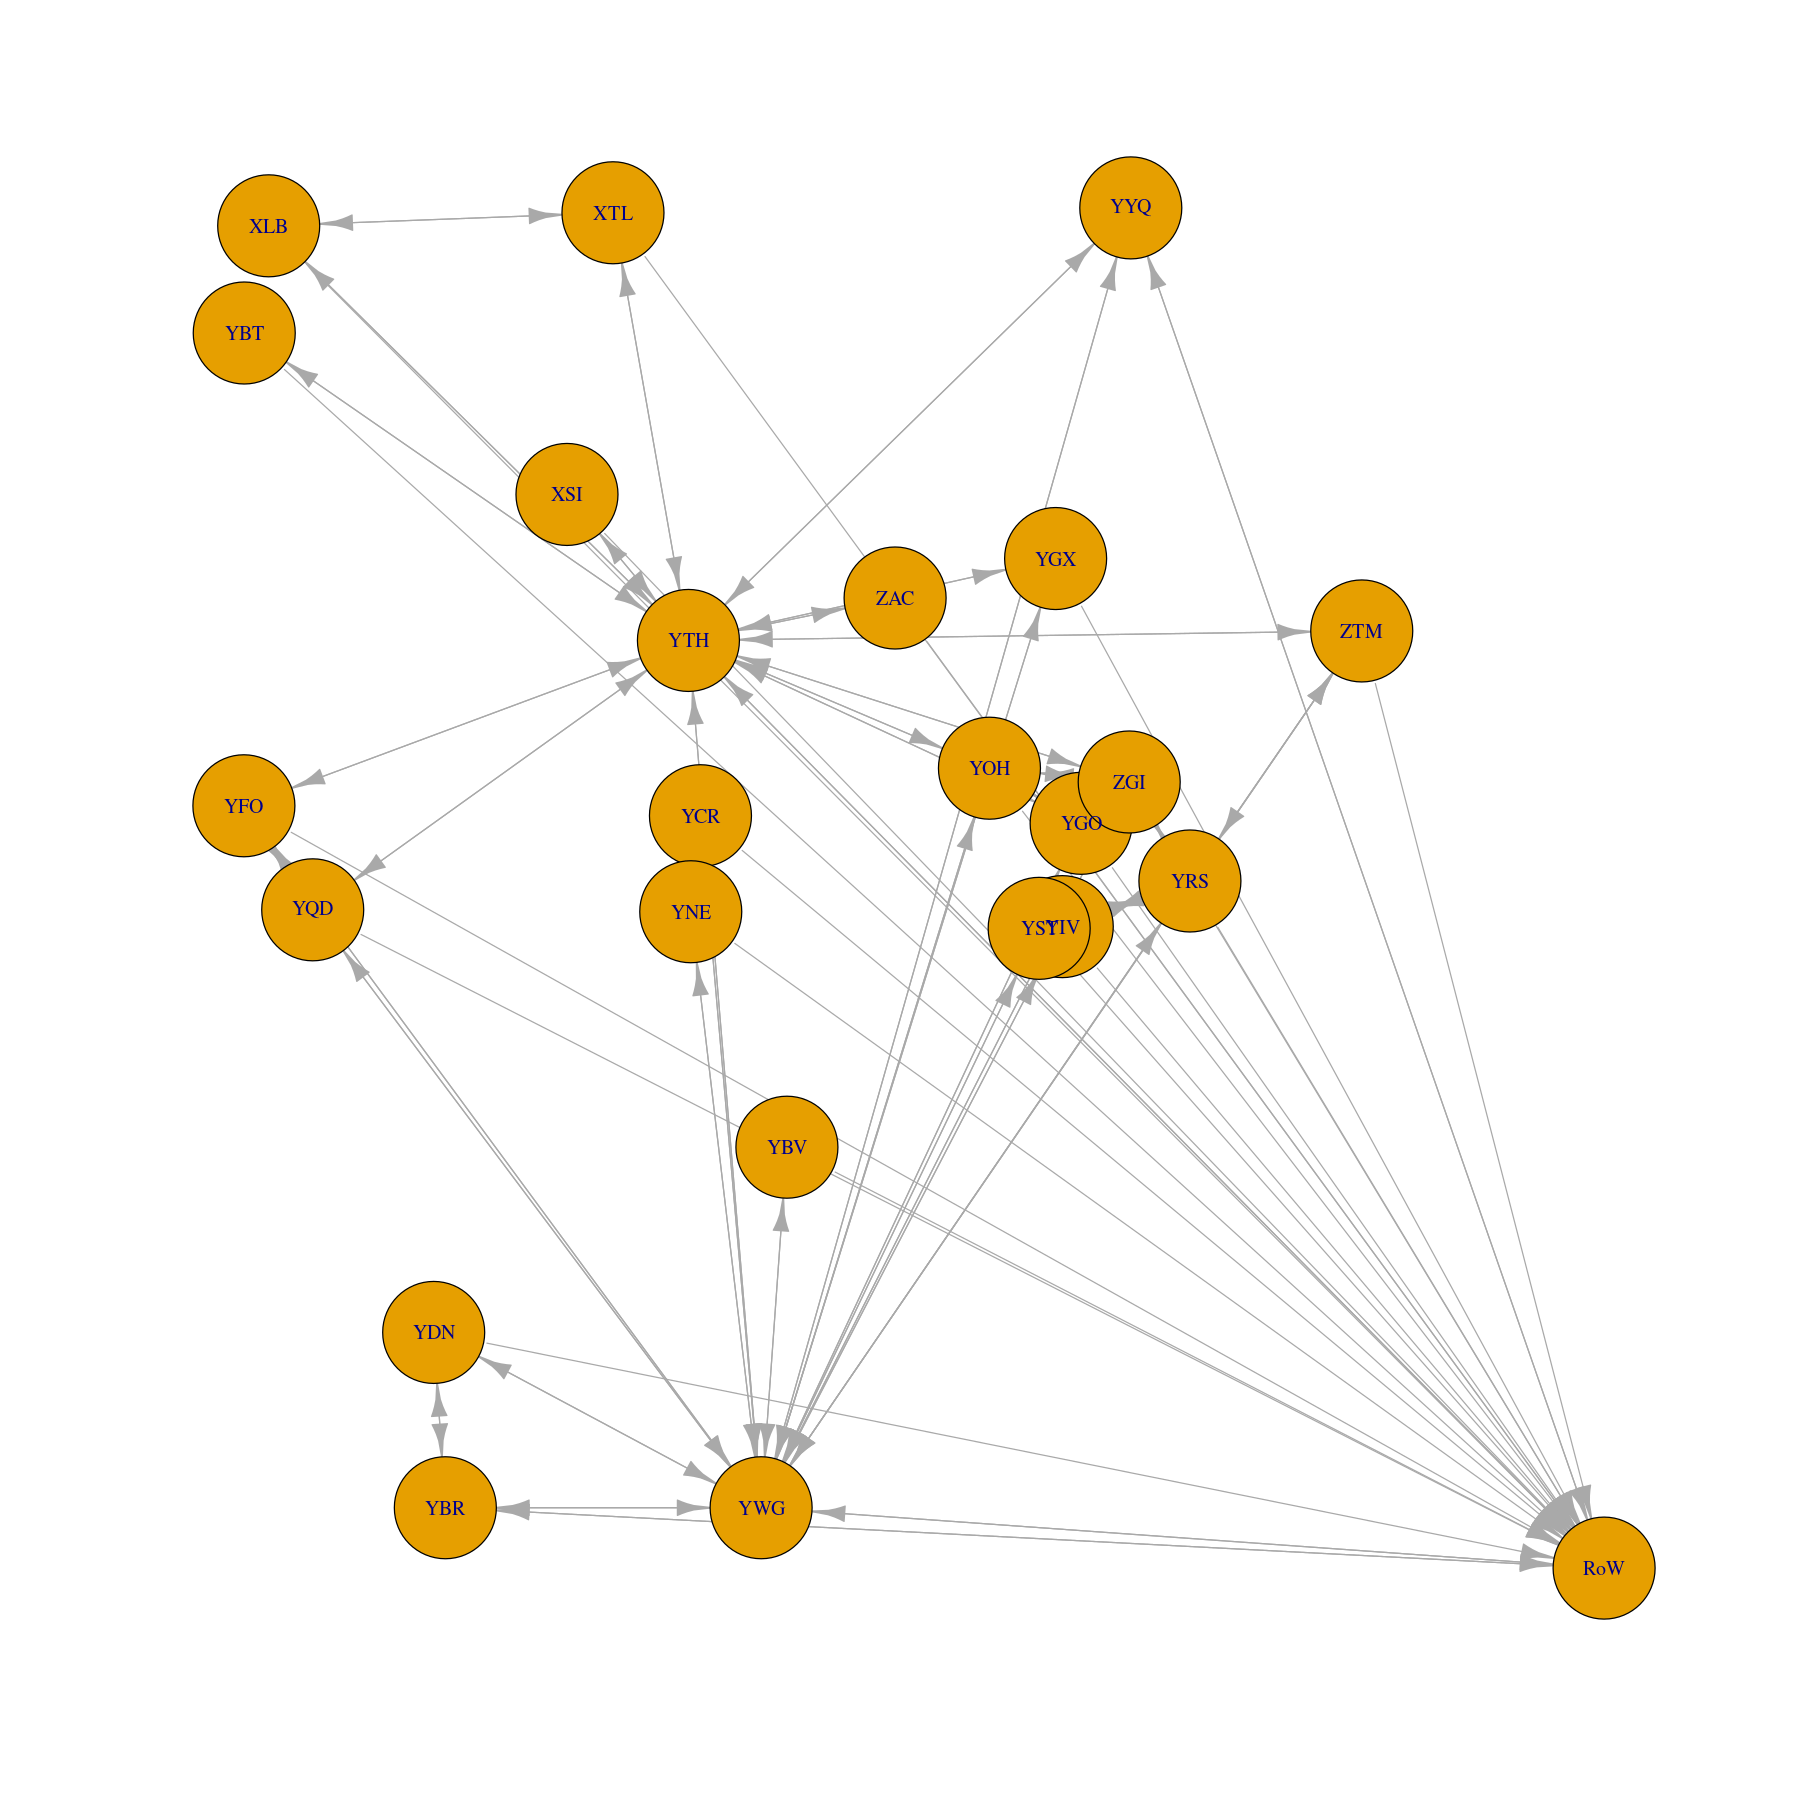

In [56]:
G = graph_from_data_frame(air_travel_MB)
V(G)$x = lon
V(G)$y = lat

plot(G, edge.arrow.size = 0.5, edge.arrow.width = 0.75)

We also make a subgraph without `RoW` to focus on the properties really specific to Manitoba.

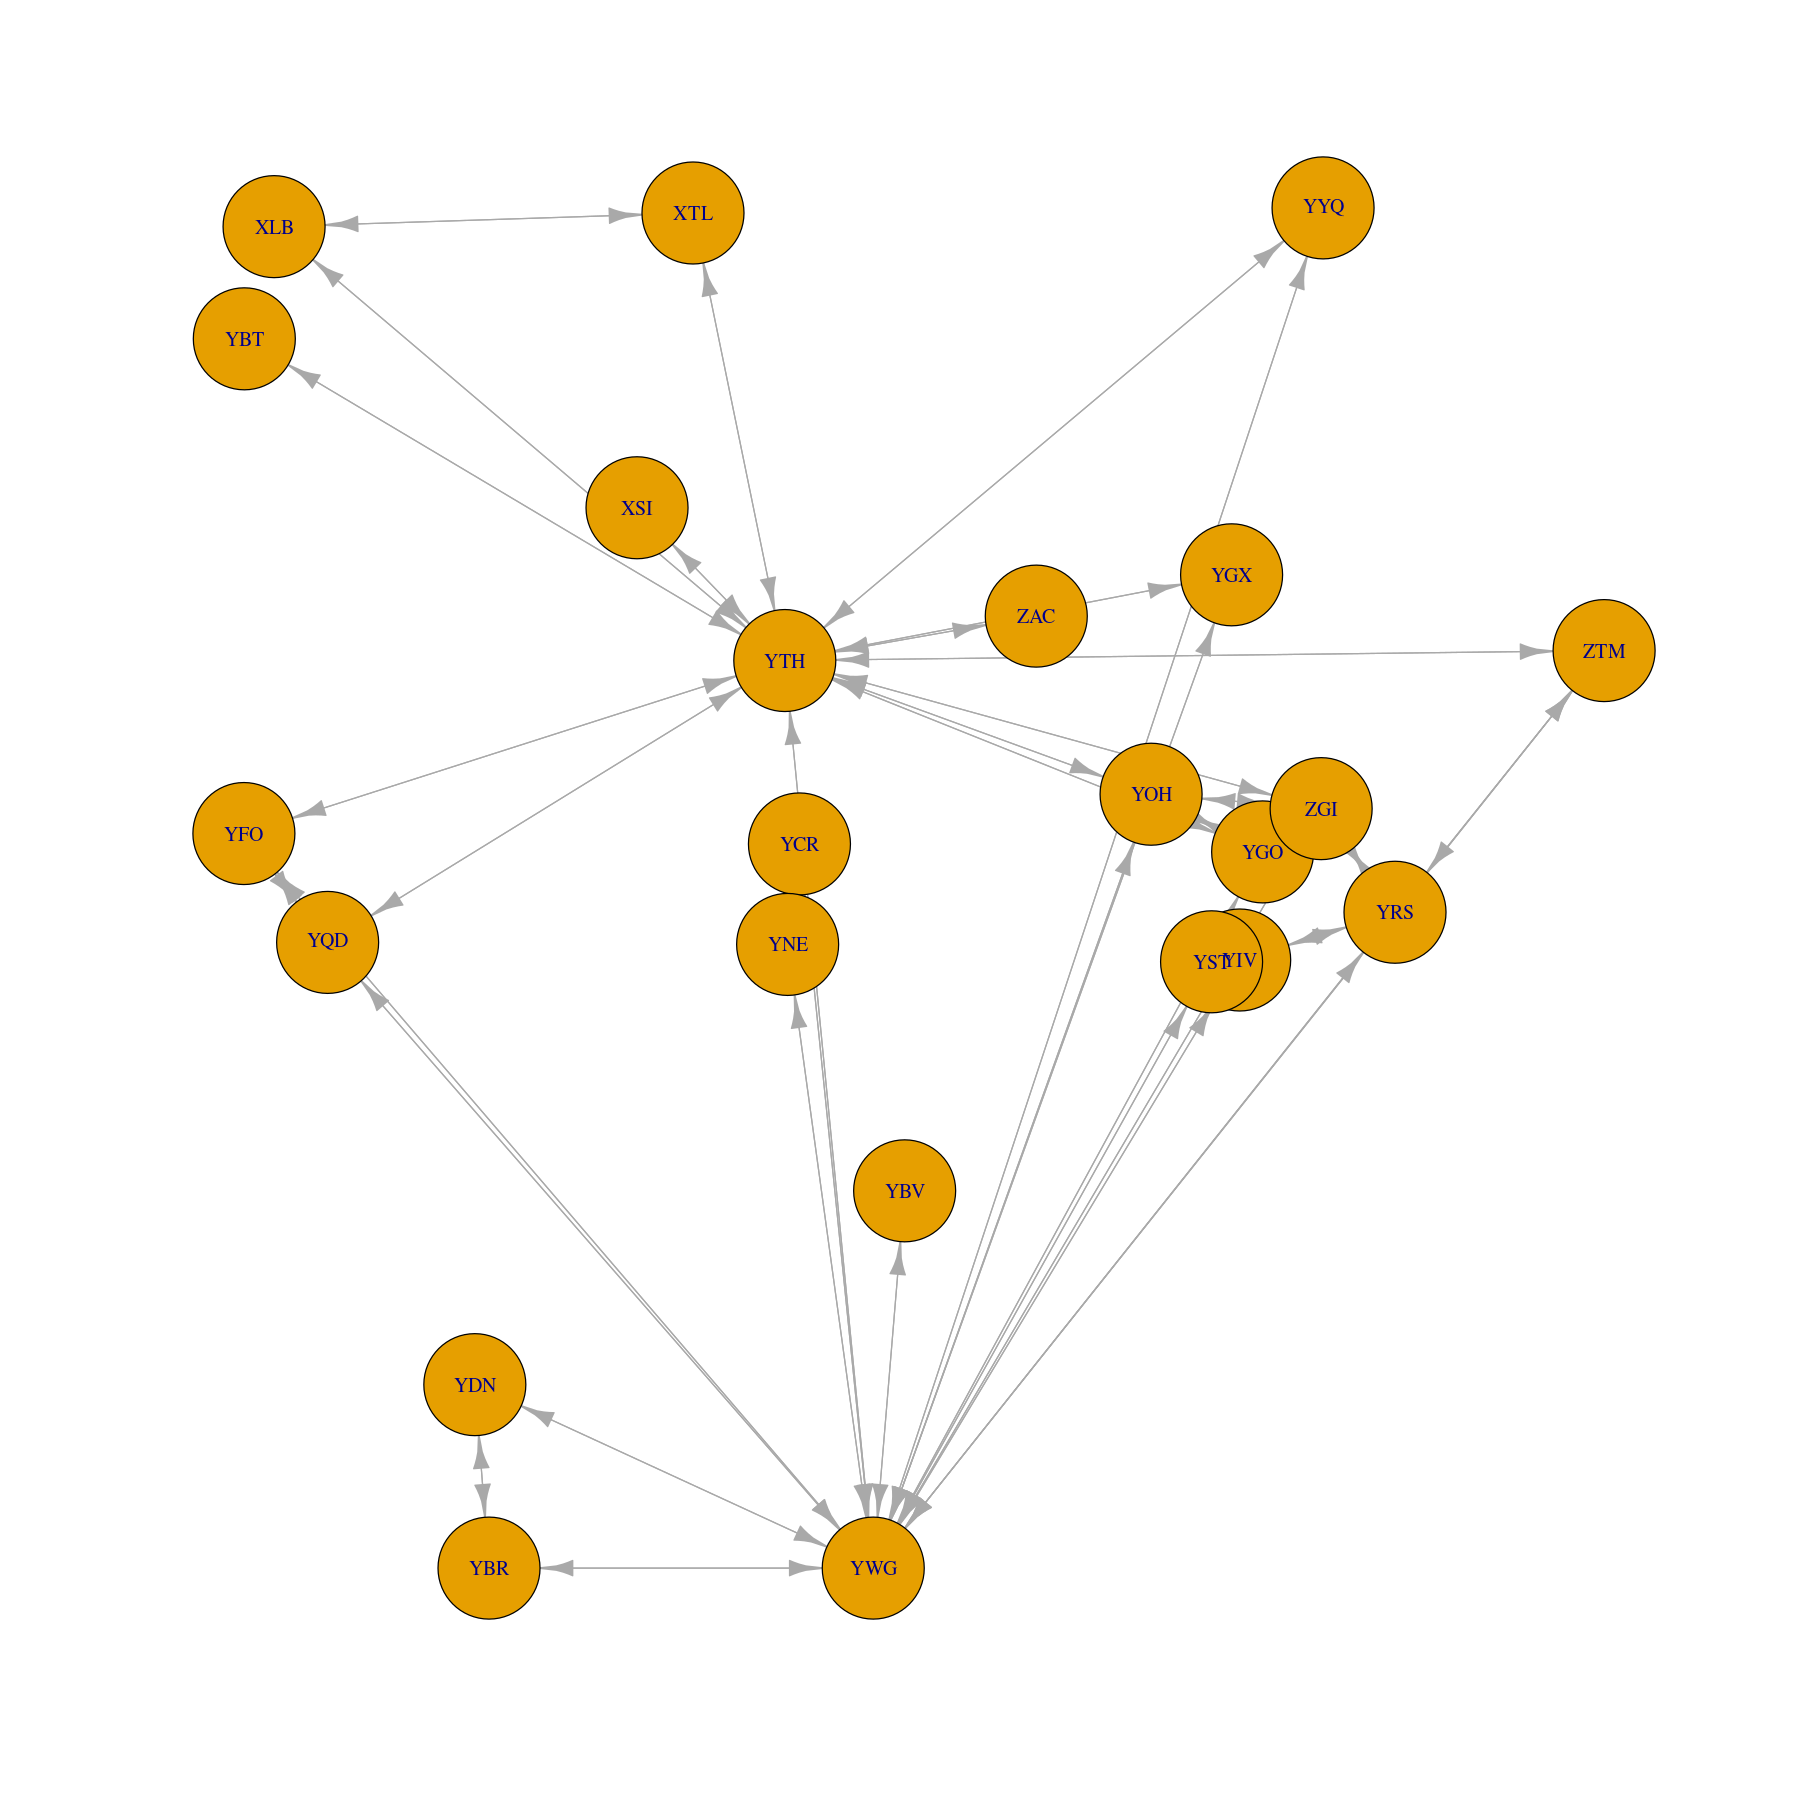

In [57]:
G_MB = induced_subgraph(G, V(G)$name[V(G)$name != "RoW"])
plot(G_MB, edge.arrow.size = 0.5, edge.arrow.width = 0.75)

# Making nicer plots
Before we explore the properties of the graph, let us spend a little time on visualisation. This is not to be neglected: nice plots help more than you think.

The next piece of code does the following:
- Redefine the output size (does it once for all, need to modify if need be)
- Uses the library `raster` to read in the shape file for Canada
- Selects Manitoba from the Canada shape file
- Plots Manitoba
- Plots the graph

Warning message in getData("GADM", country = "CAN", level = 1):
“getData will be removed in a future version of raster
. Please use the geodata package instead”


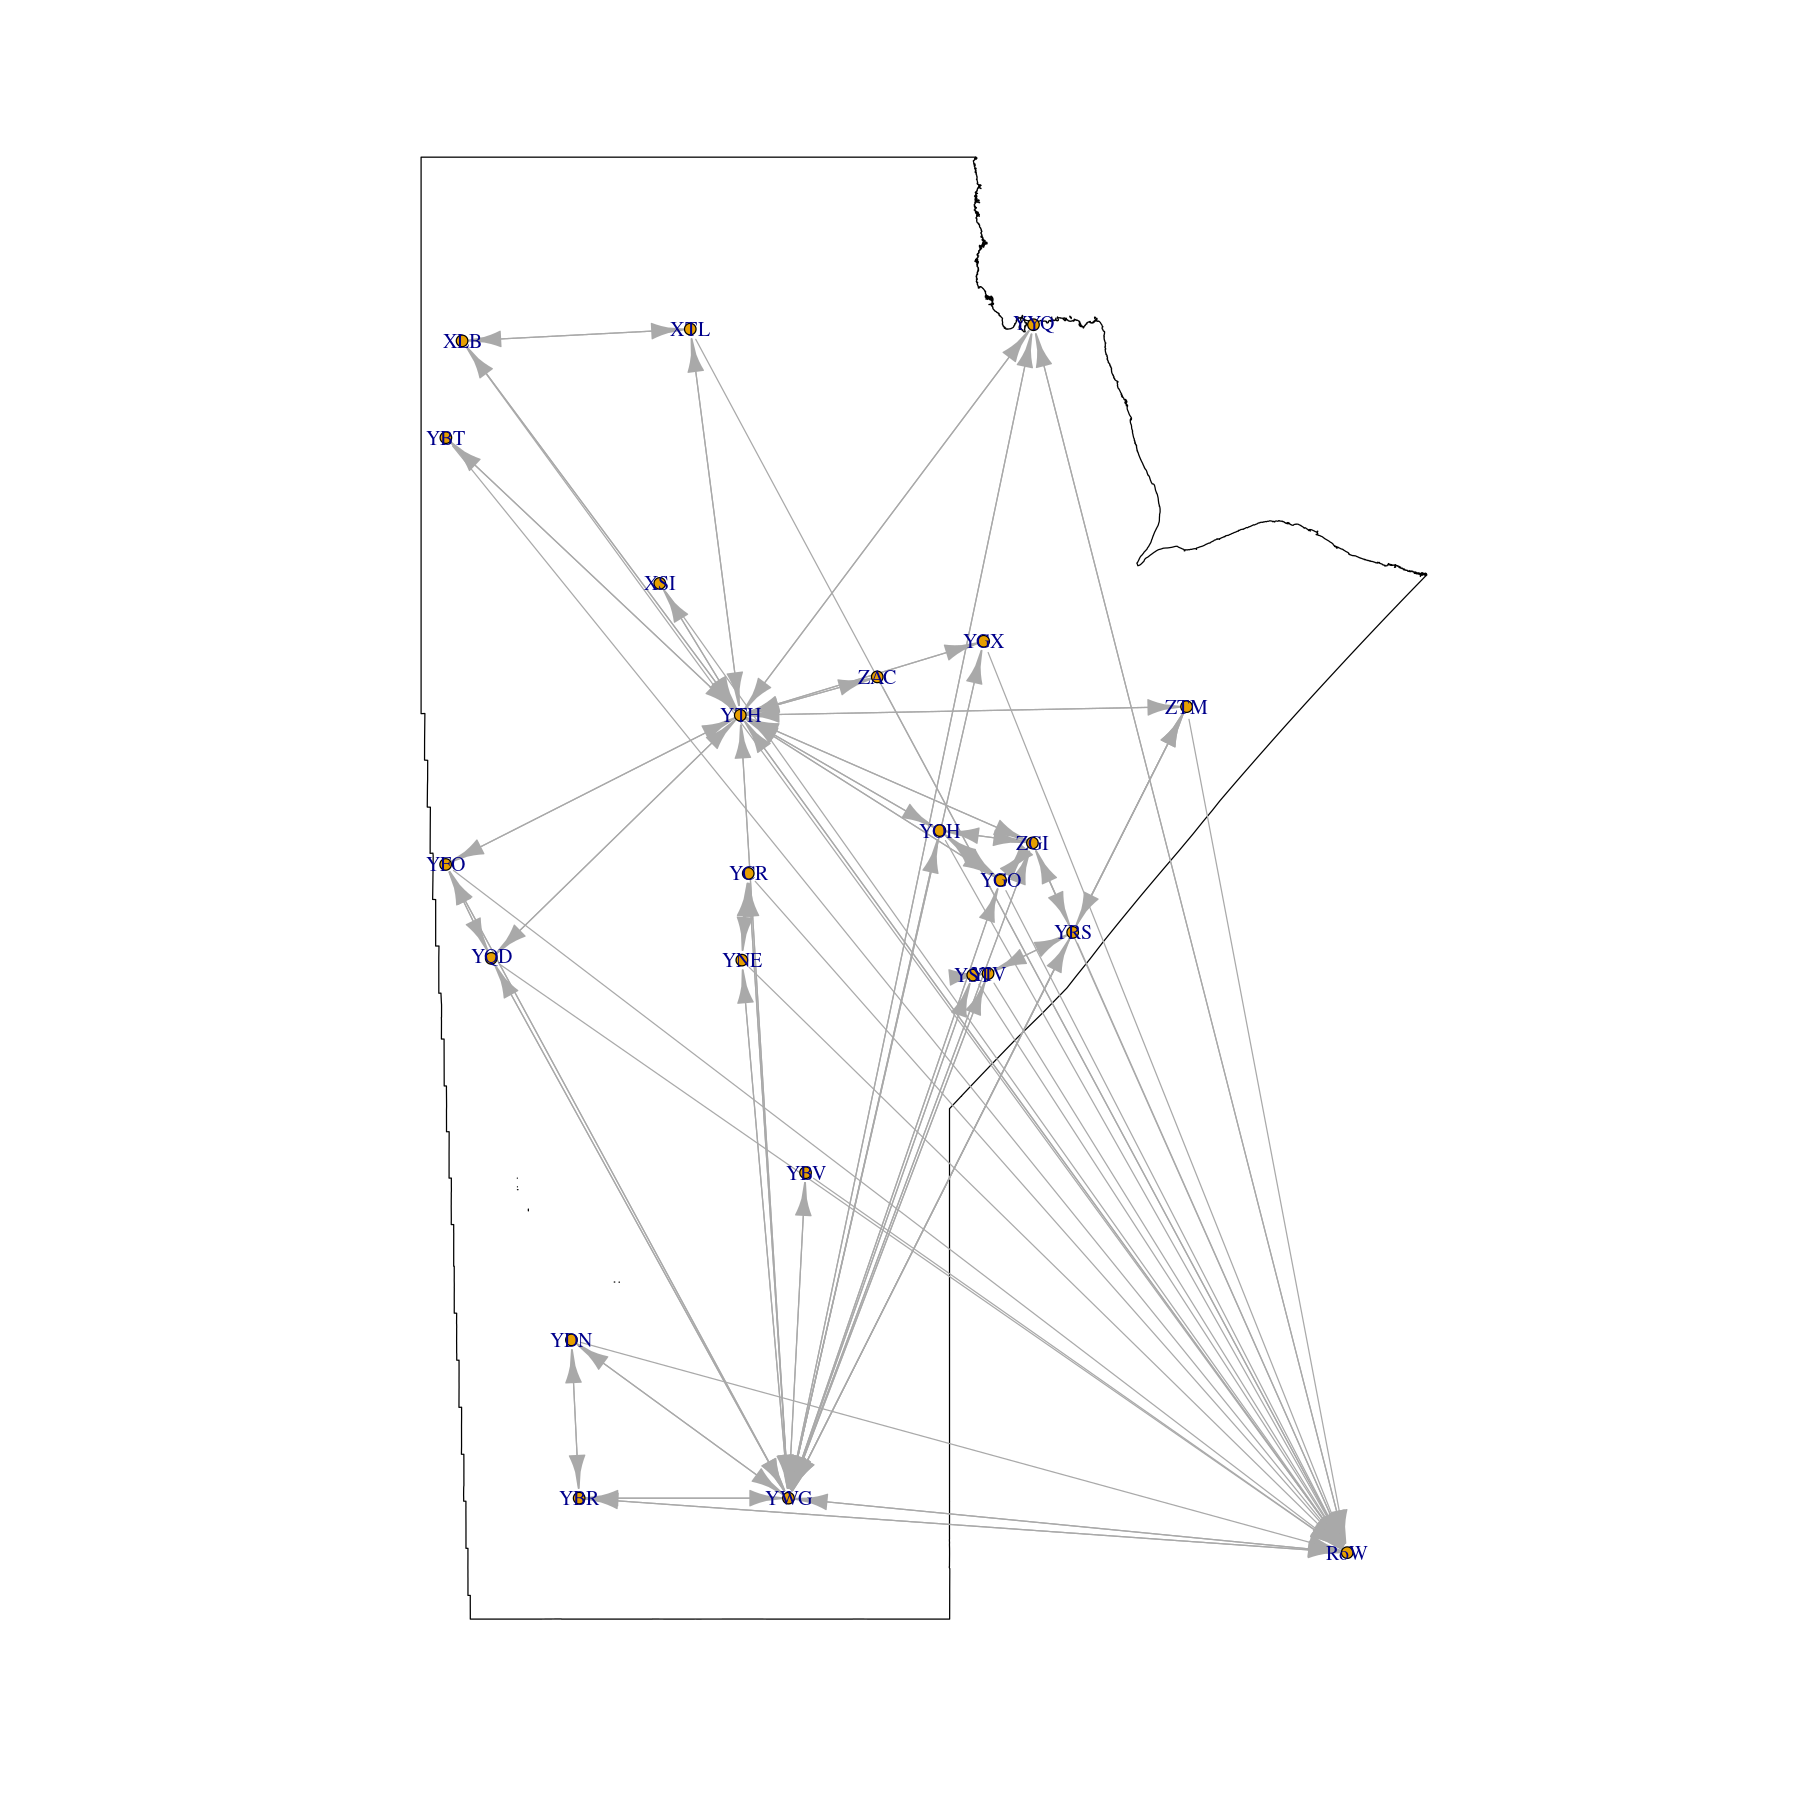

In [58]:
options(repr.plot.width=15, repr.plot.height=15)
Canada <- getData('GADM', country='CAN', level=1)
MB <- Canada[Canada$NAME_1 == "Manitoba",]
plot(MB)
plot(G, add = TRUE, rescale = FALSE,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

Let us add the degree information as the size of the vertices.

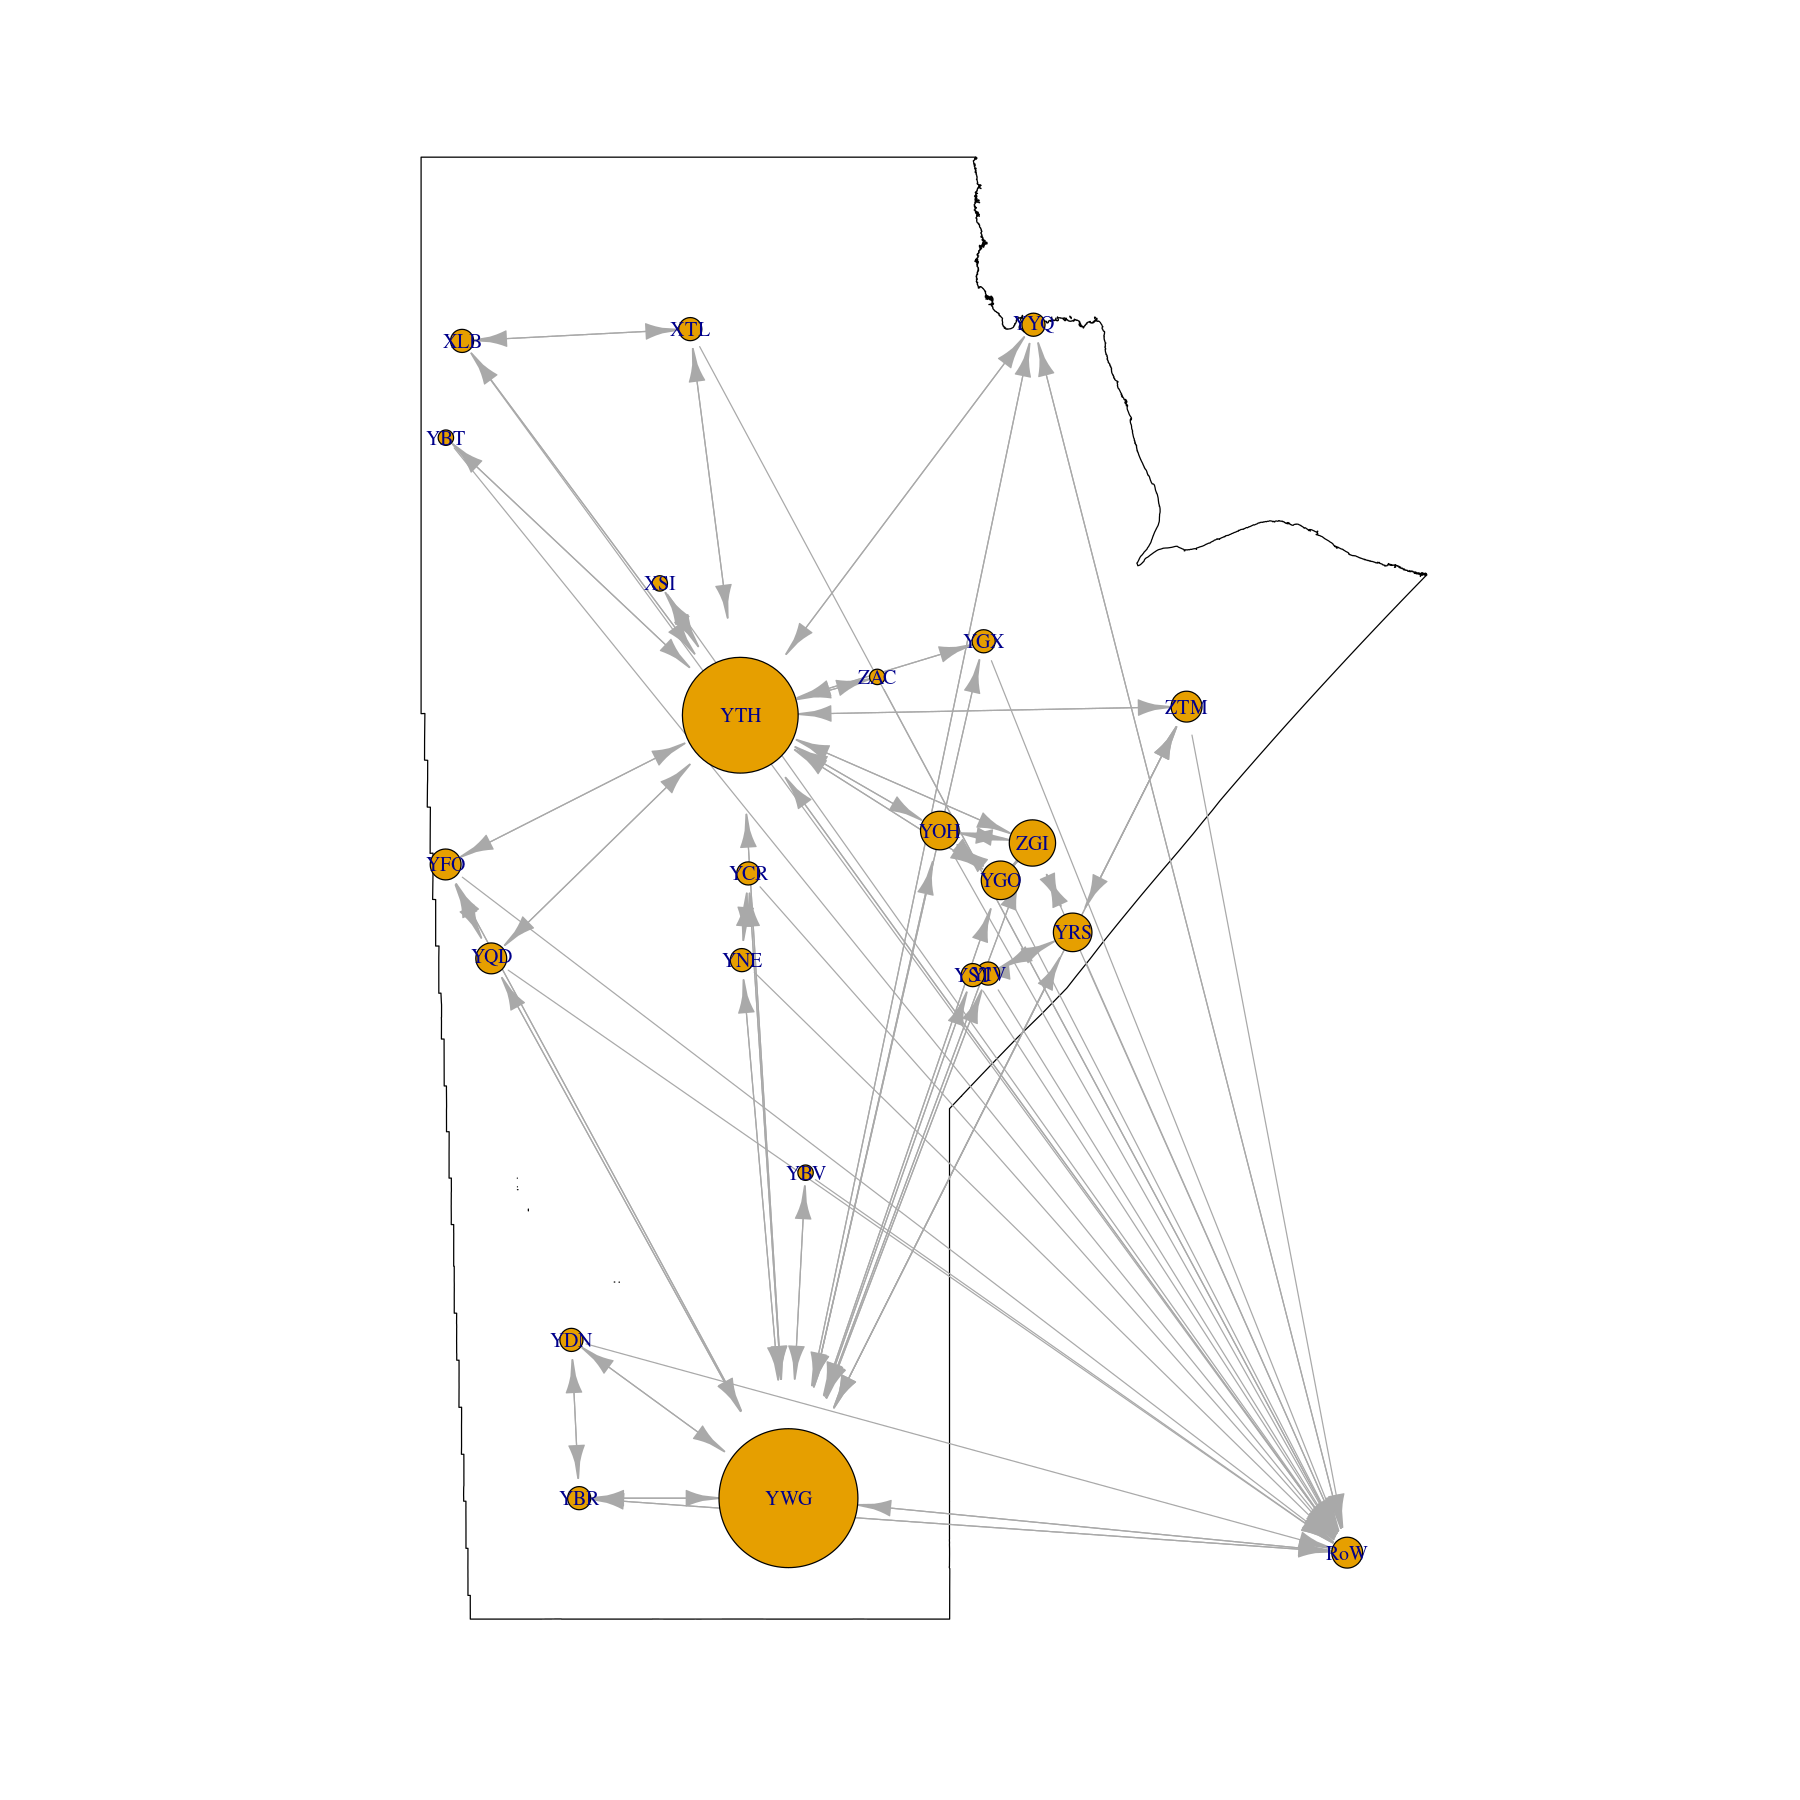

In [59]:
plot(MB)
V(G)$size = degree(G, mode = "out")*10
plot(G, add = TRUE, rescale = FALSE,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

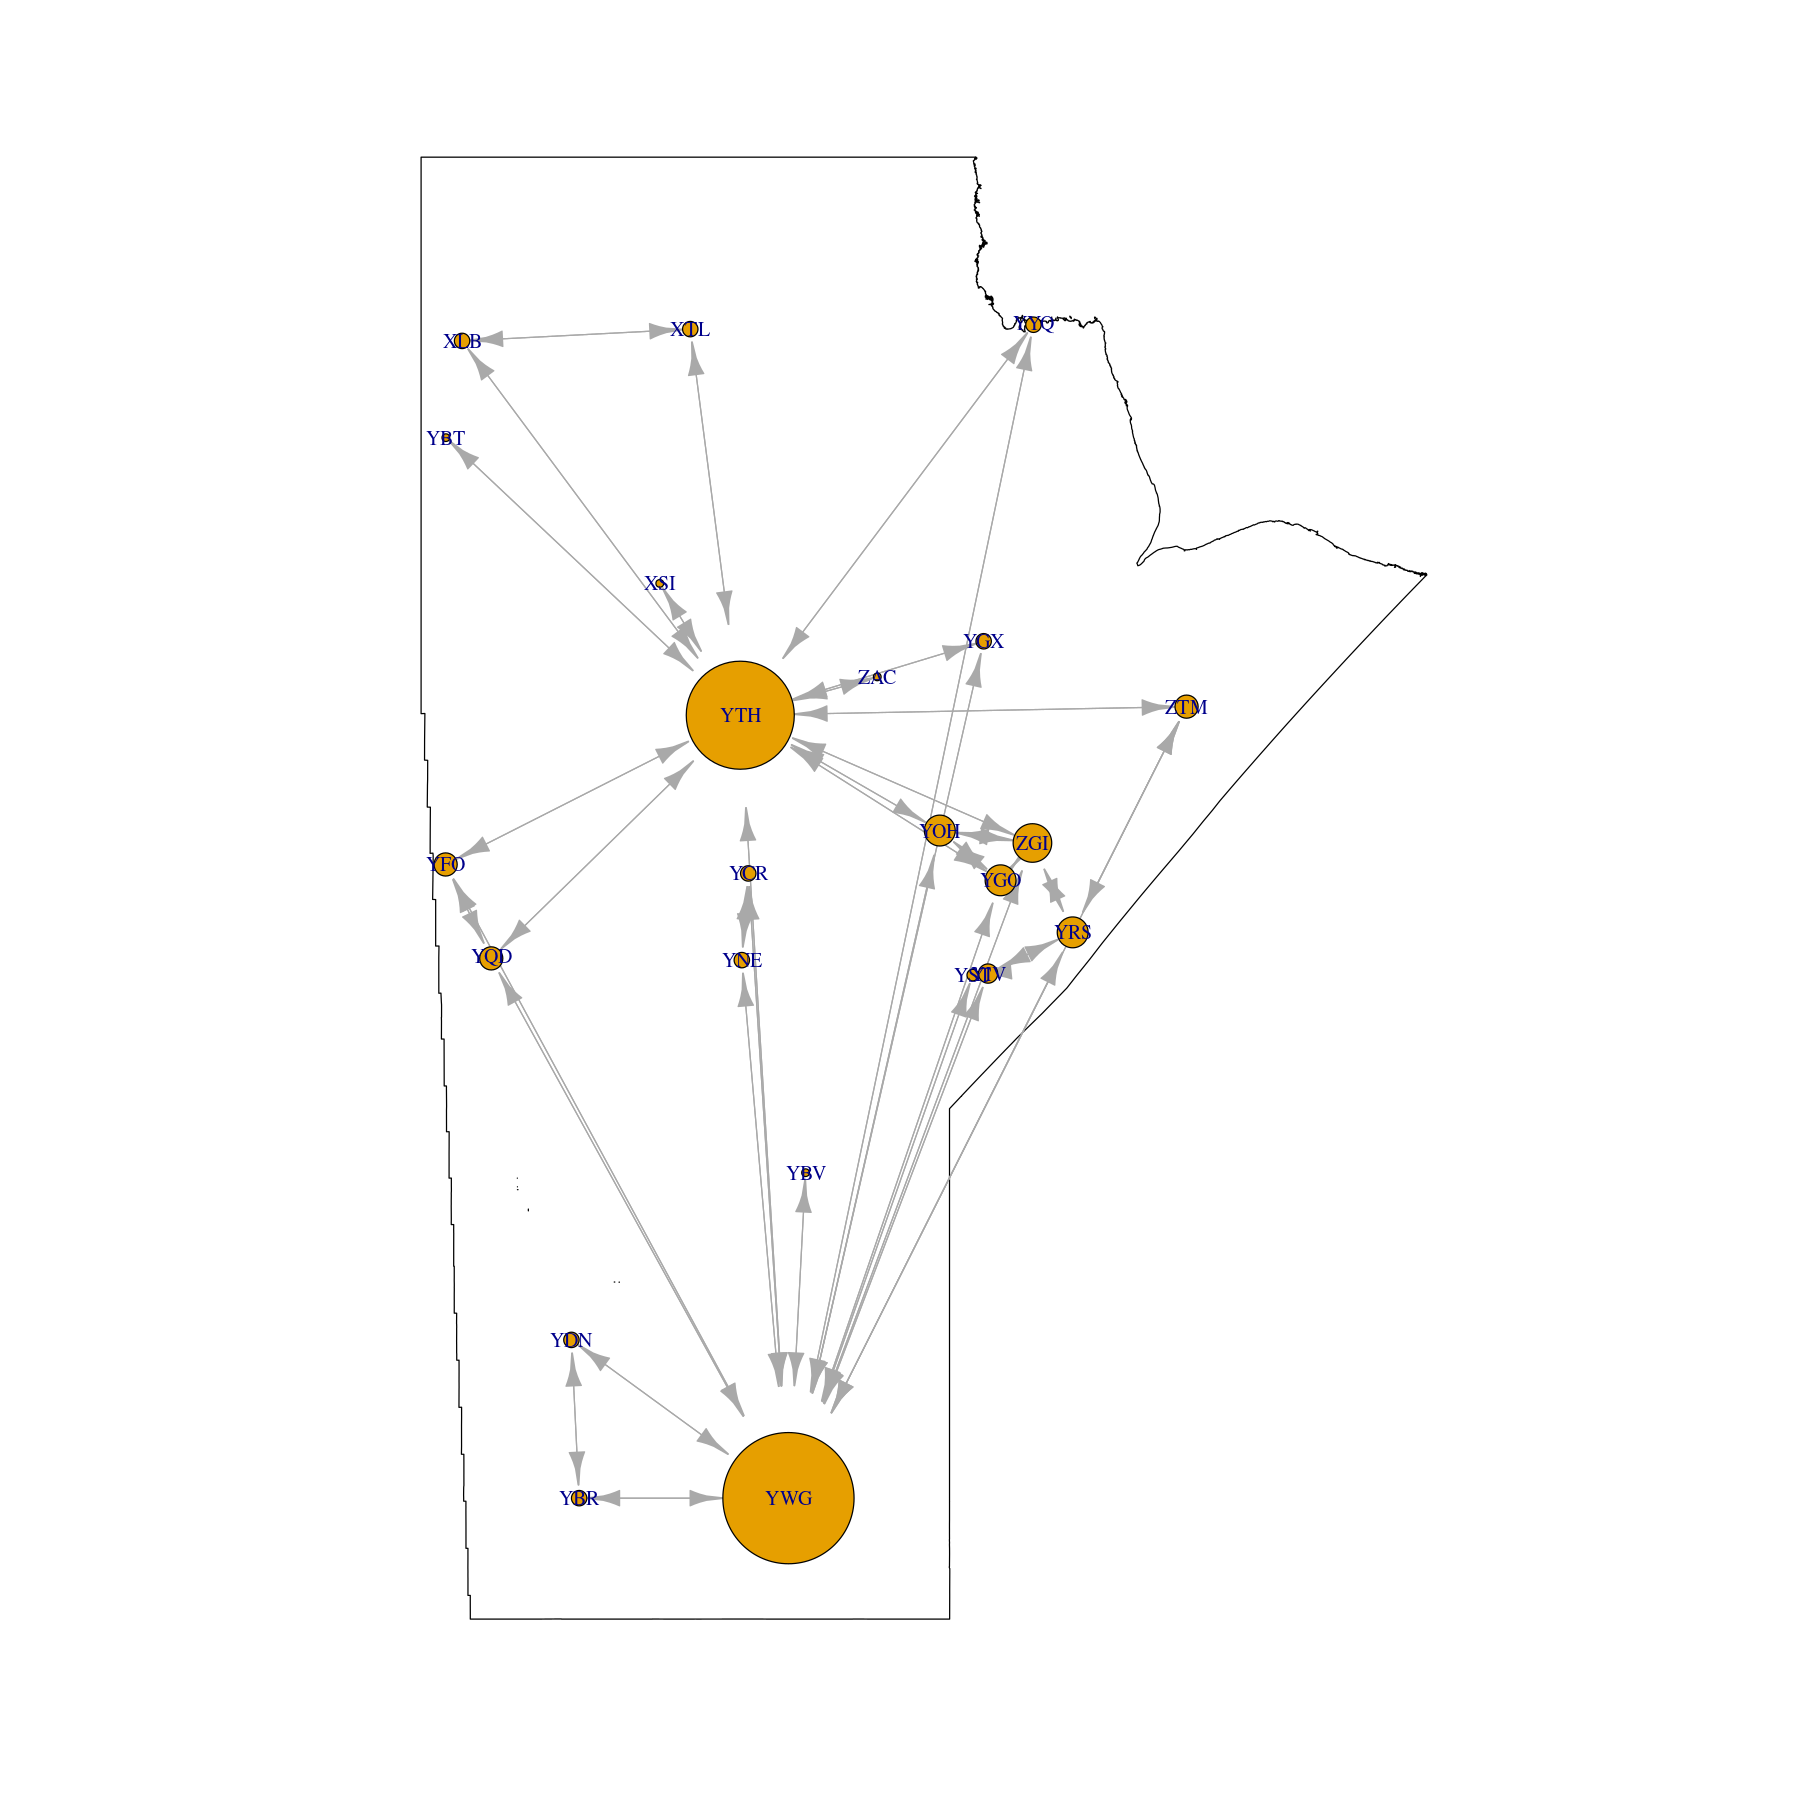

In [60]:
plot(MB)
V(G_MB)$size = degree(G_MB)*5
plot(G_MB, add = TRUE, rescale = FALSE,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

Now let us take a look at the arcs. Maybe change their thickness to reflect the volumes along the arcs?

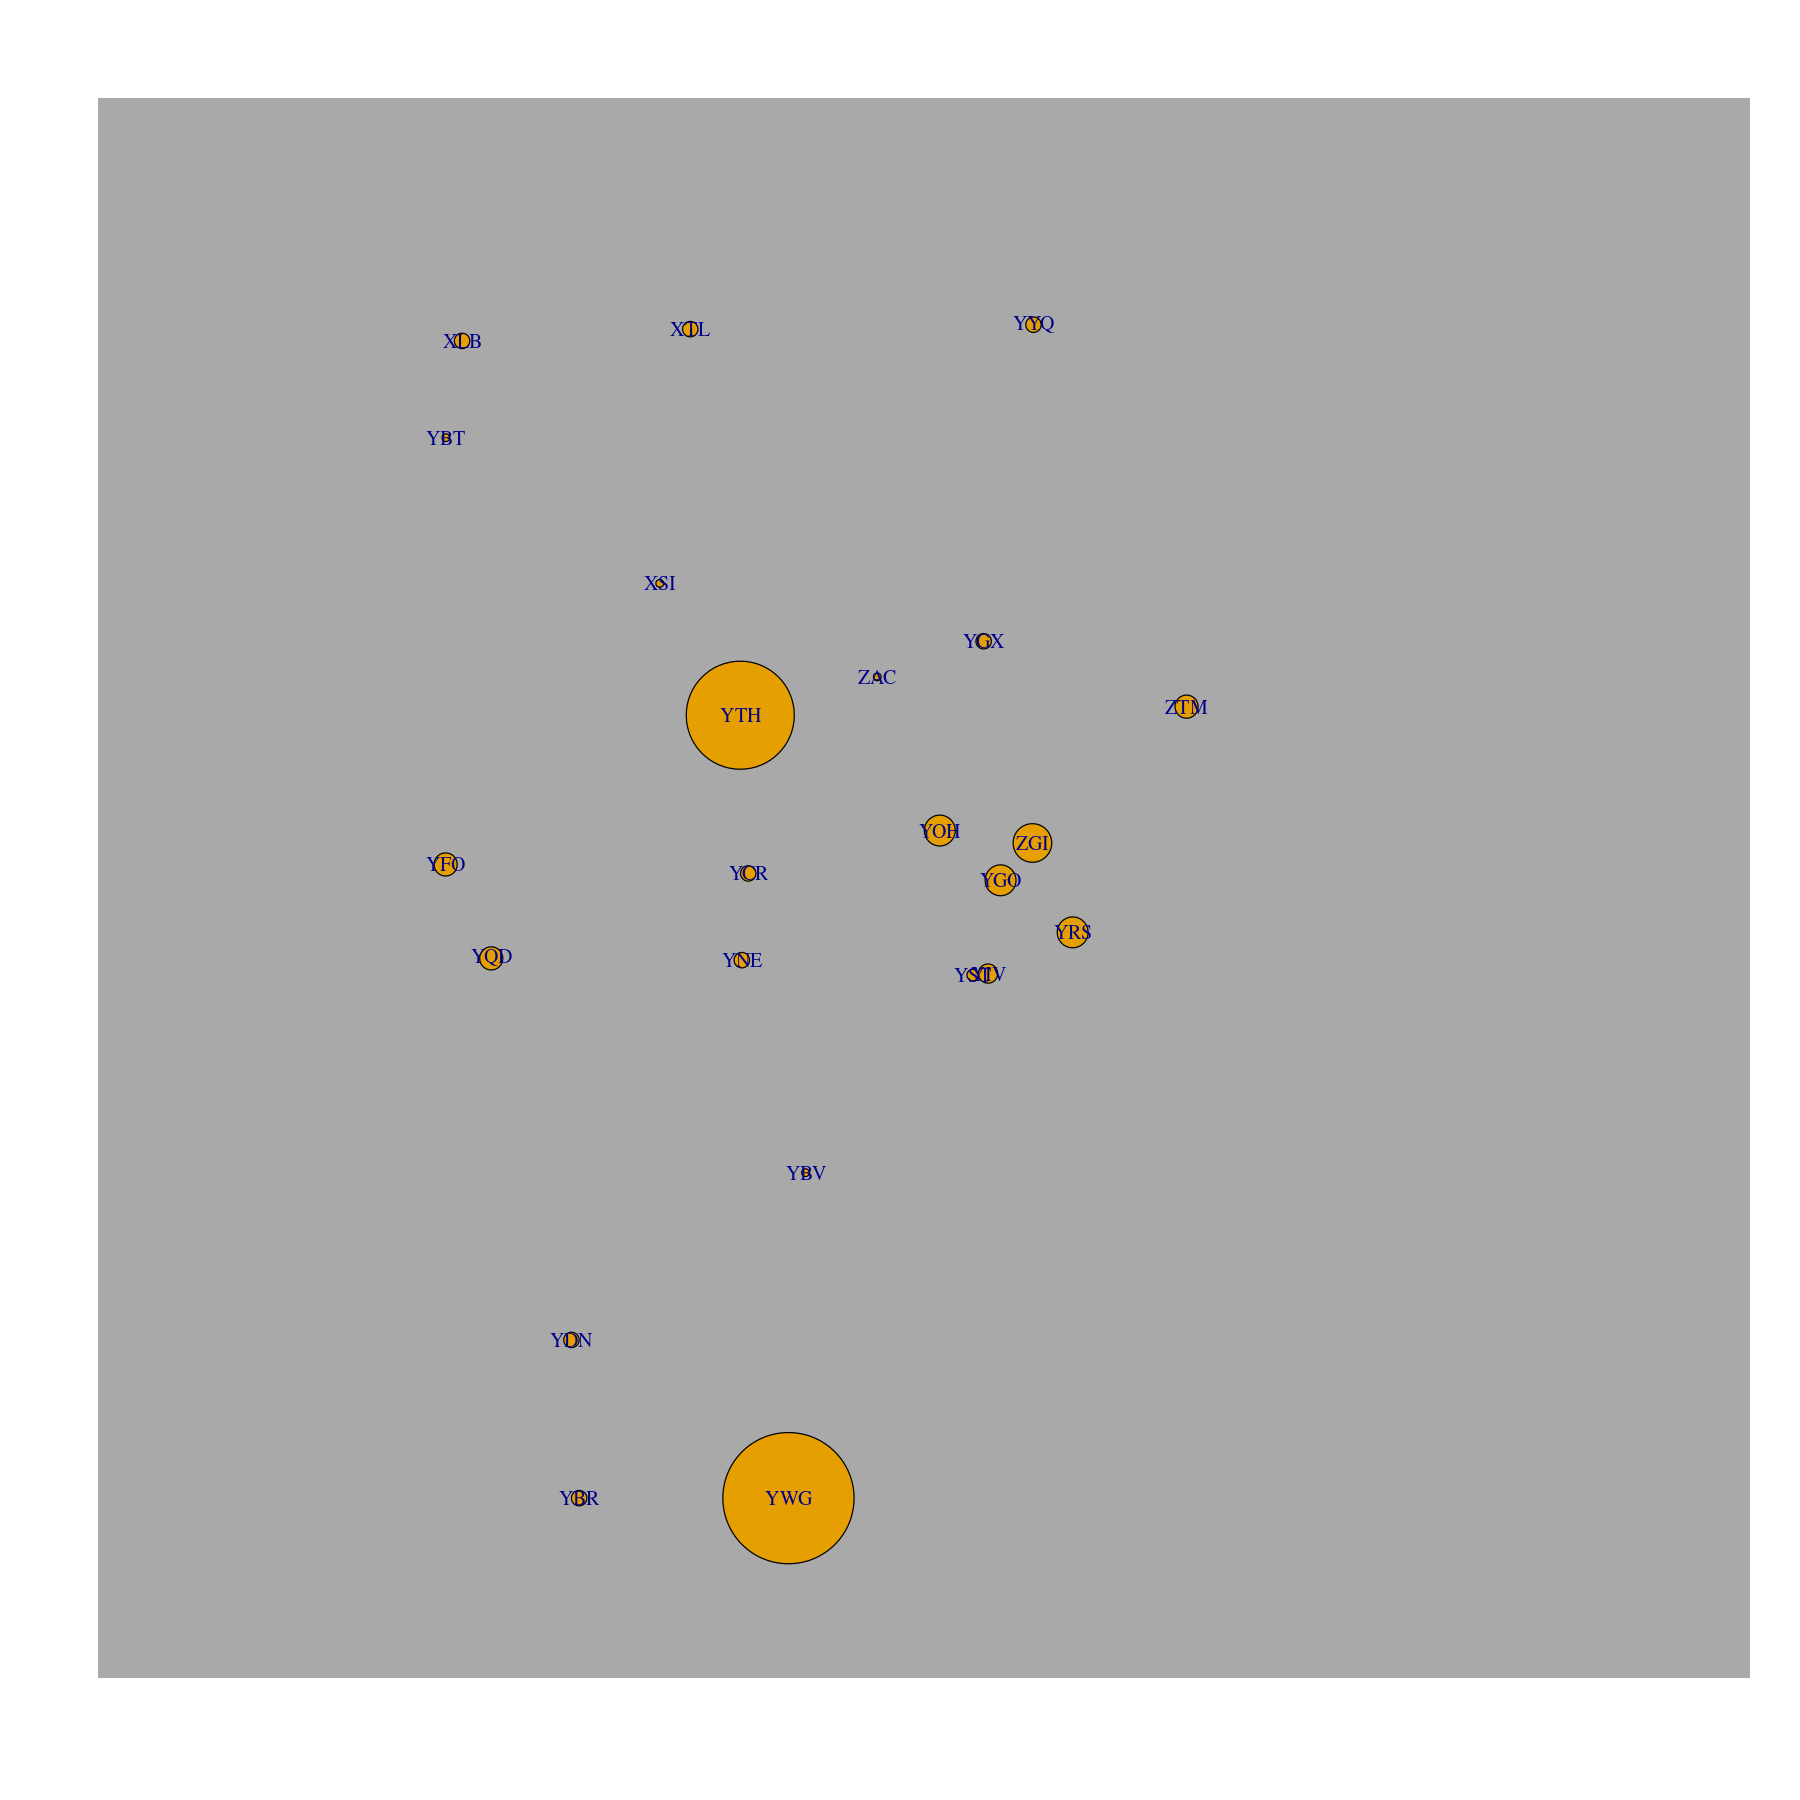

In [61]:
plot(MB)
V(G_MB)$size = degree(G_MB)*5
plot(G_MB, add = TRUE, rescale = FALSE, edge.width = E(G_MB)$vol,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

My guess: some of the arcs are so massive that this is all we can see. So let us renormalise the values of the weights. First, what do they look like now?

In [62]:
sort(E(G)$vol)

[1]     18     47     48     48     50     98     99    114    116    174
 [11]    176    208    208    212    242    276    278    279    288    288
 [21]    288    292    292    309    337    337    343    344    364    366
 [31]    368    369    372    383    399    401    401    406    447    447
 [41]    449    451    451    462    529    565    567    582    592    644
 [51]    650    652    652    682    684    694    696    701    702    713
 [61]    714    758    766    780    806    848    854   1036   1050   1167
 [71]   1172   1242   1270   1279   1342   1349   1394   1462   1464   1474
 [81]   1485   1543   1565   1607   1638   1750   1857   2002   2230   2518
 [91]   2582   2877   2899   2910   2924   3037   3157   3355   3355   3365
[101]   4246   4571   5770   5789   7430  11464 157323 183256

So, yes, clearly a bit too much variation. If we scale linearly by multiplying by a constant, we will most likely lose the information on the small weights. Just to check that we are intuiting correctly, though, let us try once doing this.

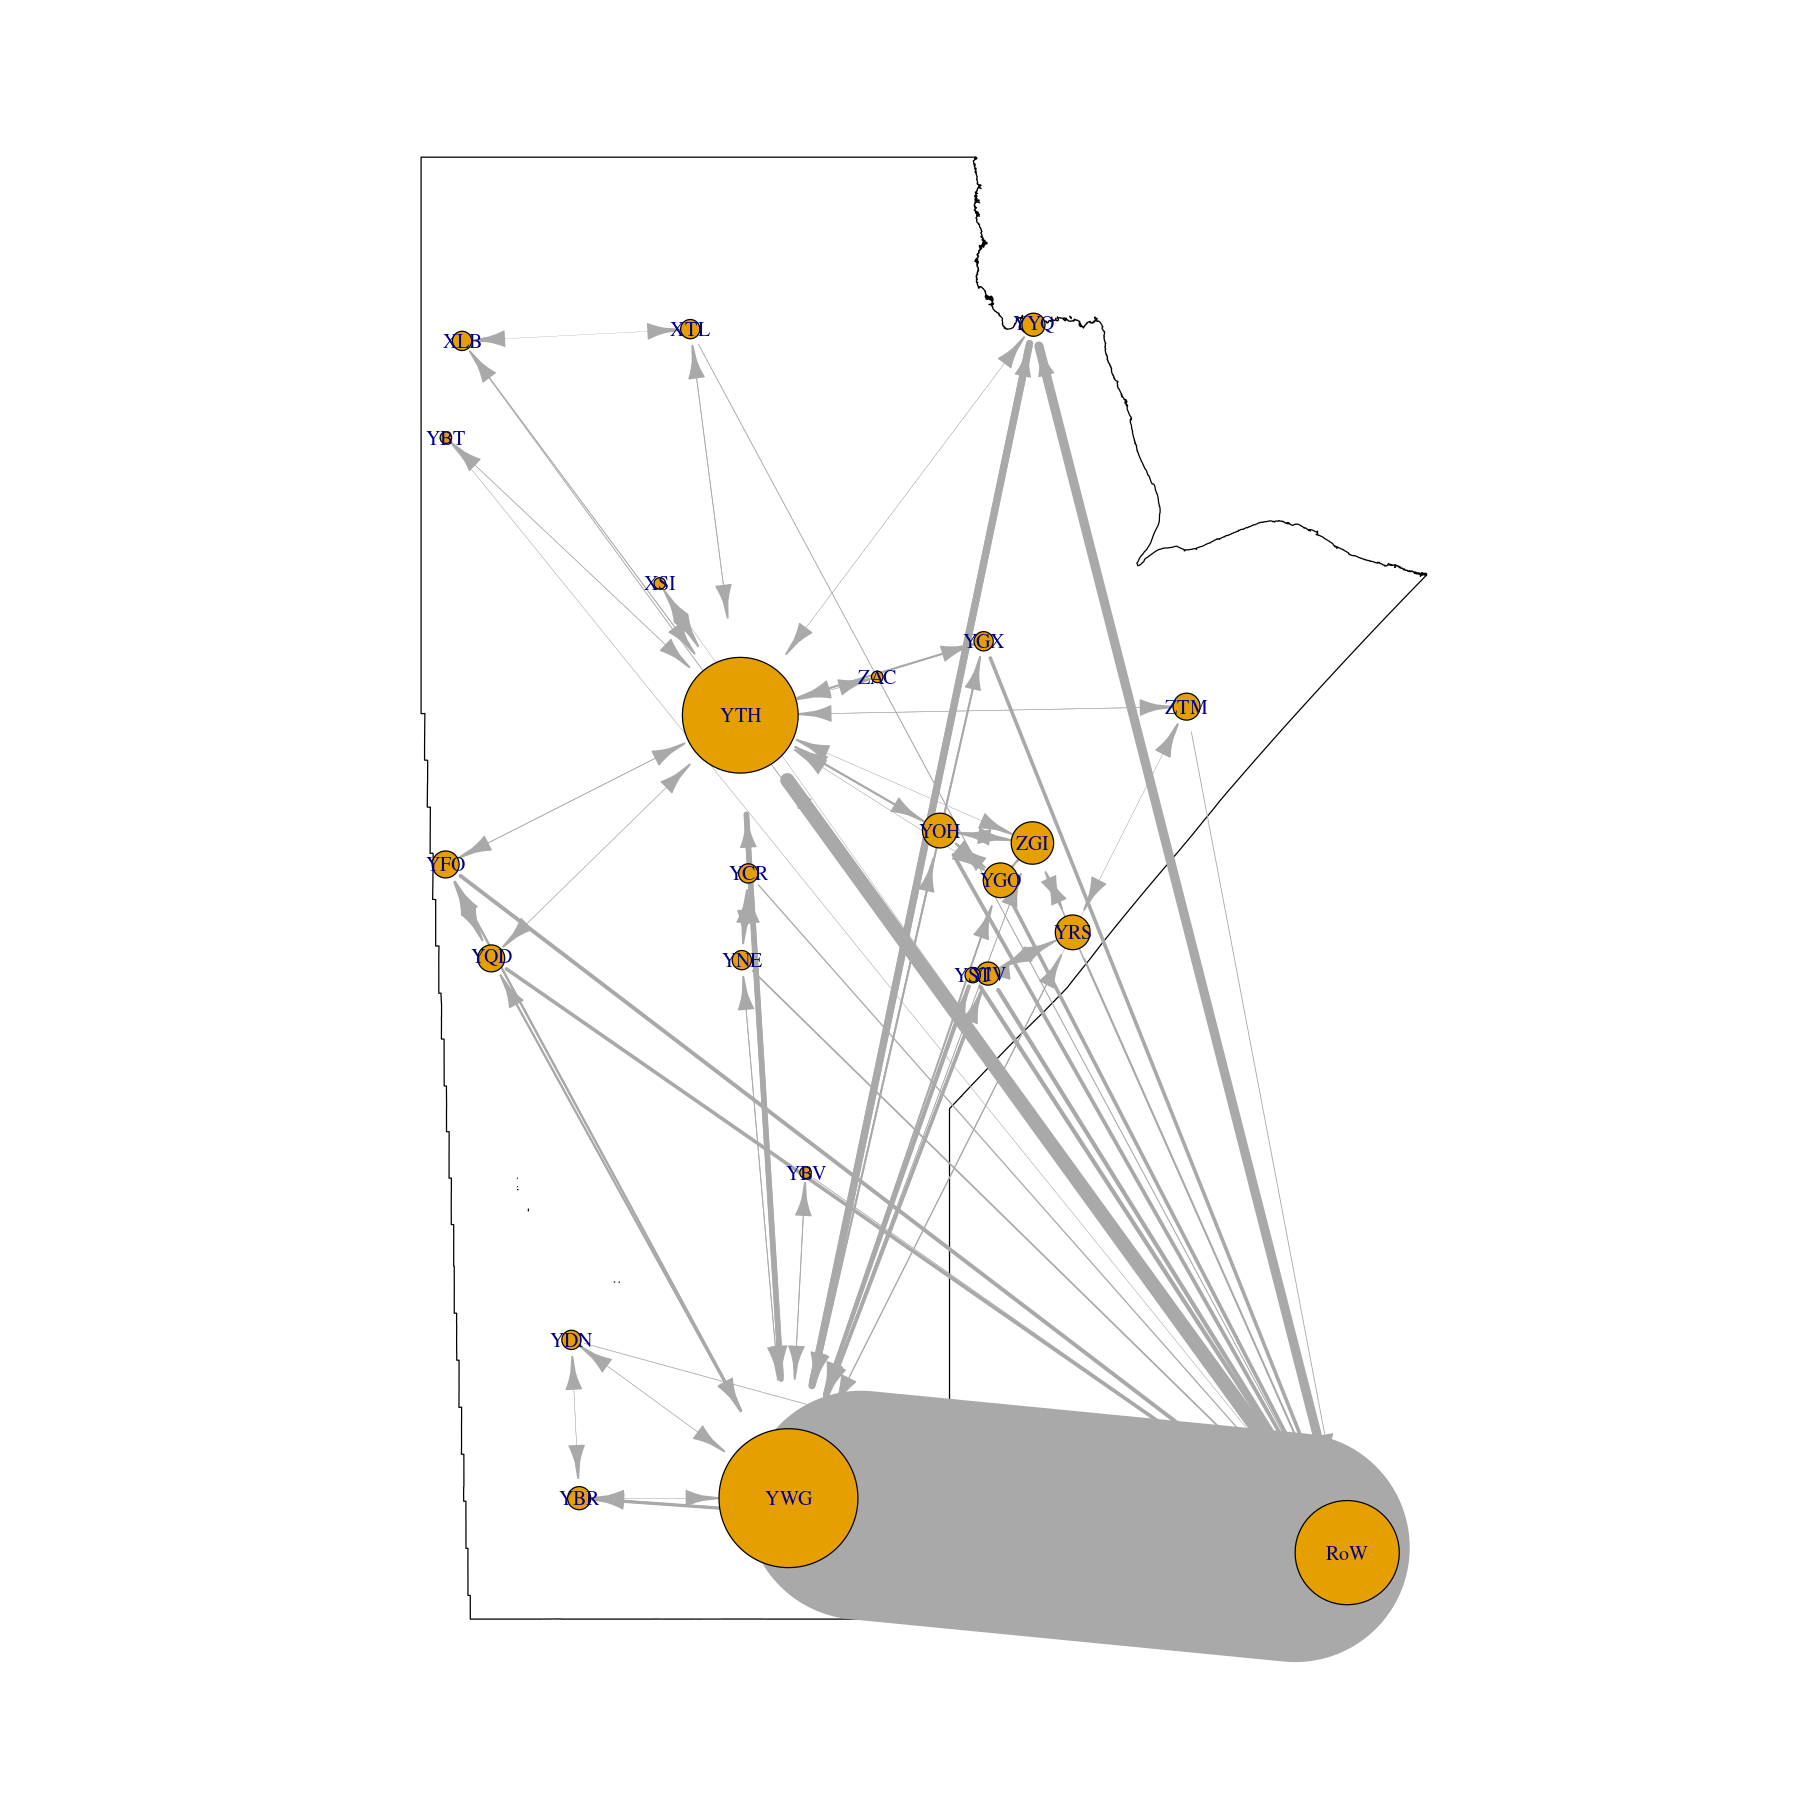

In [63]:
plot(MB)
V(G)$size = degree(G)*5
plot(G, add = TRUE, rescale = FALSE, edge.width = E(G)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

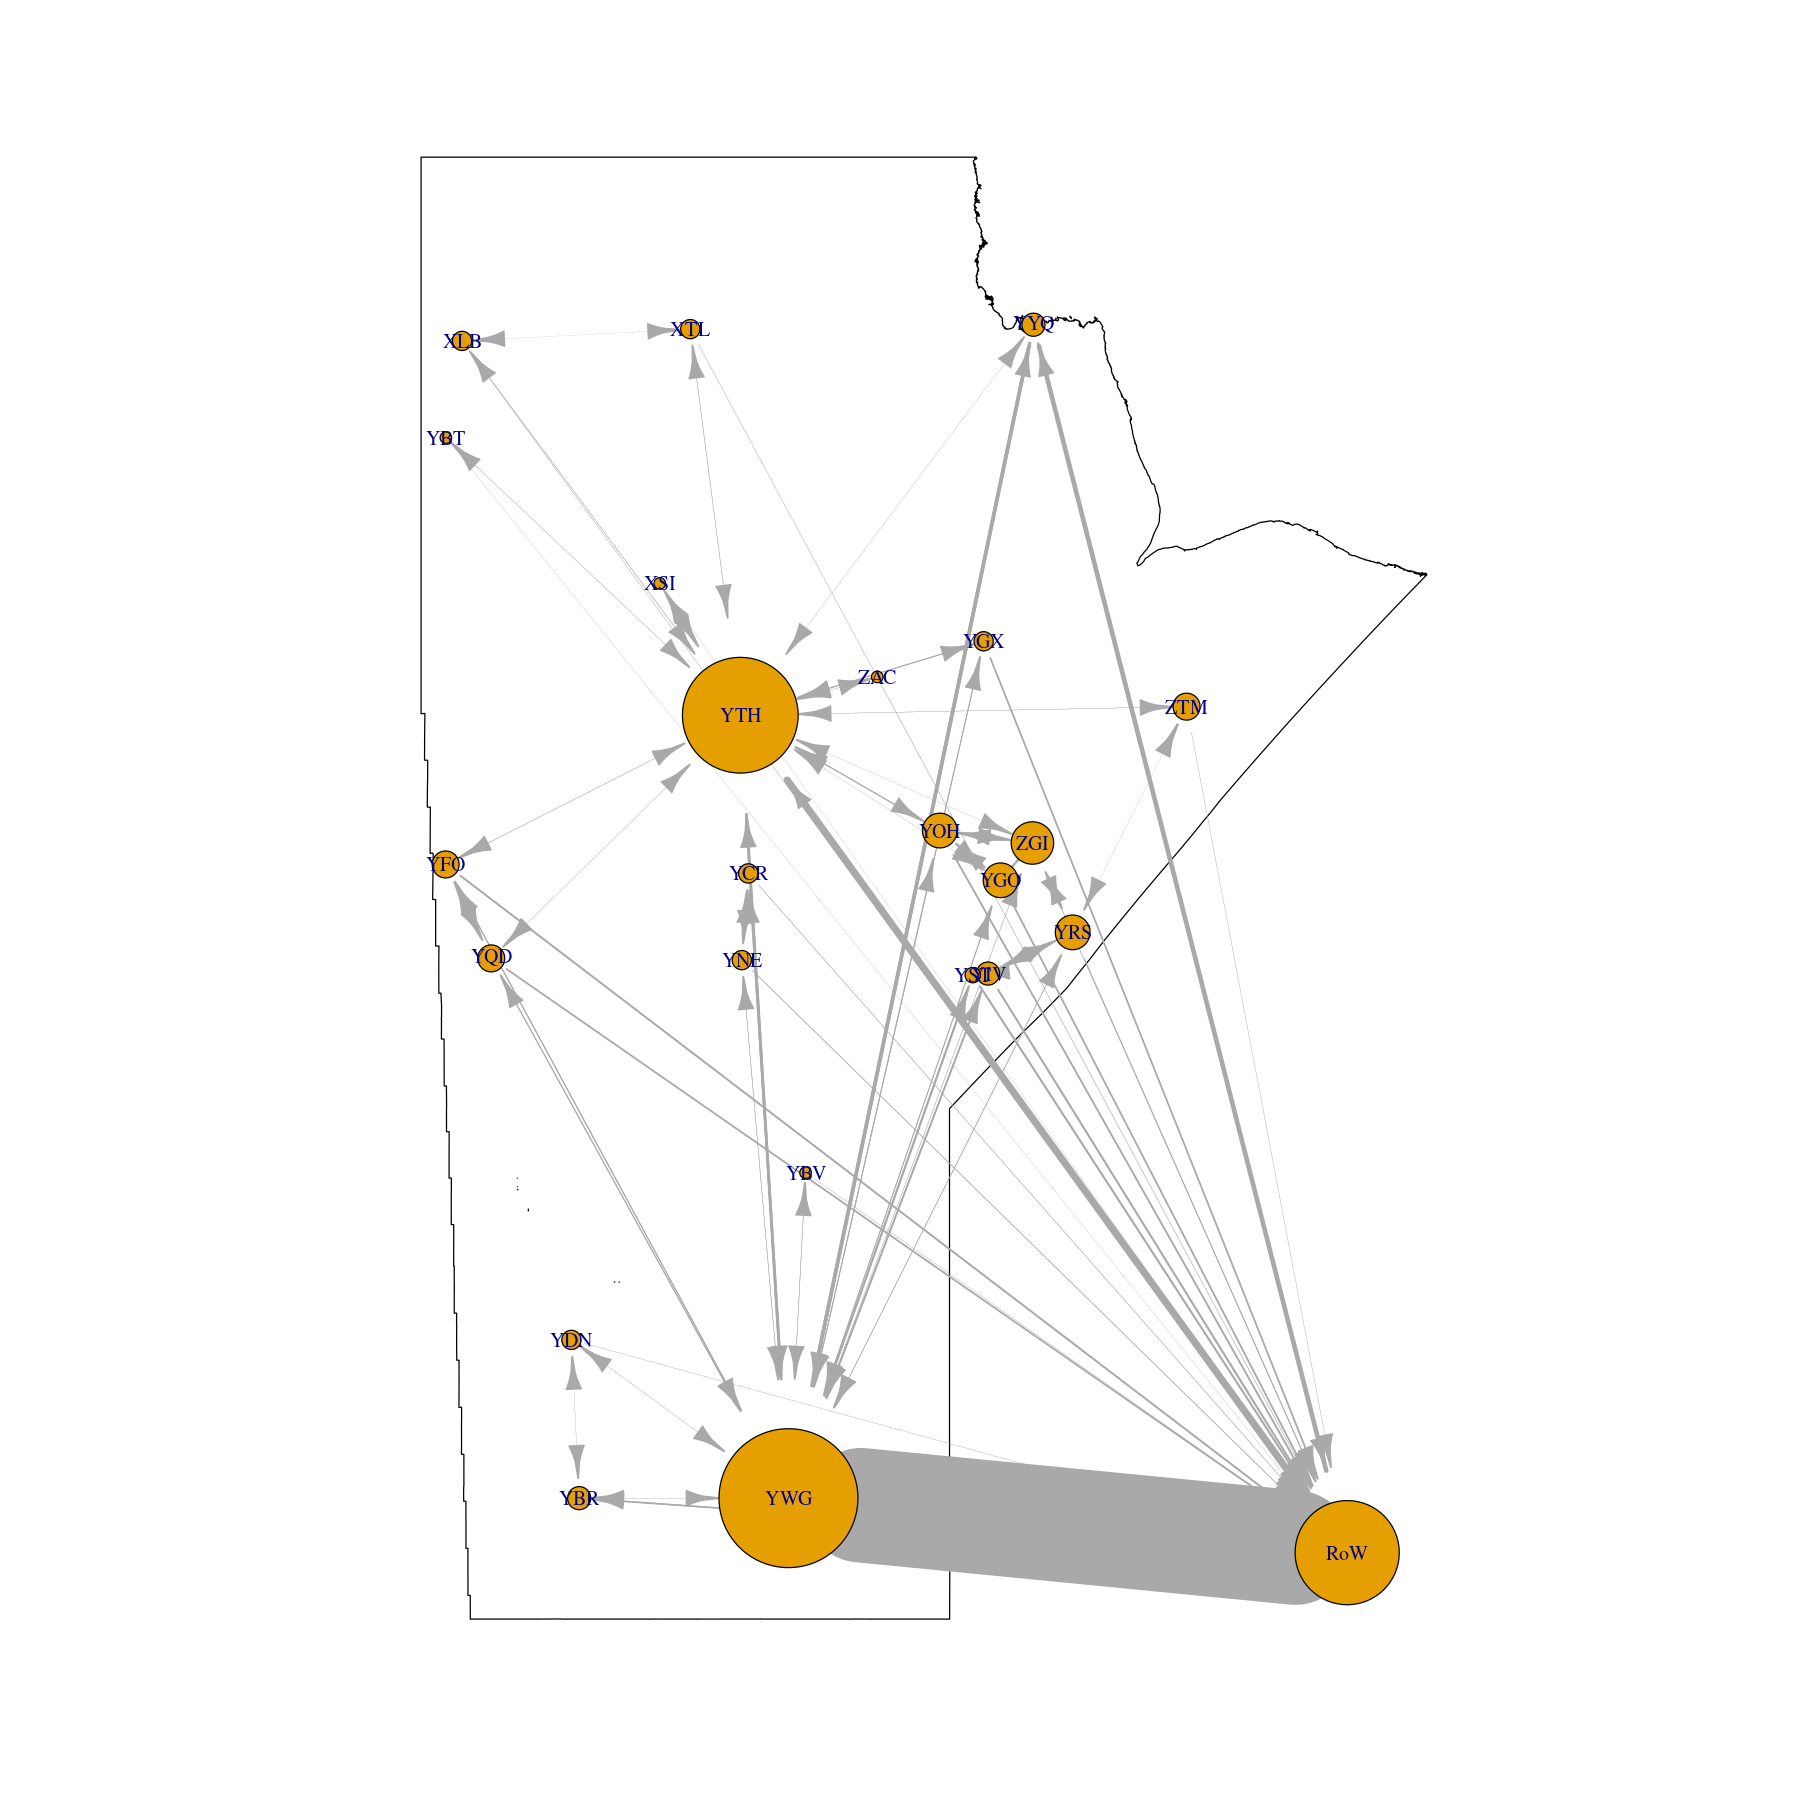

In [64]:
plot(MB)
V(G)$size = degree(G)*5
plot(G, add = TRUE, rescale = FALSE, edge.width = E(G)$vol*0.0005,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

What we suspected, indeed: to make the arcs with the largest volume not too large, we had to essentially get rid of the weight of the arcs with small volumes. So what we want to do is to process the values through a function that would make the smaller values larger relative to the larger ones or the larger values closer to the smaller one, then scale the result. For this, it is good to look at what the values look like.

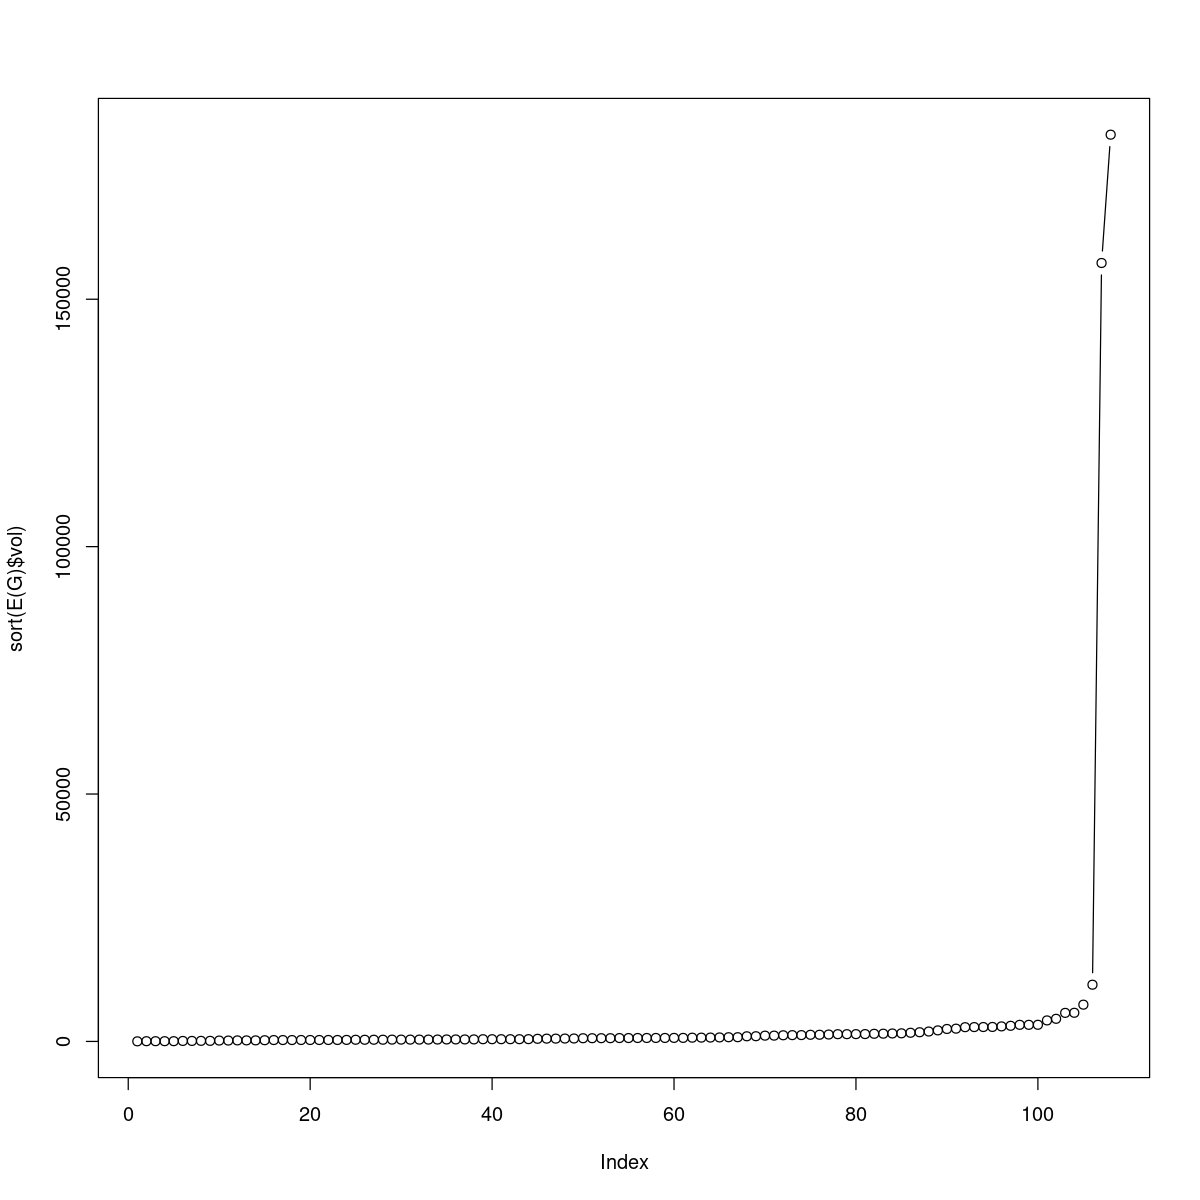

In [18]:
options(repr.plot.width=10, repr.plot.height=10)
plot(sort(E(G)$vol), type = "b")

One way around this could be to use a so-called sigmoid function. This is a function of the following form:
$$
f(x) = \dfrac{1}{1+e^{-cx}},
$$
where $\mathbb{R}\ni c>0$ is a parameter.
This function has the following properties: $\lim_{x\to-\infty}f(x)=0$ and $\lim_{x\to\infty}f(x)=1$. By playing with the value of $c$, one can set the beahviour of $f$. Let us see how different values of $c$ influence the value of the points. (The `viridis` palette used starts with yellow and goes towards green and then purple.)

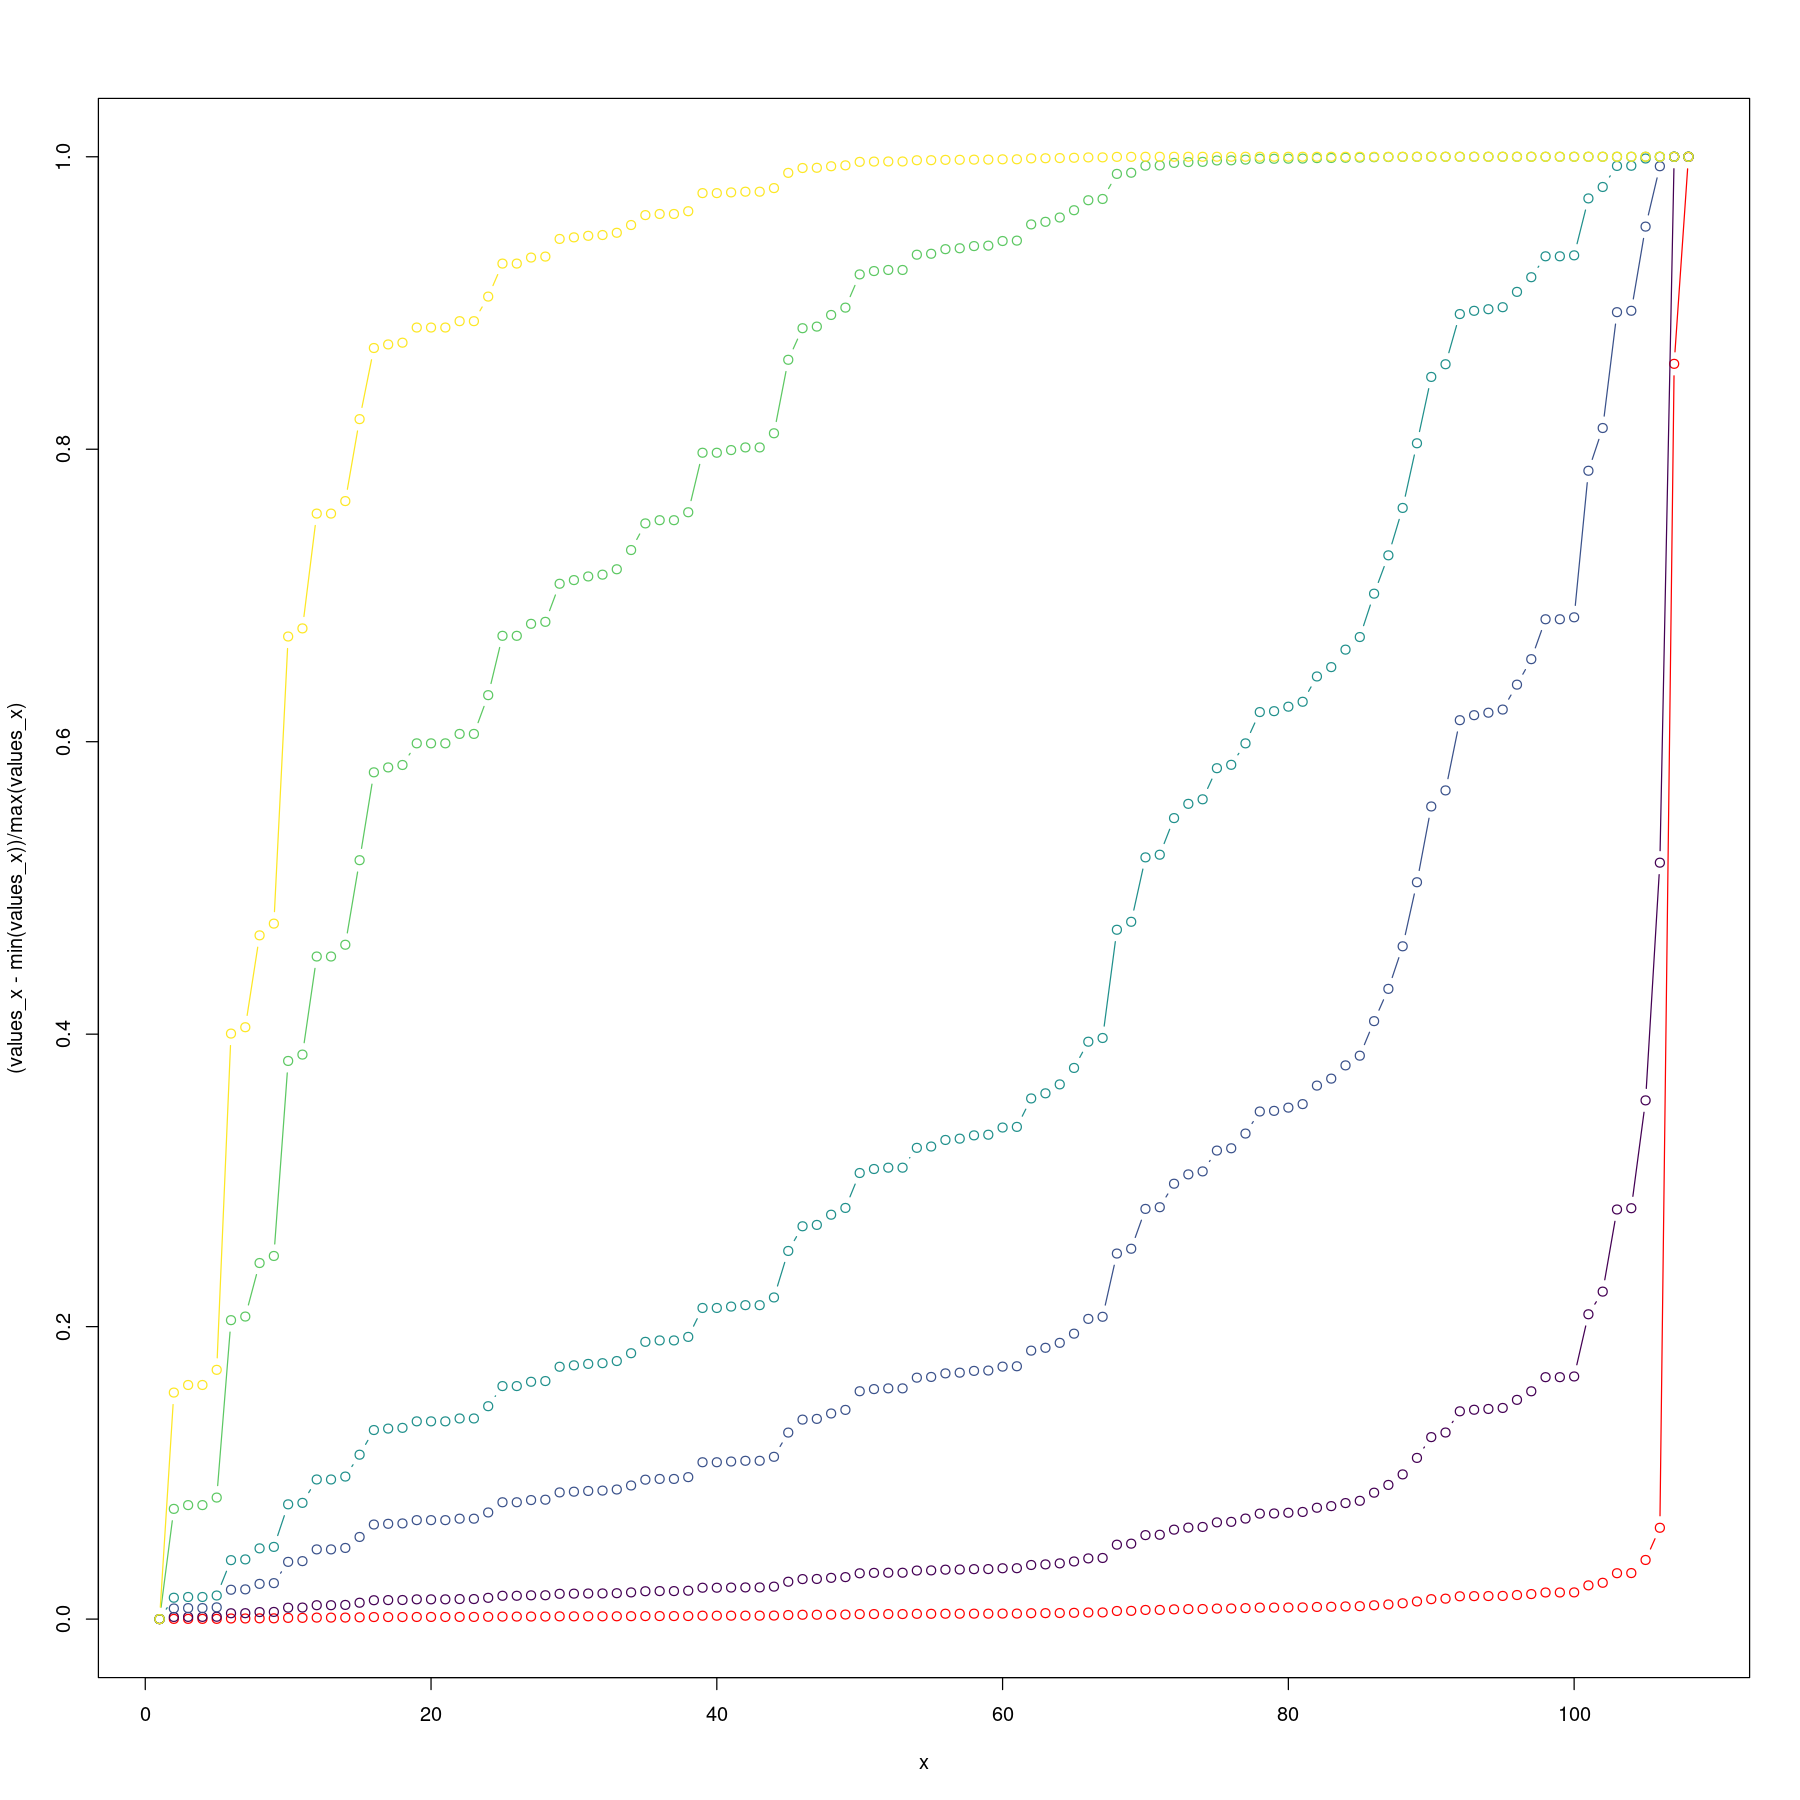

In [65]:
sigmoid = function(x, c) {
    return(1/(1+exp(-c*x)))
}

values_c = c(0.0001, 0.0005, 0.001, 0.005, 0.01)
x = 1:length(E(G))
values_x = sort(E(G)$vol)
my_palette = viridis::viridis(length(values_c))

# First, we plot the "data" (scaled to the [0,1] range)
plot(x, (values_x-min(values_x))/max(values_x), 
     type = "b", col = "red",
     ylim = (range(values_x)-min(values_x))/max(values_x))
for (c in values_c) {
    idx = which(c == values_c) # Find which position in the values_c vector, for colour
    tmp = sigmoid(values_x, c) # Let us rescale the result to between 0 and 1
    tmp = tmp-min(tmp)
    tmp = tmp/max(tmp)
    lines(x, tmp, type = "b", col = my_palette[idx])
}

That last one looks quite nice. We most likely will have to multiply by a factor, so we compute the values in advance.

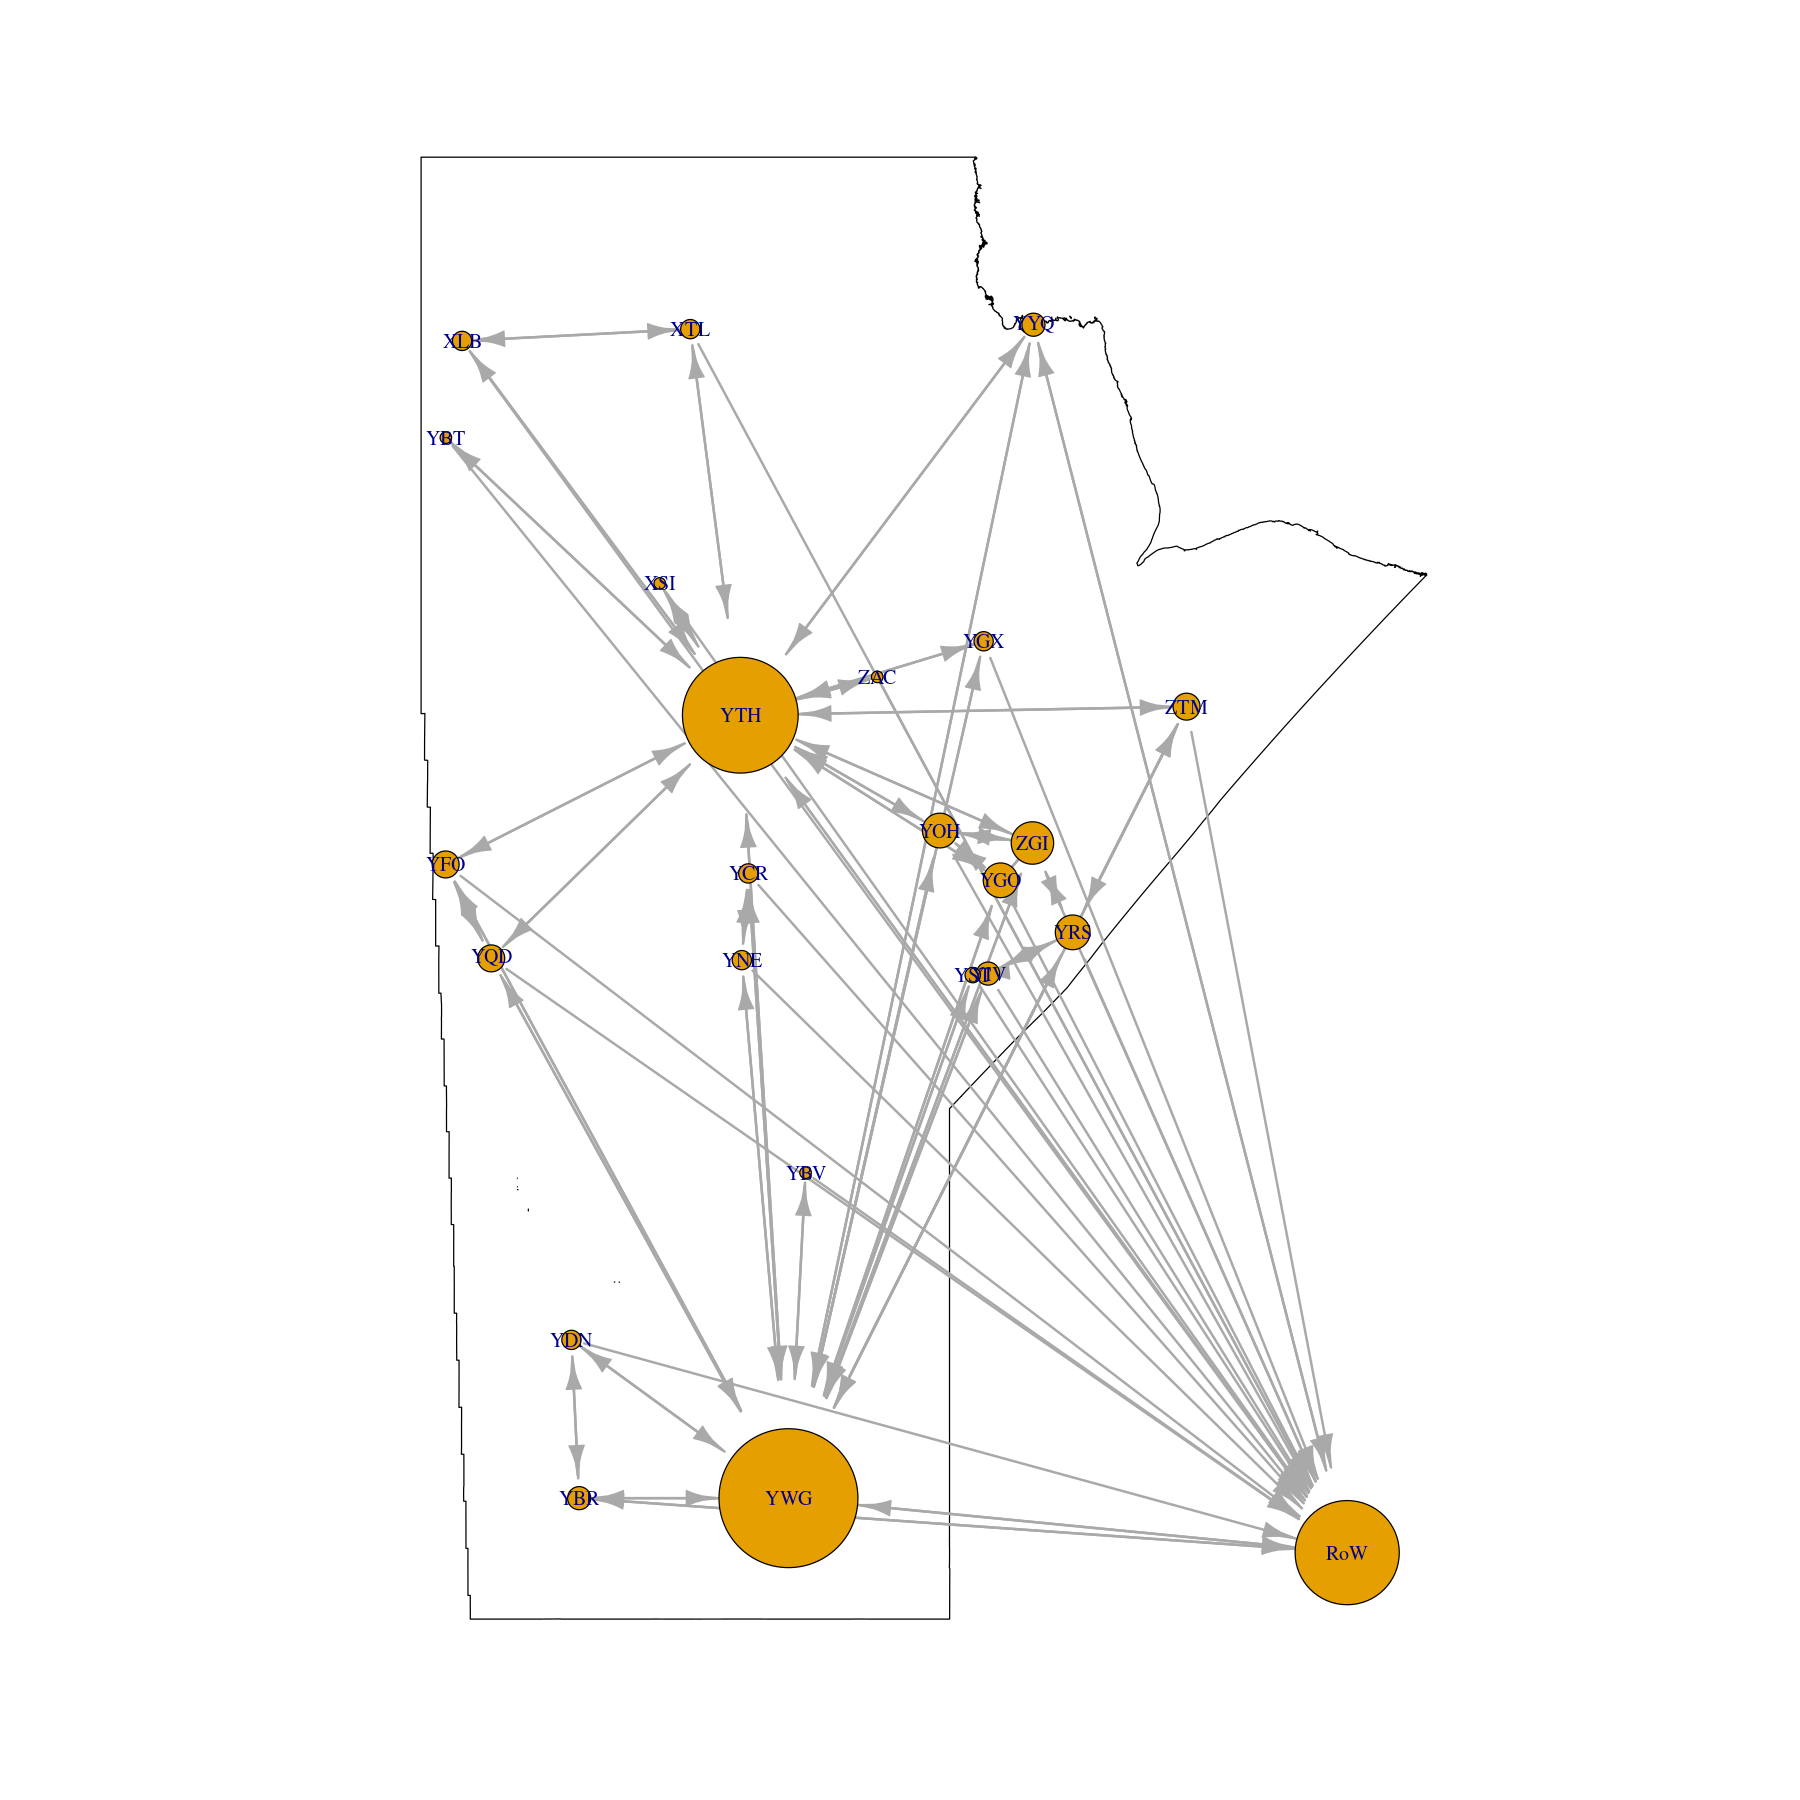

In [66]:
options(repr.plot.width=15, repr.plot.height=15)
edge_widths = 2*sigmoid(E(G)$vol, 0.1)

plot(MB)
V(G)$size = degree(G)*5
plot(G, add = TRUE, rescale = FALSE, 
     edge.width = edge_widths, type = "b",
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

Well, after all this, I am not convinced we achieved between than we had done above but just a linear scaling. So when we want a a good plot, we'll come back to that solution.

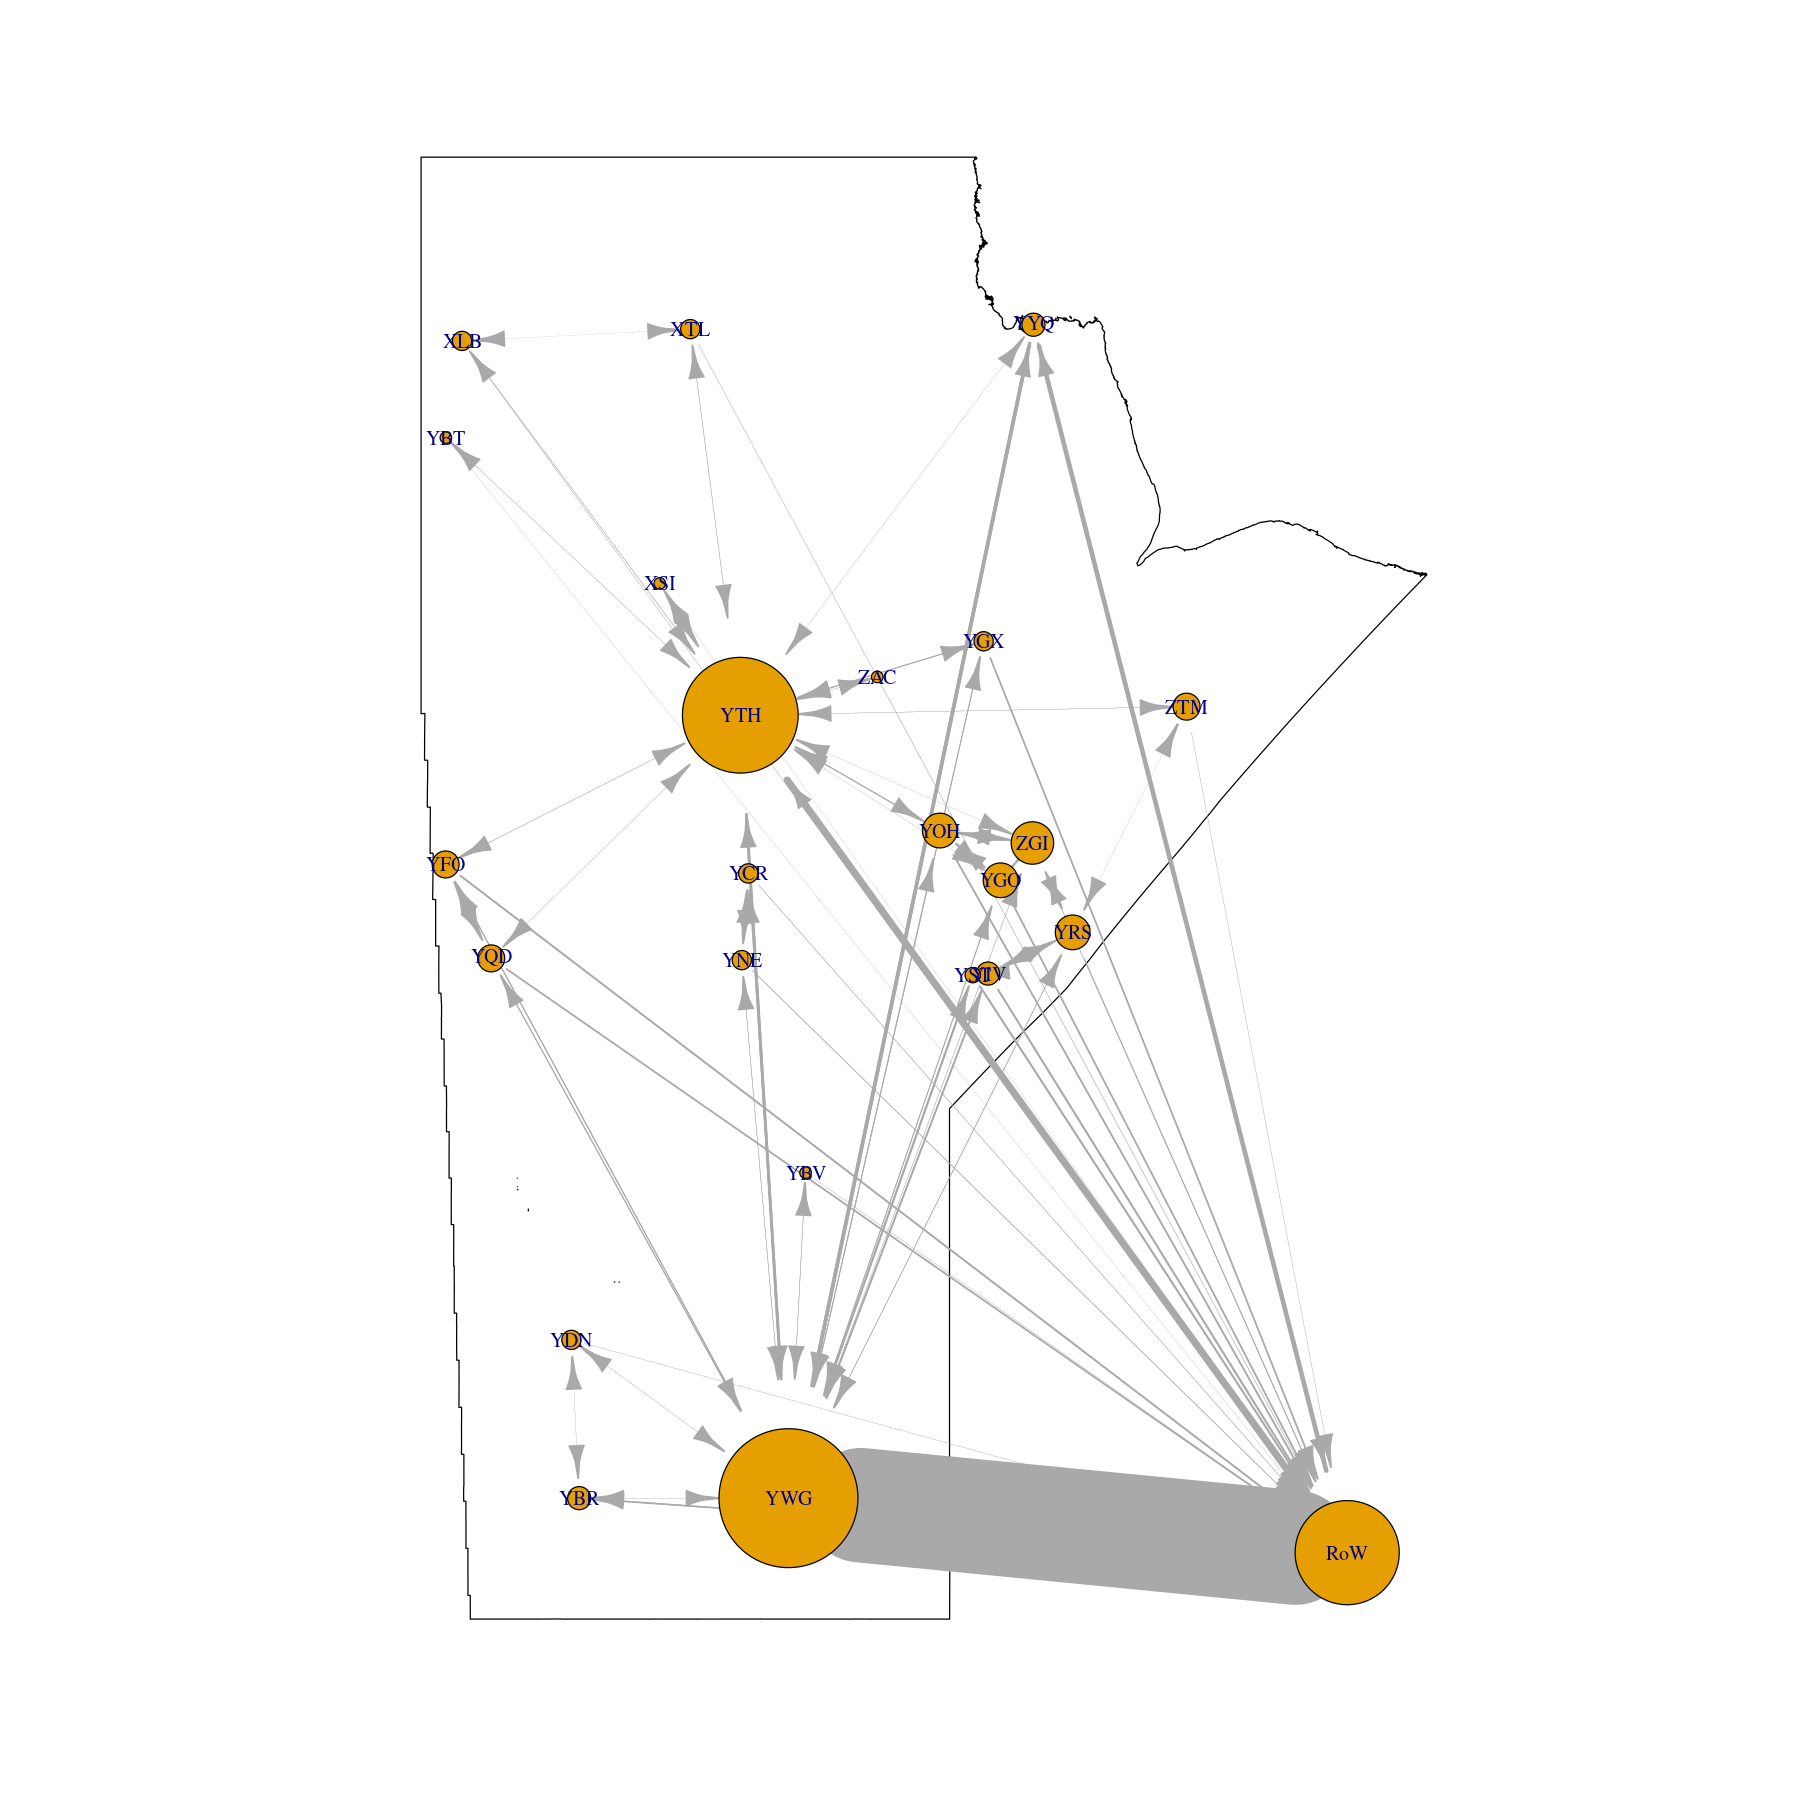

In [67]:
plot(MB)
V(G)$size = degree(G)*5
plot(G, add = TRUE, rescale = FALSE, edge.width = E(G)$vol*0.0005,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

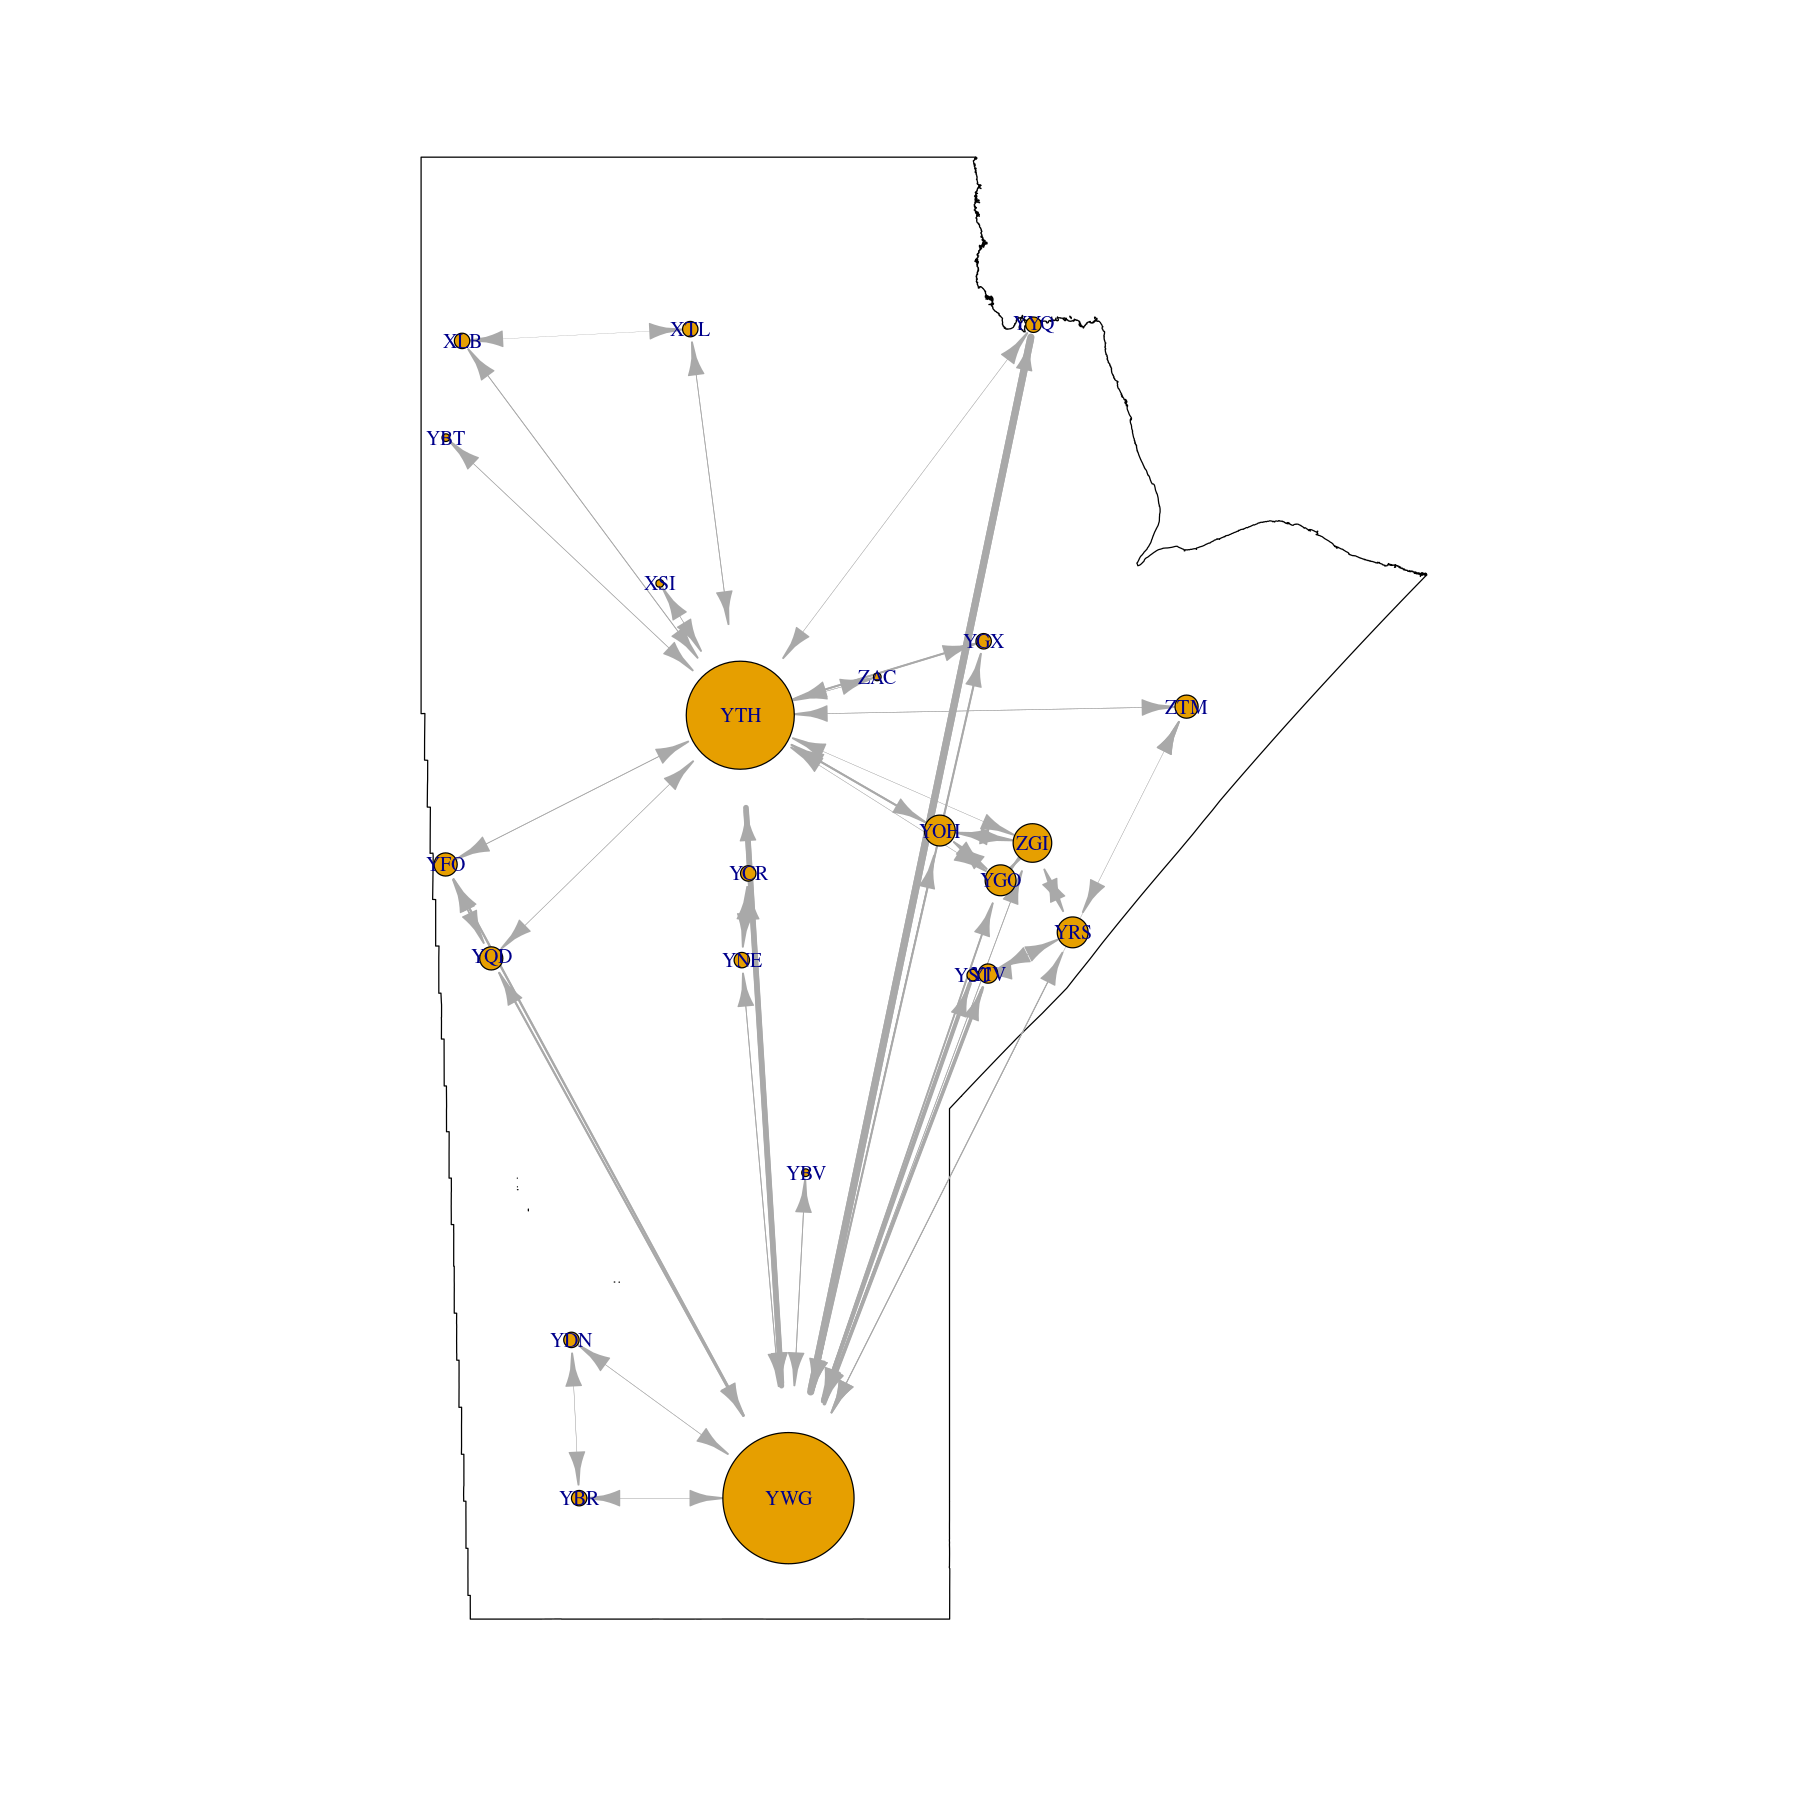

In [22]:
plot(MB)
V(G_MB)$size = degree(G_MB)*5
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

## Eccentricities and related measures

In [68]:
distances(G_MB)

XLB XSI XTL YBR YBT YBV YCR YDN YFO YGO ⋯ YOH YQD YRS YST YTH YWG YYQ ZAC
XLB 0   2   1   3   2   3   3   3   2   2   ⋯ 2   2   3   3   1   2   2   2  
XSI 2   0   2   3   2   3   3   3   2   2   ⋯ 2   2   3   3   1   2   2   2  
XTL 1   2   0   3   2   3   3   3   2   2   ⋯ 2   2   3   3   1   2   2   2  
YBR 3   3   3   0   3   2   2   1   2   2   ⋯ 2   2   2   2   2   1   2   3  
YBT 2   2   2   3   0   3   3   3   2   2   ⋯ 2   2   3   3   1   2   2   2  
YBV 3   3   3   2   3   0   2   2   2   2   ⋯ 2   2   2   2   2   1   2   3  
YCR 3   3   3   2   3   2   0   2   2   2   ⋯ 2   2   2   2   2   1   2   3  
YDN 3   3   3   1   3   2   2   0   2   2   ⋯ 2   2   2   2   2   1   2   3  
YFO 2   2   2   2   2   2   2   2   0   2   ⋯ 2   1   2   2   1   1   2   2  
YGO 2   2   2   2   2   2   2   2   2   0   ⋯ 1   2   2   2   1   1   2   2  
YGX 2   2   2   2   2   2   2   2   2   2   ⋯ 2   2   2   2   1   1   2   2  
YIV 3   3   3   2   3   2   2   2   2   2   ⋯ 2   2   1   1   2   1   2   3  
YNE 3   3   3   2   3   2   1   2   2   2   ⋯ 2   2   2   2   2   1   2   3  
YOH 2   2   2   2   2   2   2   2   2   1   ⋯ 0   2   2   2   1   1   2   2  
YQD 2   2   2   2   2   2   2   2   1   2   ⋯ 2   0   2   2   1   1   2   2  
YRS 3   3   3   2   3   2   2   2   2   2   ⋯ 2   2   0   2   2   1   2   3  
YST 3   3   3   2   3   2   2   2   2   2   ⋯ 2   2   2   0   2   1   2   3  
YTH 1   1   1   2   1   2   2   2   1   1   ⋯ 1   1   2   2   0   1   1   1  
YWG 2   2   2   1   2   1   1   1   1   1   ⋯ 1   1   1   1   1   0   1   2  
YYQ 2   2   2   2   2   2   2   2   2   2   ⋯ 2   2   2   2   1   1   0   2  
ZAC 2   2   2   3   2   3   3   3   2   2   ⋯ 2   2   3   3   1   2   2   0  
ZGI 2   2   2   2   2   2   2   2   2   1   ⋯ 1   2   1   2   1   1   2   2  
ZTM 2   2   2   2   2   2   2   2   2   2   ⋯ 2   2   1   2   1   1   2   2  
    ZGI ZTM
XLB 2   2  
XSI 2   2  
XTL 2   2  
YBR 2   2  
YBT 2   2  
YBV 2   2  
YCR 2   2  
YDN 2   2  
YFO 2   2  
YGO 1   2  
YGX 2   2  
YIV 2   2  
YNE 2   2  
YOH 1   2  
YQD 2   2  
YRS 1   1  
YST 2   2  
YTH 1   1  
YWG 1   1  
YYQ 2   2  
ZAC 2   2  
ZGI 0   2  
ZTM 2   0

In [69]:
distances(G_MB, mode = "out")

XLB XSI XTL YBR YBT YBV YCR YDN YFO YGO ⋯ YOH YQD YRS YST YTH YWG YYQ ZAC
XLB 0   2   1   3   2   3   3   3   2   2   ⋯ 2   2   3   3   1   2   2   2  
XSI 2   0   2   3   2   3   3   3   2   2   ⋯ 2   2   3   3   1   2   2   2  
XTL 1   2   0   3   2   3   3   3   2   2   ⋯ 2   2   3   3   1   2   2   2  
YBR 3   3   3   0   3   2   2   1   2   2   ⋯ 2   2   2   2   2   1   2   3  
YBT 2   2   2   3   0   3   3   3   2   2   ⋯ 2   2   3   3   1   2   2   2  
YBV 3   3   3   2   3   0   2   2   2   2   ⋯ 2   2   2   2   2   1   2   3  
YCR 3   3   3   2   3   2   0   2   2   2   ⋯ 2   2   2   2   2   1   2   3  
YDN 3   3   3   1   3   2   2   0   2   2   ⋯ 2   2   2   2   2   1   2   3  
YFO 2   2   2   2   2   2   2   2   0   2   ⋯ 2   1   2   2   1   1   2   2  
YGO 2   2   2   2   2   2   2   2   2   0   ⋯ 1   2   2   2   1   1   2   2  
YGX 2   2   2   2   2   2   2   2   2   2   ⋯ 2   2   2   2   1   1   2   2  
YIV 3   3   3   2   3   2   2   2   2   2   ⋯ 2   2   1   2   2   1   2   3  
YNE 3   3   3   2   3   2   1   2   2   2   ⋯ 2   2   2   2   2   1   2   3  
YOH 2   2   2   2   2   2   2   2   2   1   ⋯ 0   2   2   2   1   1   2   2  
YQD 2   2   2   2   2   2   2   2   1   2   ⋯ 2   0   2   2   1   1   2   2  
YRS 3   3   3   2   3   2   2   2   2   2   ⋯ 2   2   0   2   2   1   2   3  
YST 3   3   3   2   3   2   2   2   2   2   ⋯ 2   2   2   0   2   1   2   3  
YTH 1   1   1   2   1   2   2   2   1   1   ⋯ 1   1   2   2   0   1   1   1  
YWG 2   2   2   1   2   1   1   1   1   1   ⋯ 1   1   1   1   1   0   1   2  
YYQ 2   2   2   2   2   2   2   2   2   2   ⋯ 2   2   2   2   1   1   0   2  
ZAC 2   2   2   3   2   3   3   3   2   2   ⋯ 2   2   3   3   1   2   2   0  
ZGI 2   2   2   2   2   2   2   2   2   1   ⋯ 1   2   1   2   1   1   2   2  
ZTM 2   2   2   2   2   2   2   2   2   2   ⋯ 2   2   1   2   1   1   2   2  
    ZGI ZTM
XLB 2   2  
XSI 2   2  
XTL 2   2  
YBR 2   2  
YBT 2   2  
YBV 2   2  
YCR 2   2  
YDN 2   2  
YFO 2   2  
YGO 1   2  
YGX 2   2  
YIV 2   2  
YNE 2   2  
YOH 1   2  
YQD 2   2  
YRS 1   1  
YST 2   2  
YTH 1   1  
YWG 1   1  
YYQ 2   2  
ZAC 2   2  
ZGI 0   2  
ZTM 2   0

In [70]:
eccentricity(G_MB)
eccentricity(G_MB, mode = "in")
eccentricity(G_MB, mode = "out")
writeLines("Radius (all/in/out):")
radius(G_MB)
radius(G_MB, mode = "in")
radius(G_MB, mode = "out")
writeLines("Diameter (all/in/out:")
diameter(G_MB)
max(distances(G_MB, mode = "in"))
max(distances(G_MB, mode = "out"))

XLB XSI XTL YBR YBT YBV YCR YDN YFO YGO YGX YIV YNE YOH YQD YRS YST YTH YWG YYQ 
  3   3   3   3   3   3   3   3   2   2   2   3   3   2   2   3   3   2   2   2 
ZAC ZGI ZTM 
  3   2   2

XLB XSI XTL YBR YBT YBV YCR YDN YFO YGO YGX YIV YNE YOH YQD YRS YST YTH YWG YYQ 
  3   3   3   3   3   3   3   3   2   2   2   3   3   2   2   3   3   2   2   2 
ZAC ZGI ZTM 
  3   2   2

XLB XSI XTL YBR YBT YBV YCR YDN YFO YGO YGX YIV YNE YOH YQD YRS YST YTH YWG YYQ 
  3   3   3   3   3   3   3   3   2   2   2   3   3   2   2   3   3   2   2   2 
ZAC ZGI ZTM 
  3   2   2

Radius (all/in/out):


[1] 2

[1] 2

[1] 2

Diameter (all/in/out:


[1] 3

[1] 3

[1] 3

## Central points, centre, periphery
For simplicity, I only show the out-degree case. And just to show how easily it's done: let's colour the vertices in the centre red and those in the periphery blue.

Central points:


[1] "YFO" "YGO" "YGX" "YOH" "YQD" "YTH" "YWG" "YYQ" "ZGI" "ZTM"

Periphery:


[1] "XLB" "XSI" "XTL" "YBR" "YBT" "YBV" "YCR" "YDN" "YIV" "YNE" "YRS" "YST"
[13] "ZAC"

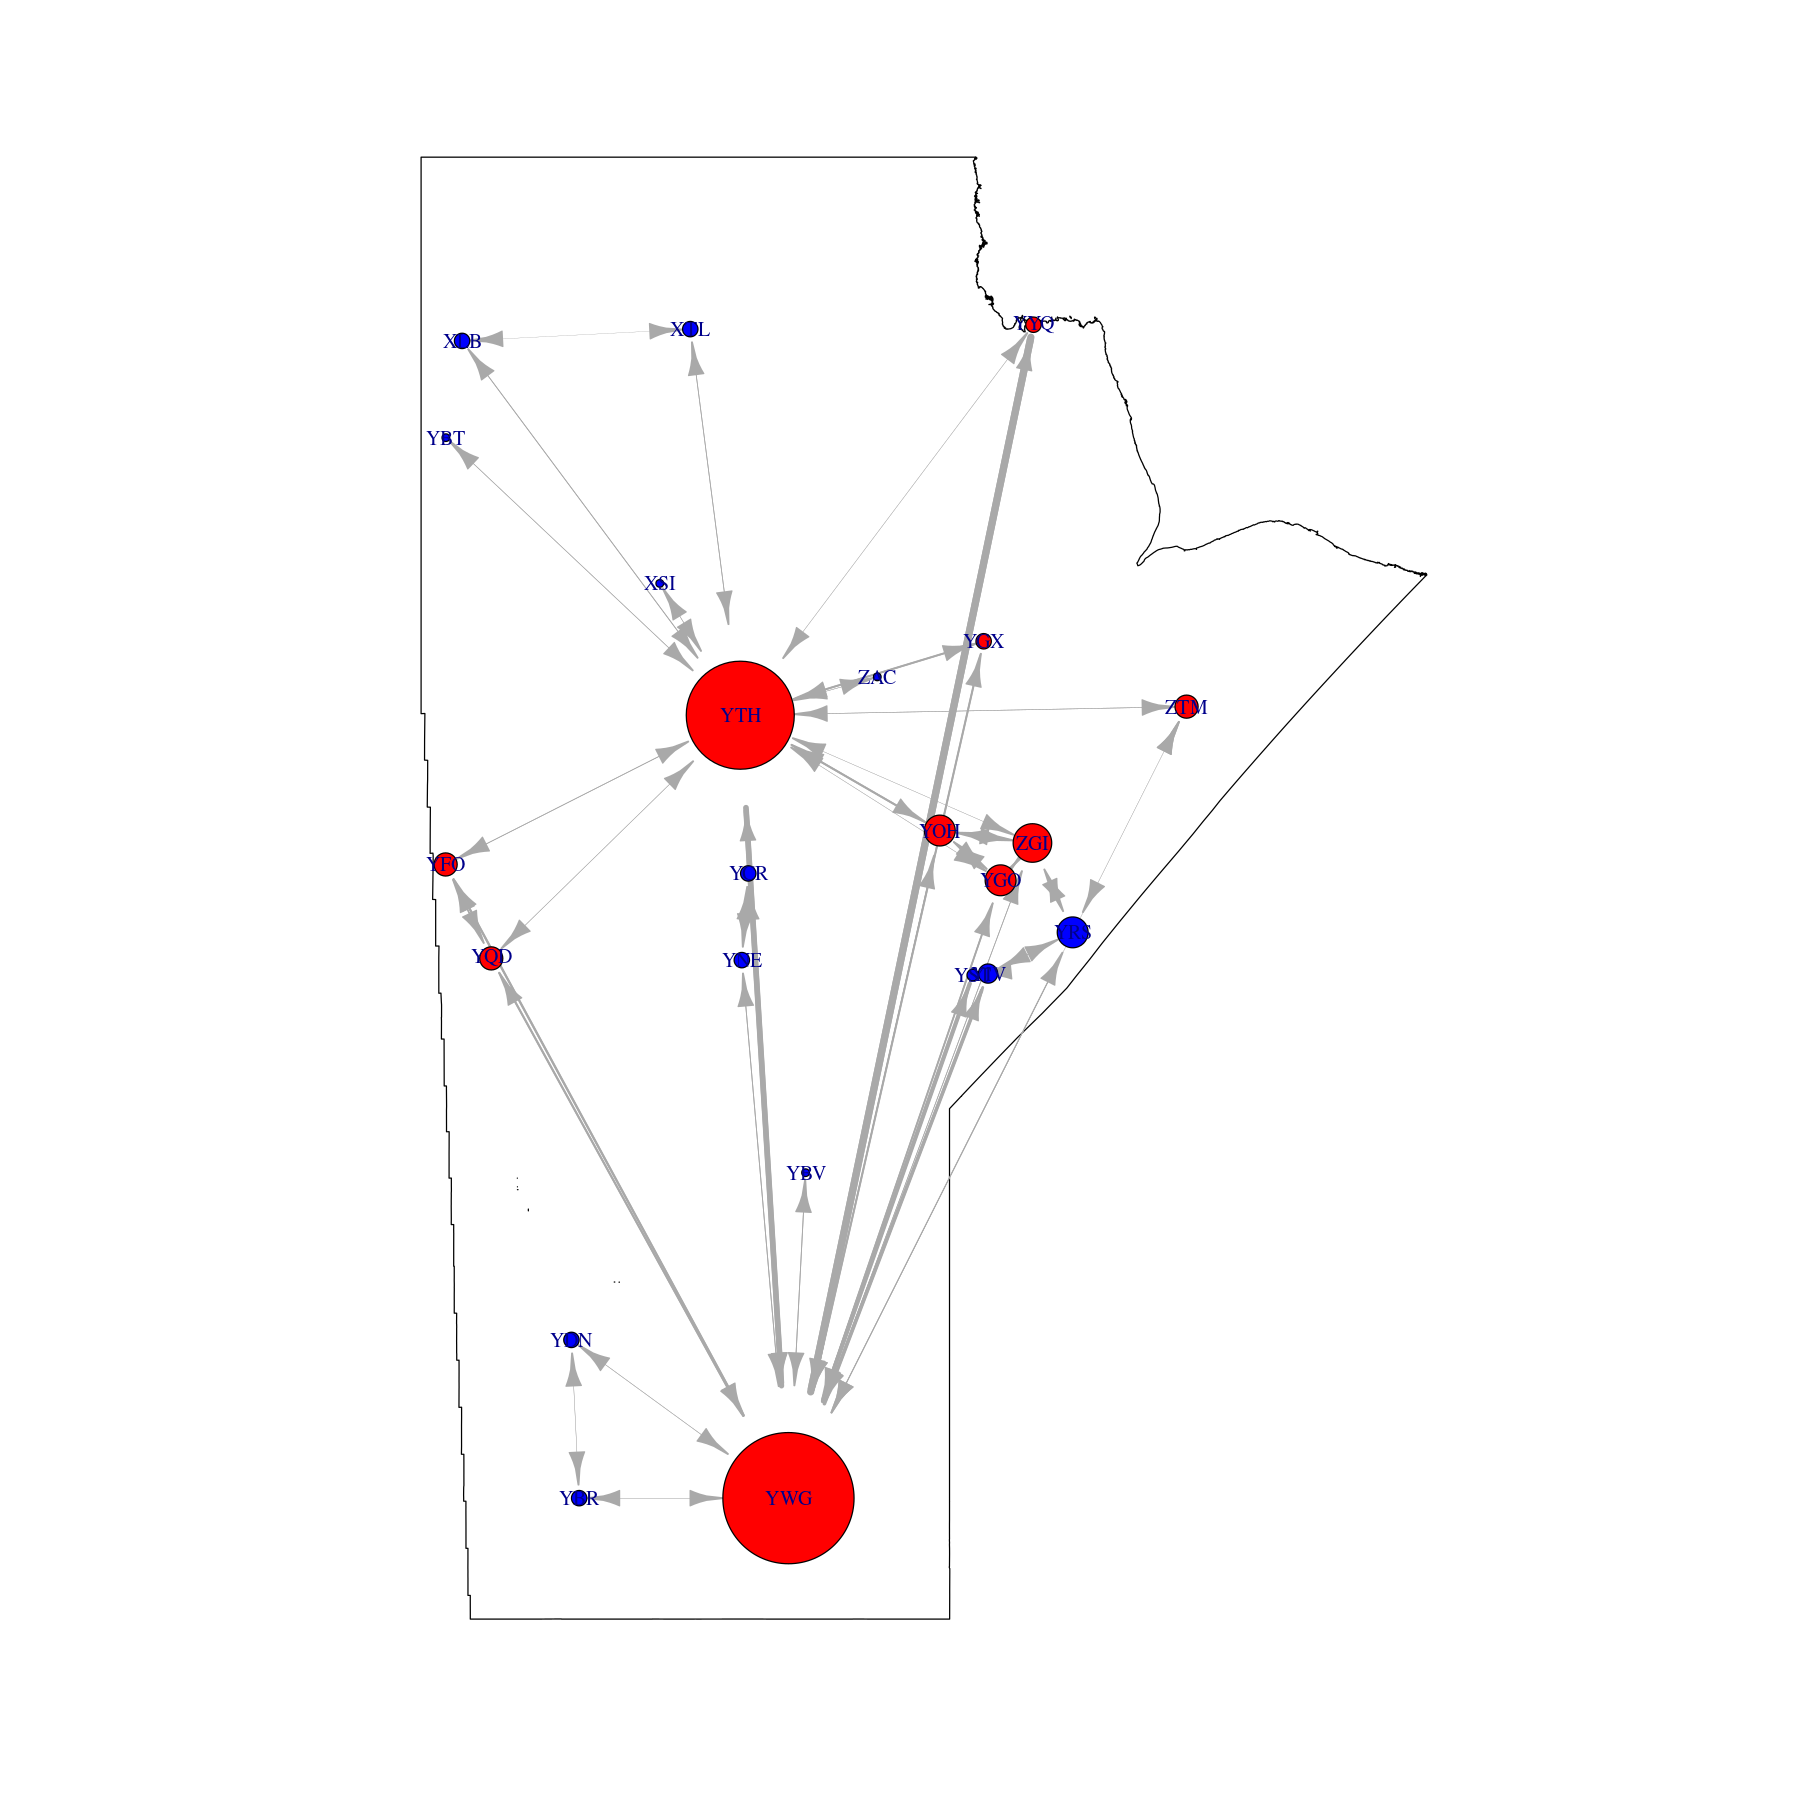

In [71]:
e_out = eccentricity(G_MB, mode = "out")
writeLines("Central points:")
V(G_MB)[which(e_out == min(e_out))]$name
V(G_MB)[which(e_out == min(e_out))]$color = "red"
writeLines("Periphery:")
V(G_MB)[which(e_out == max(e_out))]$name
V(G_MB)[which(e_out == max(e_out))]$color = "blue"

plot(MB)
V(G_MB)$size = degree(G_MB)*5
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

## Girth
Recall that `girth` in `igraph` assumes the graph is undirected.

In [27]:
girth(G)
girth(G_MB)

$girth
[1] 3

$circle
+ 3/24 vertices, named, from d7c1109:
[1] XLB RoW XTL


$girth
[1] 3

$circle
+ 3/23 vertices, named, from 47b8956:
[1] XTL XLB YTH


## Density
What fraction of possible arcs/edges are present?

In [28]:
edge_density(G)
edge_density(G_MB)

[1] 0.1956522

[1] 0.1600791

# Connectedness and related
## Connectedness

In [29]:
is.connected(G_MB, "weak")
is.connected(G_MB, "strong")

[1] TRUE

[1] TRUE

So there is a single strongly connected component.
## Articulation points
The function assumes the graph is undirected, even in the directed case.

In [72]:
articulation_points(G_MB)

+ 2/23 vertices, named, from 15b28d5:
[1] YTH YWG

So removing Winnipeg or Thompson disconnects the graph.

[1] FALSE

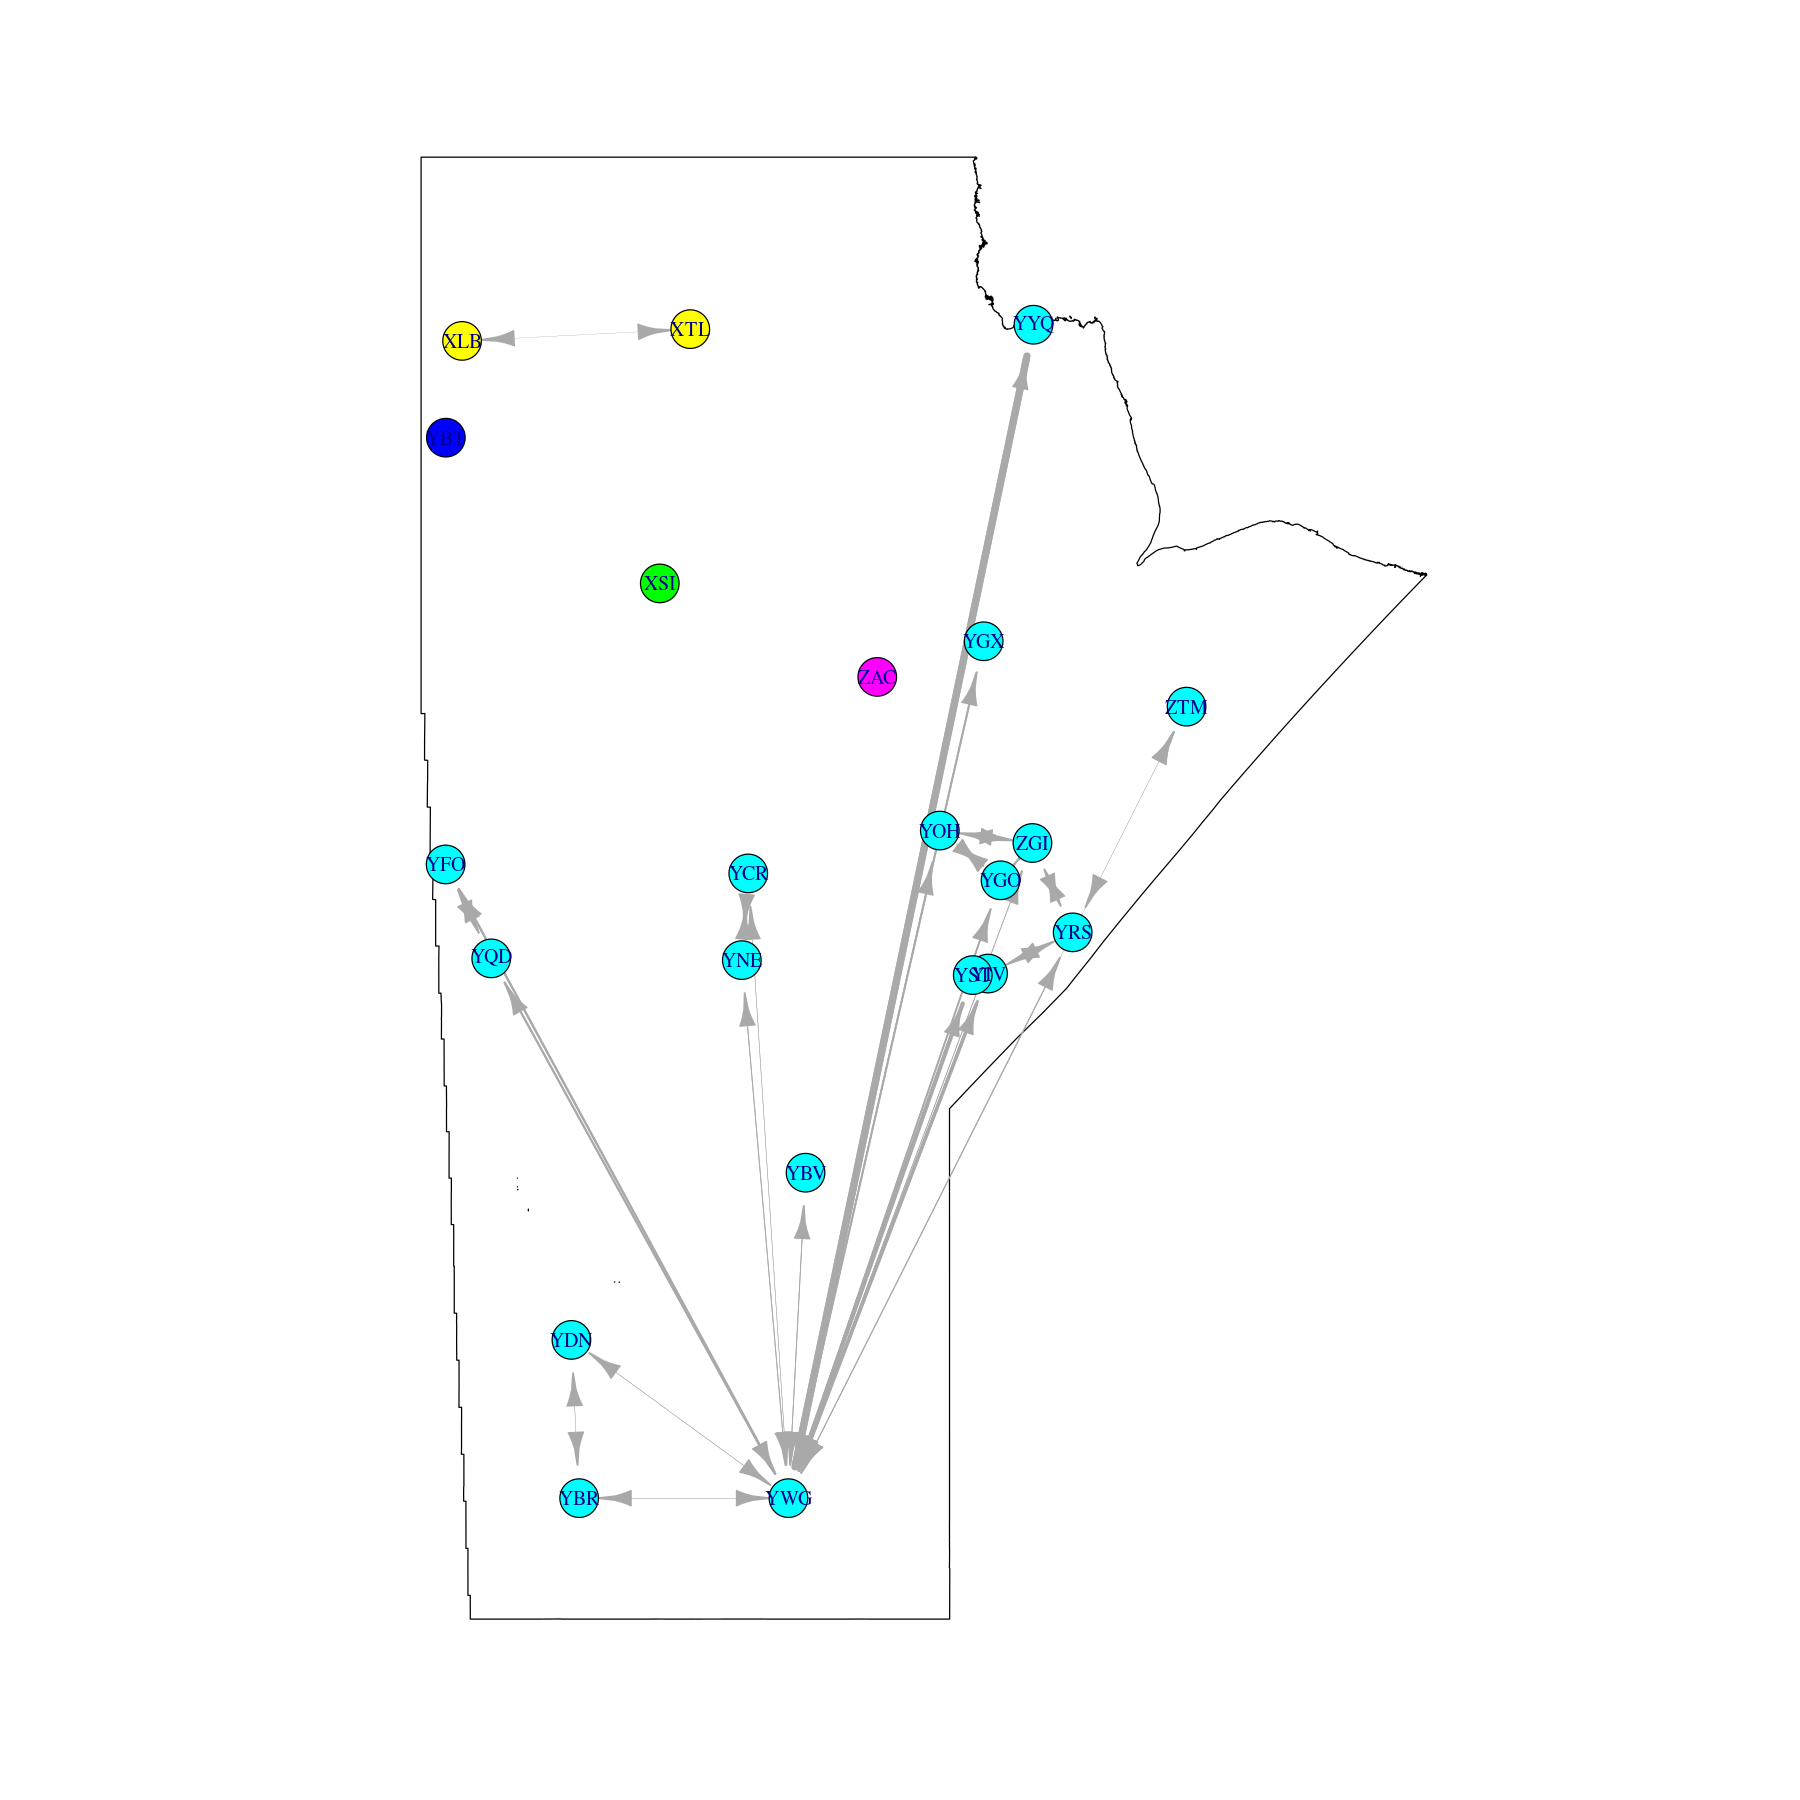

In [31]:
G_disconnected = induced_subgraph(G_MB, V(G_MB)$name[V(G_MB)$name != "YTH"])
is_connected(G_disconnected)

comps <- components(G_disconnected)$membership
colbar <- rainbow(max(comps)+1)
V(G_disconnected)$color <- colbar[comps+1]

plot(MB)
V(G_disconnected)$size = rep(50,length(V(G_disconnected)))
plot(G_disconnected, add = TRUE, rescale = FALSE, 
     edge.width = E(G_disconnected)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

# Cliques

Warning message in largest_cliques(G_MB):
“At core/cliques/maximal_cliques_template.h:268 : Edge directions are ignored for maximal clique calculation.”


[[1]]
+ 5/23 vertices, named, from 15b28d5:
[1] ZGI YGO YWG YTH YOH


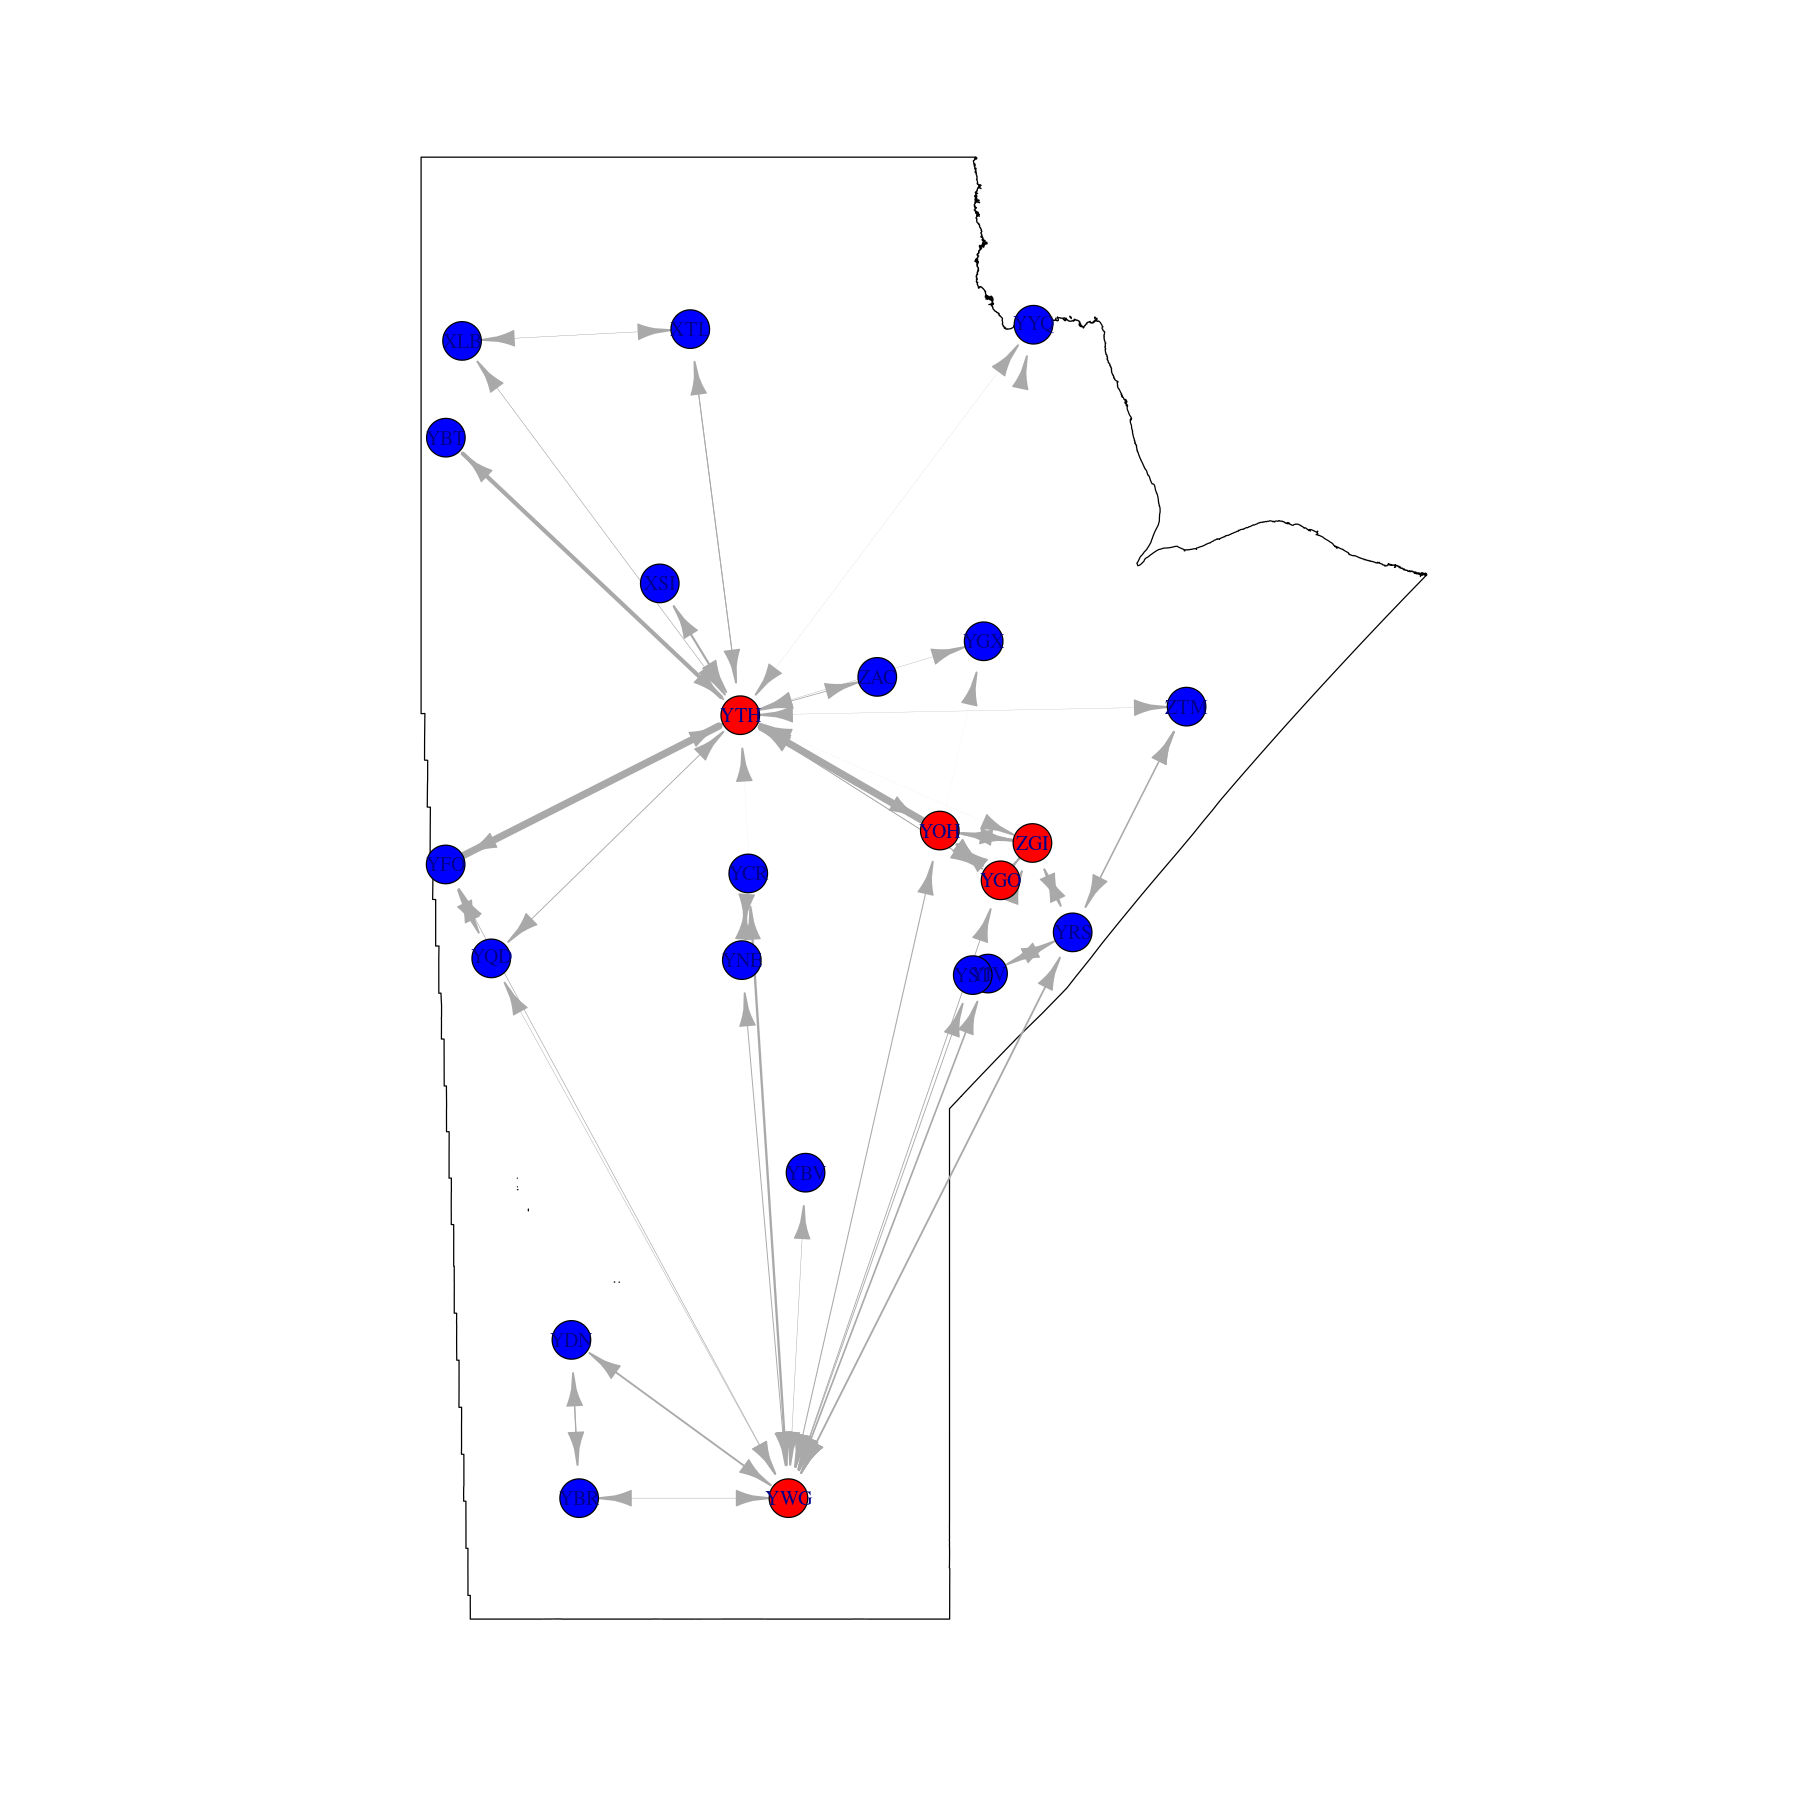

In [73]:
lc = largest_cliques(G_MB)
lc
vert_largest_clique = lc[[1]]

V(G_MB)$color = "blue"
V(G_MB)[vert_largest_clique]$color = "red"

plot(MB)
V(G_MB)$size = rep(50,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_disconnected)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)

# Centrality
## Degree-centrality

In [33]:
degree(G_MB, mode = "out")
degree(G_MB, mode = "in")
degree(G_MB)
distrib_outdegree = degree_distribution(G, mode = "out")
distrib_indegree = degree_distribution(G, mode = "in")
distrib_degree = degree_distribution(G)

XLB XSI XTL YBR YBT YBV YCR YDN YFO YGO YGX YIV YNE YOH YQD YRS YST YTH YWG YYQ 
  2   1   2   2   1   1   2   2   3   4   2   2   2   4   3   4   2  14  17   2 
ZAC ZGI ZTM 
  1   5   3

XLB XSI XTL YBR YBT YBV YCR YDN YFO YGO YGX YIV YNE YOH YQD YRS YST YTH YWG YYQ 
  2   1   2   2   1   1   2   2   3   4   2   3   2   4   3   4   1  14  17   2 
ZAC ZGI ZTM 
  1   5   3

XLB XSI XTL YBR YBT YBV YCR YDN YFO YGO YGX YIV YNE YOH YQD YRS YST YTH YWG YYQ 
  4   2   4   4   2   2   4   4   6   8   4   5   4   8   6   8   3  28  34   4 
ZAC ZGI ZTM 
  2  10   6

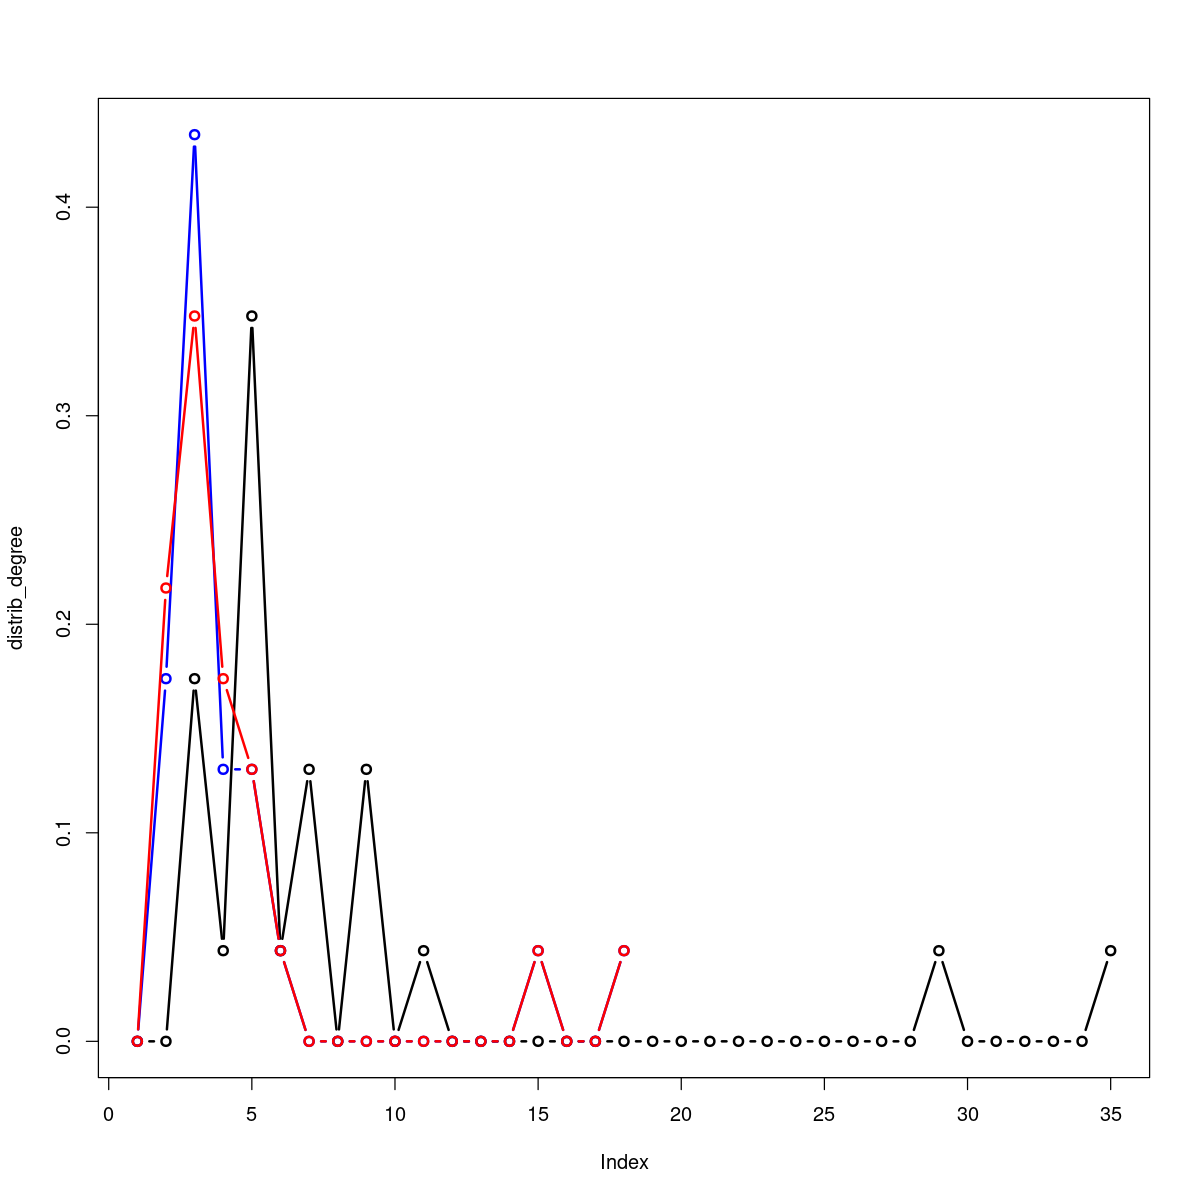

In [34]:
options(repr.plot.width=10, repr.plot.height=10)

distrib_outdegree = degree_distribution(G_MB, mode = "out")
distrib_indegree = degree_distribution(G_MB, mode = "in")
distrib_degree = degree_distribution(G_MB)

y_max = max(max(distrib_indegree, distrib_outdegree), distrib_degree)
plot(distrib_degree, type = "b", lwd = 2, col = "black", ylim = c(0, y_max))
points(distrib_outdegree, type = "b", lwd = 2, col = "blue")
points(distrib_indegree, type = "b", lwd = 2, col = "red")

# K-nearest neighbours
For info, the return values of the function `knn` are
- `knn`: A numeric vector giving the average nearest neighbor degree for all vertices in vids.
- `knnk`: A numeric vector, its length is the maximum (total) vertex degree in the graph. The first element is the average nearest neighbor degree of vertices with degree one, etc.

In [35]:
knn(G_MB, mode = "all")
knn(G_MB, mode = "in")
knn(G_MB, mode = "out")

$knn
      XLB       XSI       XTL       YBR       YBT       YBV       YCR       YDN 
16.000000 28.000000 16.000000 19.000000 28.000000 34.000000 19.000000 19.000000 
      YFO       YGO       YGX       YIV       YNE       YOH       YQD       YRS 
22.666667 20.000000 31.000000 17.400000 19.000000 20.000000 22.666667 13.750000 
      YST       YTH       YWG       YYQ       ZAC       ZGI       ZTM 
24.333333  7.142857  6.705882 31.000000 28.000000 17.200000 23.333333 

$knnk
 [1]       NaN 29.500000 24.333333 21.250000 17.400000 22.888889       NaN
 [8] 17.916667       NaN 17.200000       NaN       NaN       NaN       NaN
[15]       NaN       NaN       NaN       NaN       NaN       NaN       NaN
[22]       NaN       NaN       NaN       NaN       NaN       NaN  7.142857
[29]       NaN       NaN       NaN       NaN       NaN  6.705882

$knn
      XLB       XSI       XTL       YBR       YBT       YBV       YCR       YDN 
16.000000 28.000000 16.000000 19.000000 28.000000 34.000000 19.000000 19.000000 
      YFO       YGO       YGX       YIV       YNE       YOH       YQD       YRS 
22.666667 20.000000 31.000000 15.000000 19.000000 20.000000 22.666667 13.750000 
      YST       YTH       YWG       YYQ       ZAC       ZGI       ZTM 
34.000000  7.142857  6.705882 31.000000 28.000000 17.200000 23.333333 

$knnk
 [1] 30.400000 21.250000 20.916667 17.916667 17.200000       NaN       NaN
 [8]       NaN       NaN       NaN       NaN       NaN       NaN  7.142857
[15]       NaN       NaN  6.705882

$knn
      XLB       XSI       XTL       YBR       YBT       YBV       YCR       YDN 
16.000000 28.000000 16.000000 19.000000 28.000000 34.000000 19.000000 19.000000 
      YFO       YGO       YGX       YIV       YNE       YOH       YQD       YRS 
22.666667 20.000000 31.000000 21.000000 19.000000 20.000000 22.666667 13.750000 
      YST       YTH       YWG       YYQ       ZAC       ZGI       ZTM 
19.500000  7.142857  6.705882 31.000000 28.000000 17.200000 23.333333 

$knnk
 [1] 29.500000 21.050000 22.888889 17.916667 17.200000       NaN       NaN
 [8]       NaN       NaN       NaN       NaN       NaN       NaN  7.142857
[15]       NaN       NaN  6.705882

Let us plot the values in the graph, say, for the in-knn.

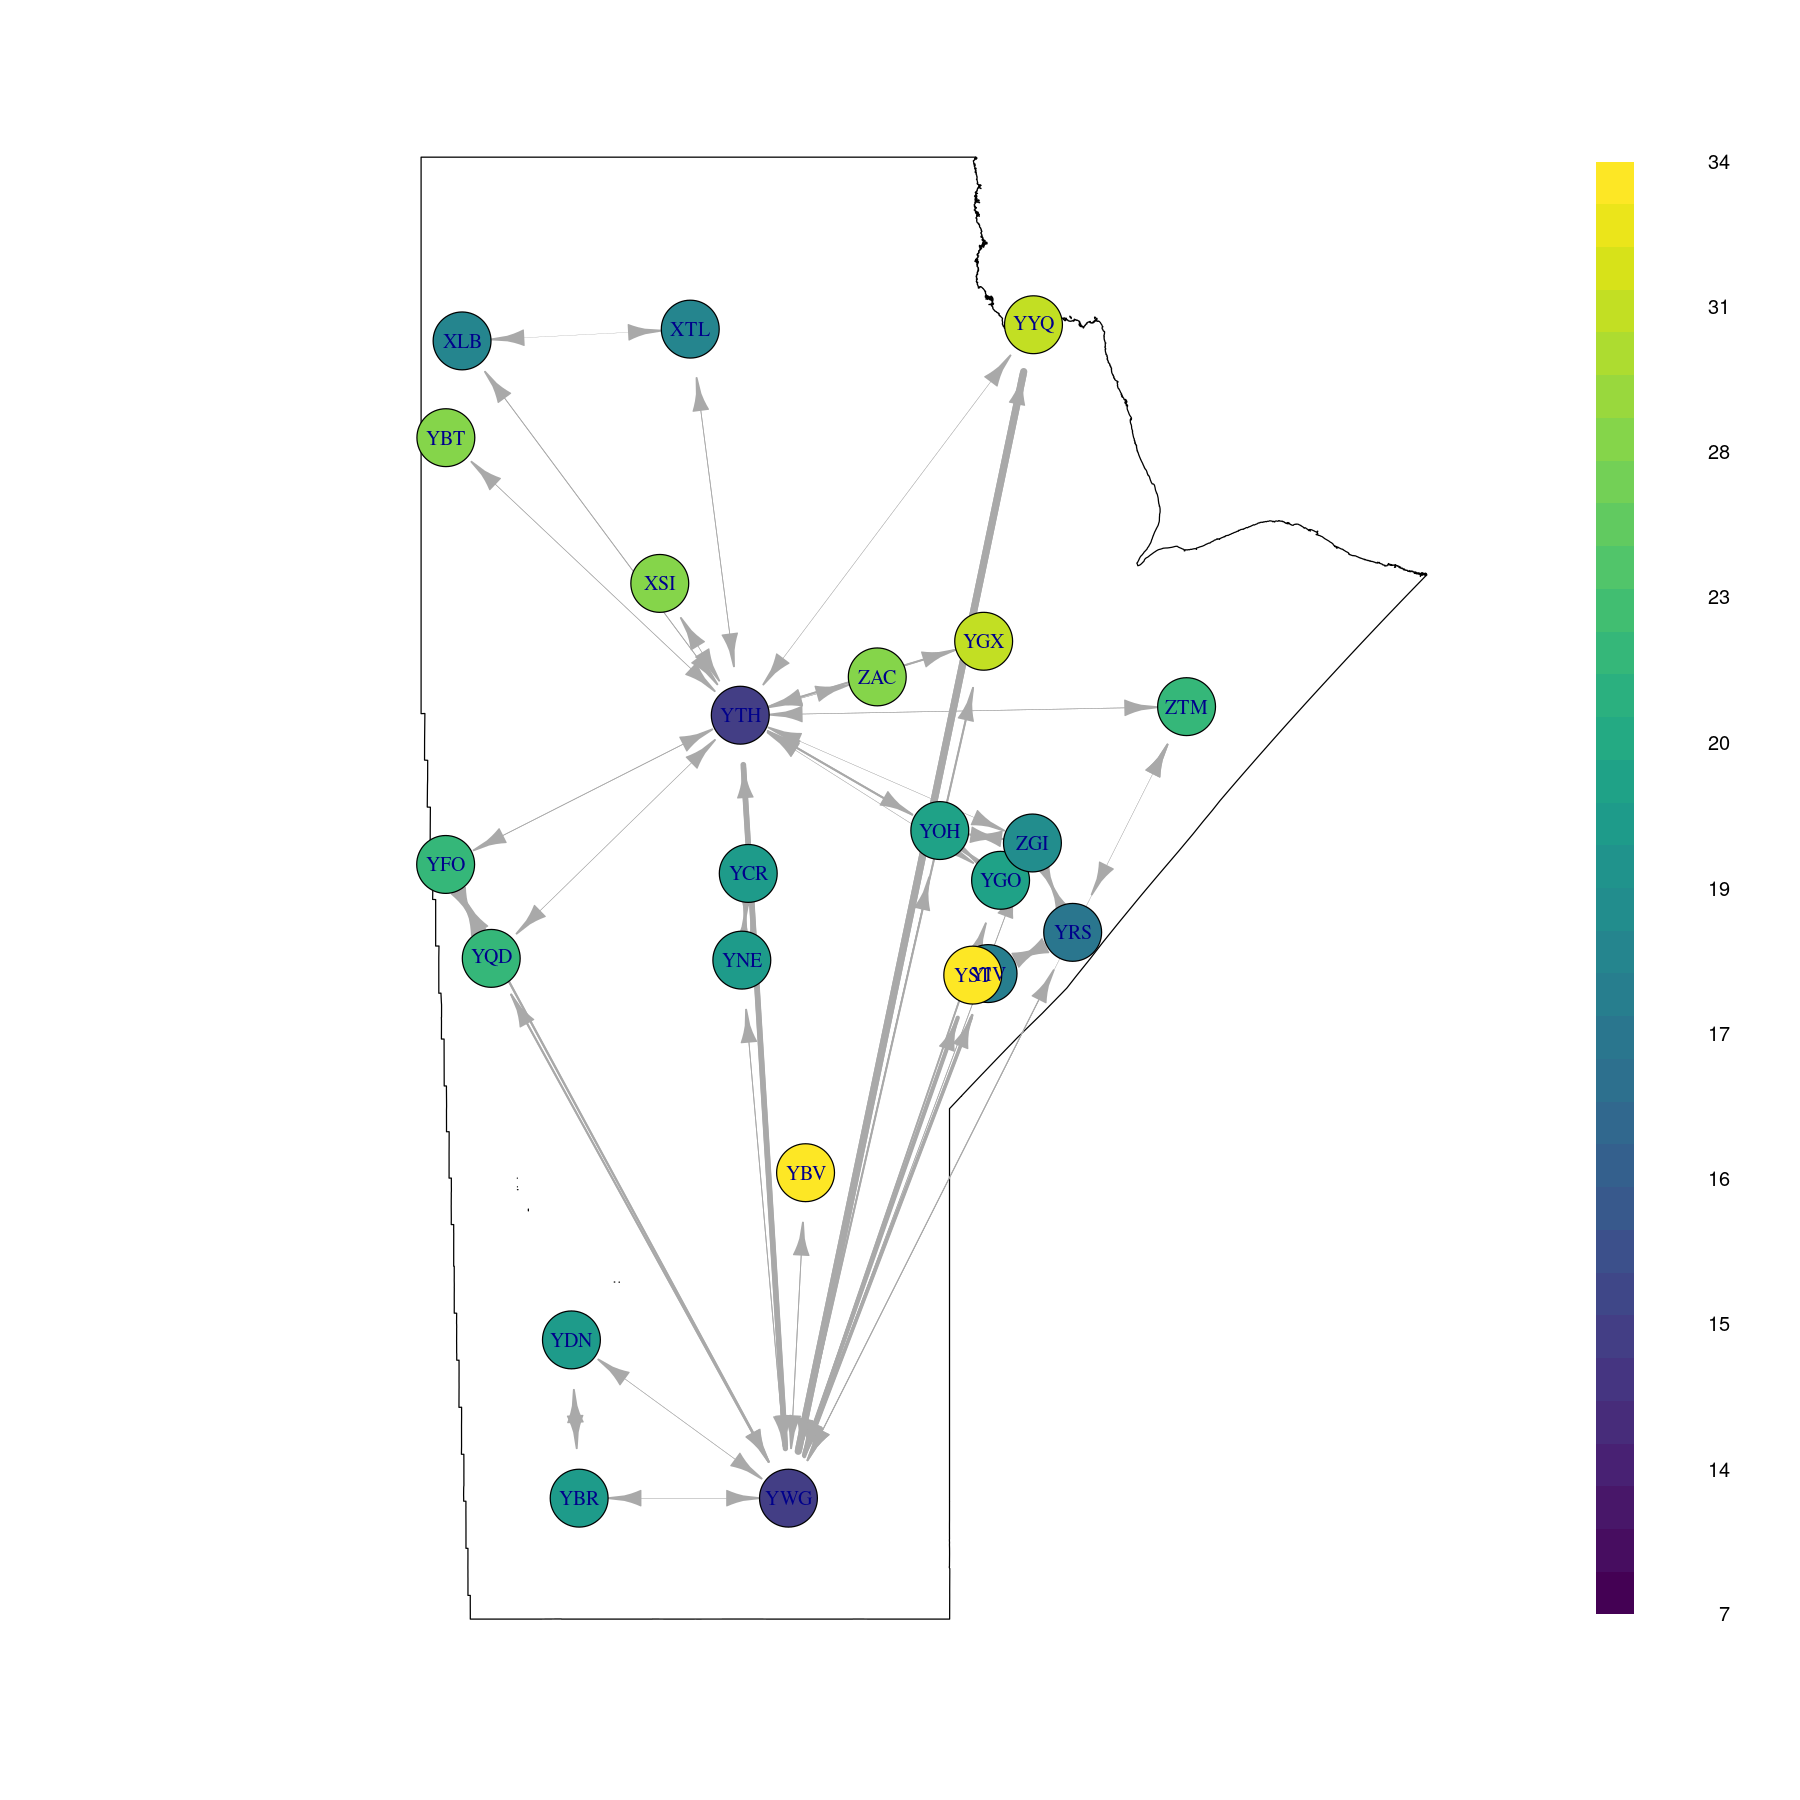

In [74]:
options(repr.plot.width=15, repr.plot.height=15)

knn_in = knn(G_MB, mode = "in")$knn
knn_in_bar = sort(unique(round(knn_in)))
colbar <- viridis::viridis(max(ceiling(knn_in)))
V(G_MB)$color <- colbar[round(knn_in)]

plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)
DescTools::ColorLegend(x = "right", col = colbar, 
                       width = 0.5, inset = 0.1,
                       labels = sprintf("%d", knn_in_bar))

# Coreness

In [75]:
coreness(G_MB, "all")
coreness(G_MB, "in")
coreness(G_MB, "out")

XLB XSI XTL YBR YBT YBV YCR YDN YFO YGO YGX YIV YNE YOH YQD YRS YST YTH YWG YYQ 
  4   2   4   4   2   2   4   4   6   8   4   4   4   8   6   6   3   8   8   4 
ZAC ZGI ZTM 
  2   8   6

XLB XSI XTL YBR YBT YBV YCR YDN YFO YGO YGX YIV YNE YOH YQD YRS YST YTH YWG YYQ 
  2   1   2   2   1   1   2   2   3   4   2   2   2   4   3   3   1   4   4   2 
ZAC ZGI ZTM 
  1   4   3

XLB XSI XTL YBR YBT YBV YCR YDN YFO YGO YGX YIV YNE YOH YQD YRS YST YTH YWG YYQ 
  2   1   2   2   1   1   2   2   3   4   2   2   2   4   3   3   2   4   4   2 
ZAC ZGI ZTM 
  1   4   3

Let us look at the out-coreness, for instance, and colour the vertices as a function of that.

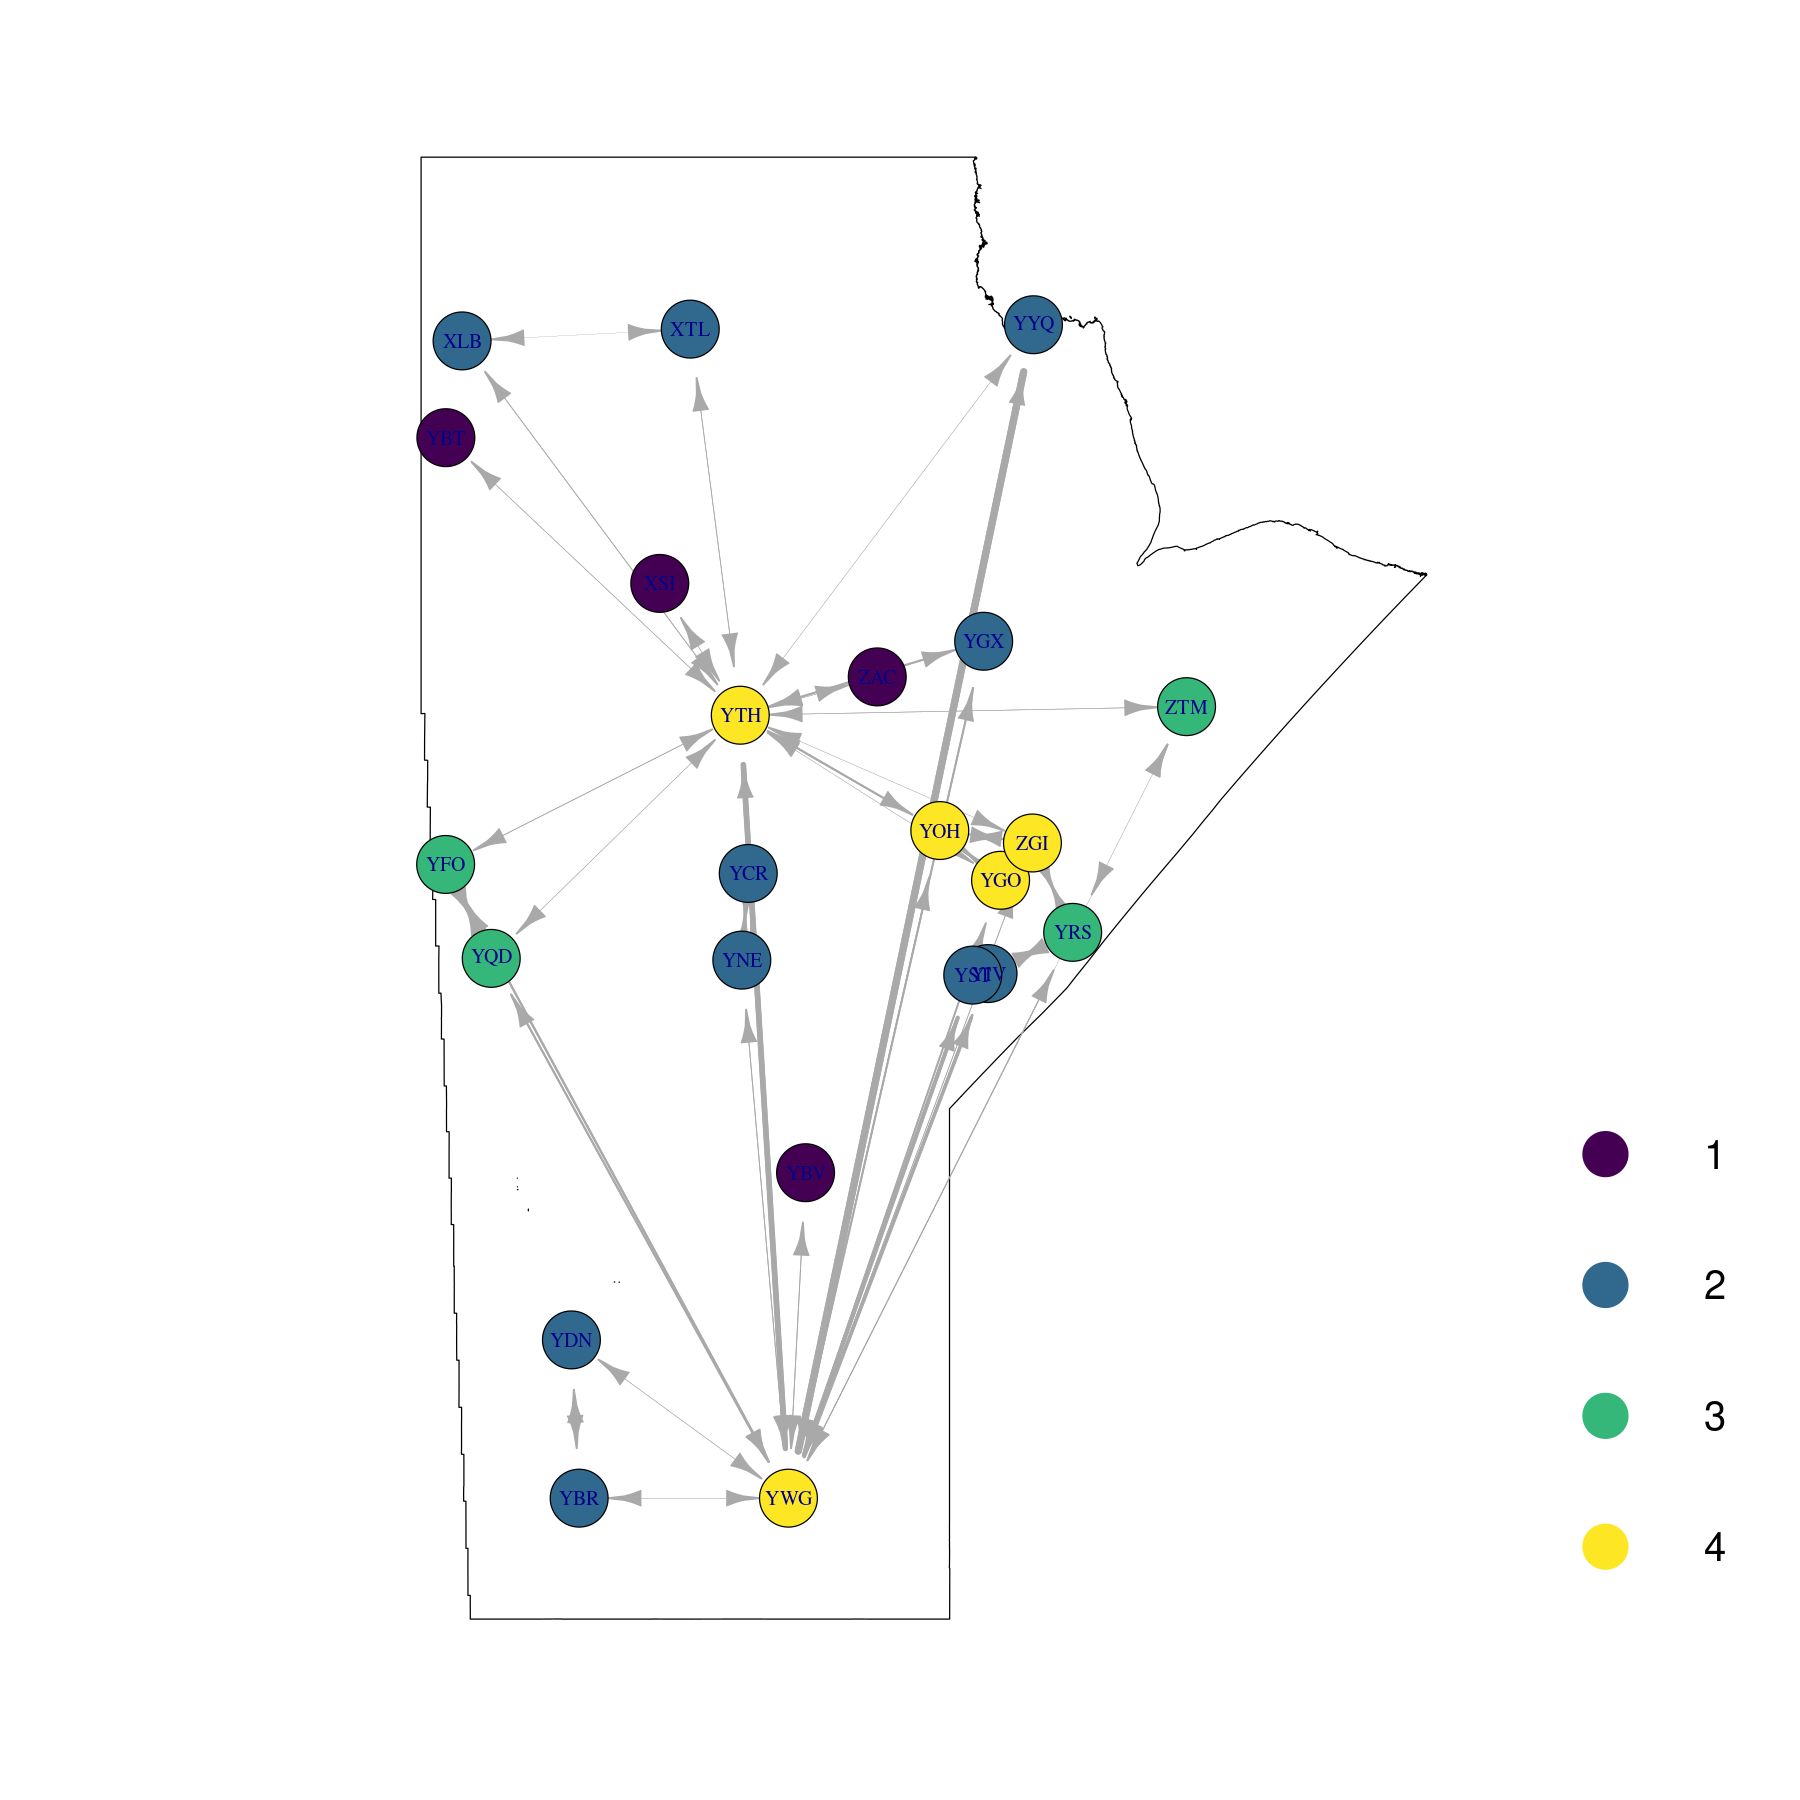

In [38]:
cores = coreness(G_MB, "out")
colbar <- viridis::viridis(max(cores))
V(G_MB)$color <- colbar[cores]

plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
    edge.arrow.size = 0.5, edge.arrow.width = 0.75)
legend("bottomright", 
       legend = sprintf("%d", sort(unique(cores))),
       pch = rep(19, length(unique(cores))),
       pt.cex = rep(5, length(unique(cores))),
       cex = 2,
       box.lty=0,
       col = colbar[sort(unique(cores))])

# Betweenness

In [39]:
betweenness(G)
betweenness(G_MB)

RoW        XLB        XSI        XTL        YBR        YBT        YBV 
 63.416667   0.000000   0.000000   0.000000   2.166667   0.000000   0.000000 
       YCR        YDN        YFO        YGO        YGX        YIV        YNE 
  0.000000   0.000000   0.000000   0.000000   0.000000   0.500000   0.000000 
       YOH        YQD        YRS        YST        YTH        YWG        YYQ 
  0.000000   0.000000   2.666667   0.000000 191.916667 250.166667   0.000000 
       ZAC        ZGI        ZTM 
  0.000000   5.083333   3.083333

XLB        XSI        XTL        YBR        YBT        YBV        YCR 
  0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000 
       YDN        YFO        YGO        YGX        YIV        YNE        YOH 
  0.000000   0.000000   0.000000   0.000000   0.500000   0.000000   0.000000 
       YQD        YRS        YST        YTH        YWG        YYQ        ZAC 
  0.000000   2.666667   0.000000 211.666667 280.166667   0.000000   0.000000 
       ZGI        ZTM 
  6.000000   4.000000

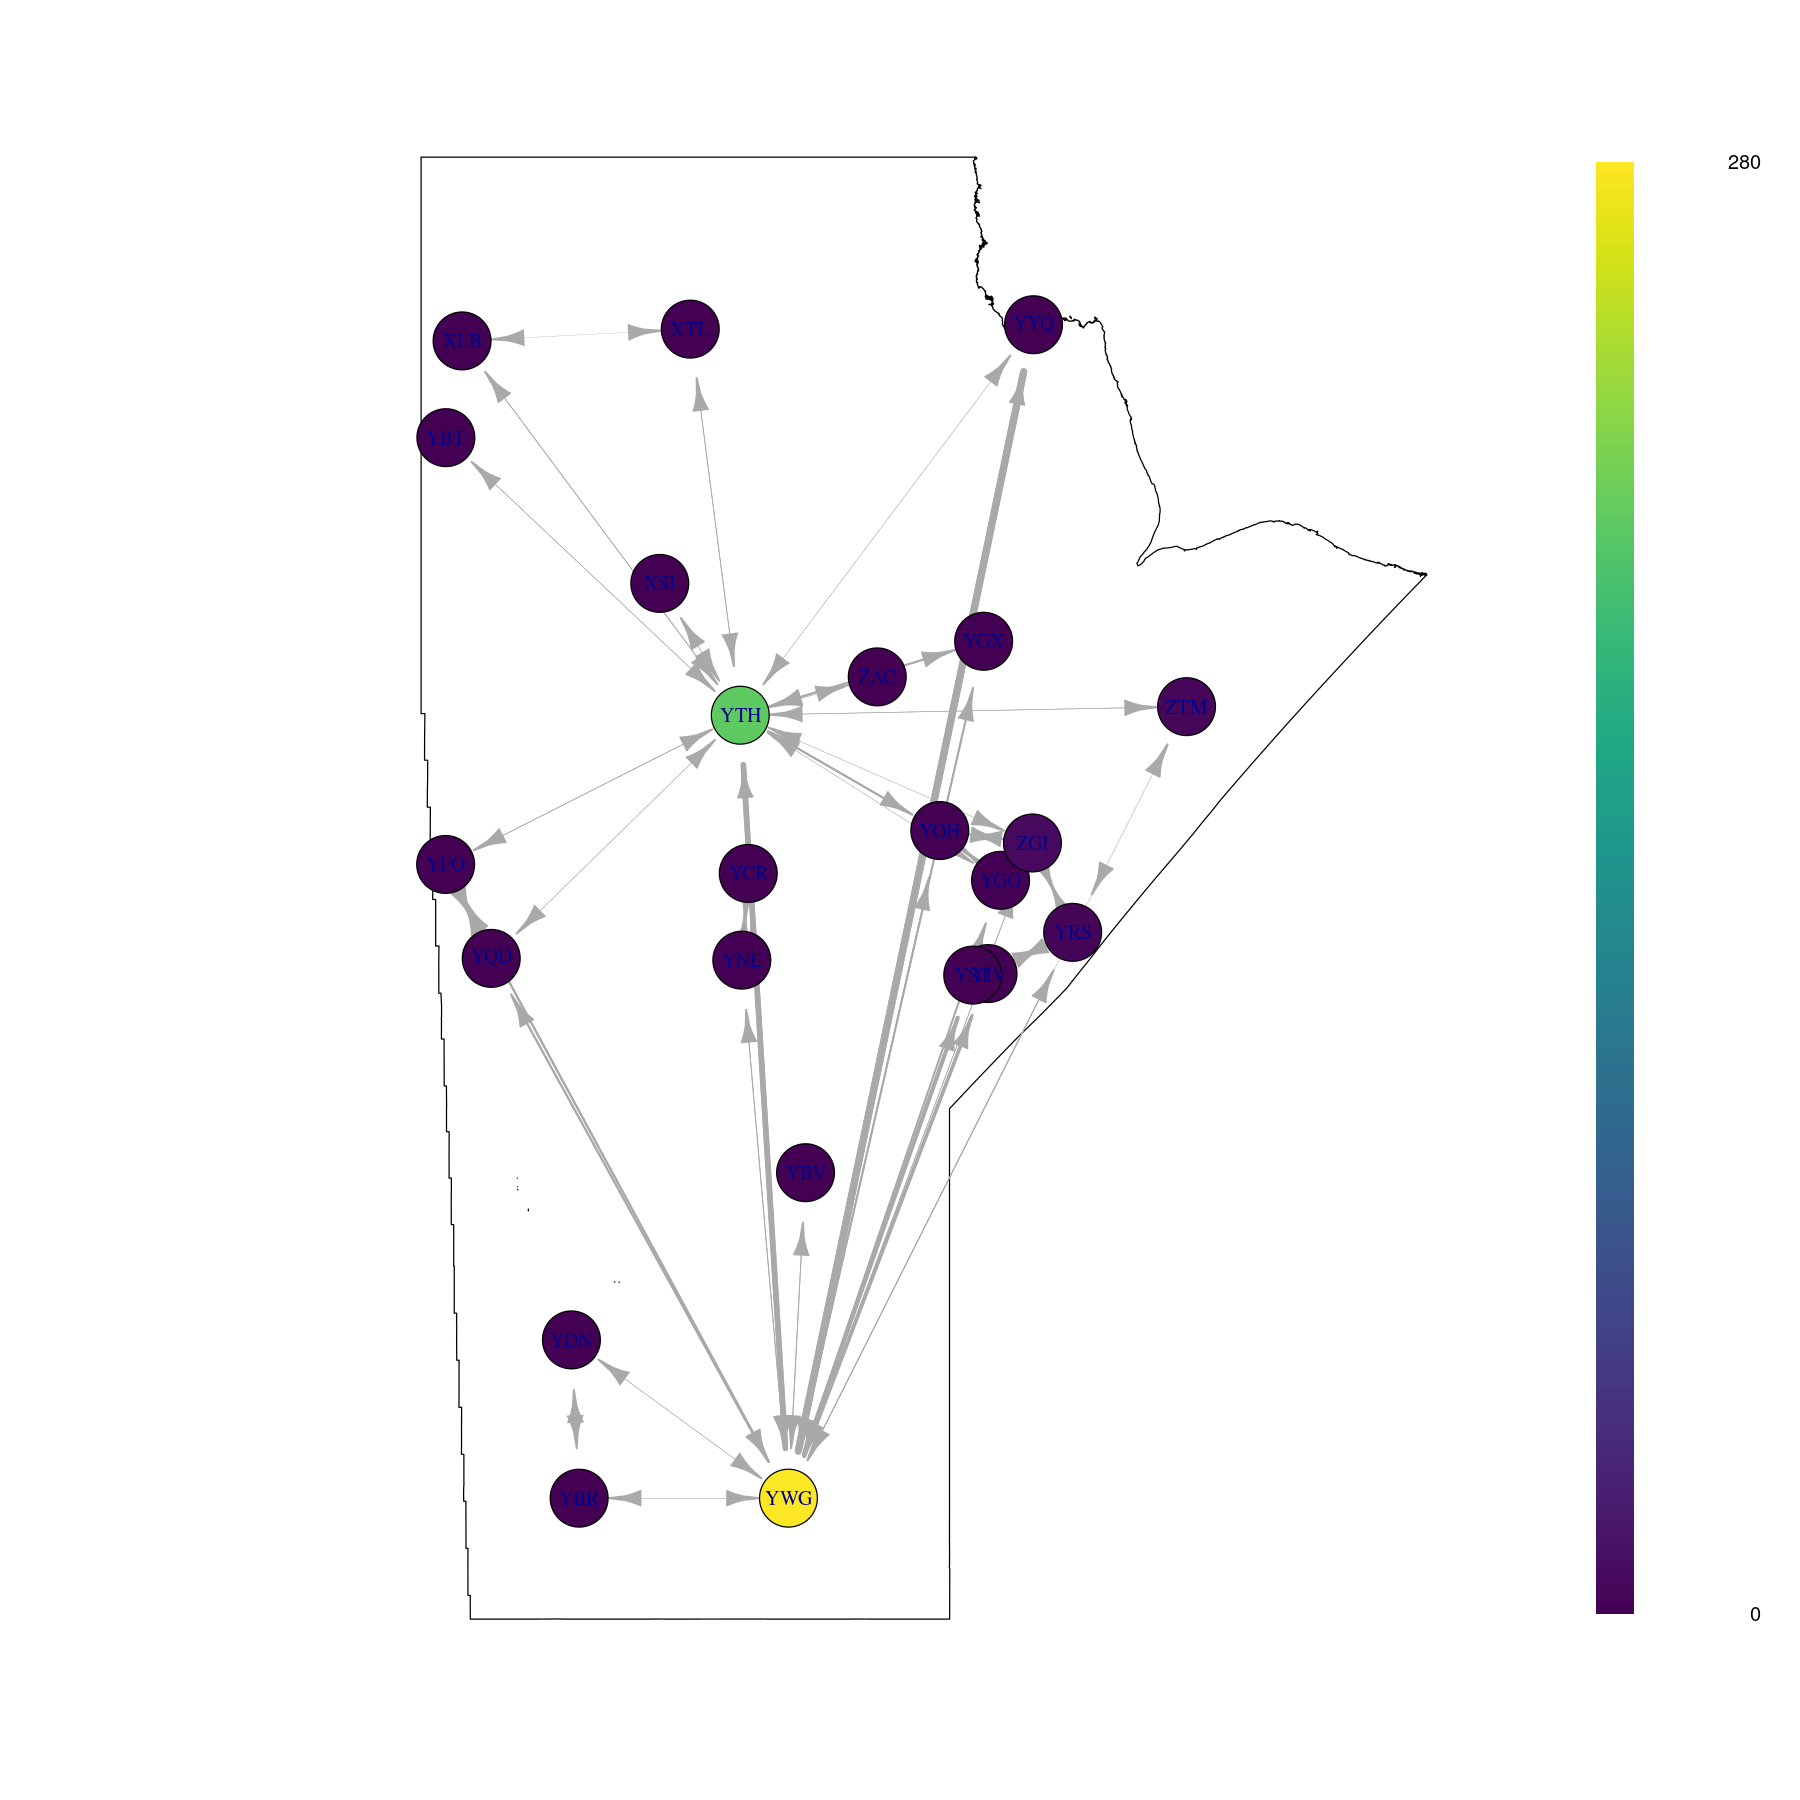

In [40]:
betweenness_MB = betweenness(G_MB)
# shift numbers by 1 because the second command fails when there are zeros..
colbar <- viridis::viridis(max(ceiling(betweenness_MB))+1)
V(G_MB)$color <- colbar[round(betweenness_MB)+1]
# For the label of the colour bar
colbar_str = sprintf("%d", range(unique(round(betweenness_MB))))

plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)
DescTools::ColorLegend(x = "right", col = colbar, 
                       width = 0.5, inset = 0.1,
                       labels = colbar_str)

# Closeness
First, the unweighted case, i.e., using the geodesic distance.

In [51]:
round(closeness(G_MB, mode = "all"),5)
round(closeness(G_MB, mode = "in"),5)
round(closeness(G_MB, mode = "out"),5)

XLB     XSI     XTL     YBR     YBT     YBV     YCR     YDN     YFO     YGO 
0.02000 0.01961 0.02000 0.02128 0.01961 0.02083 0.02128 0.02128 0.02439 0.02500 
    YGX     YIV     YNE     YOH     YQD     YRS     YST     YTH     YWG     YYQ 
0.02381 0.02174 0.02128 0.02500 0.02439 0.02222 0.02128 0.03333 0.03704 0.02381 
    ZAC     ZGI     ZTM 
0.01961 0.02564 0.02439

XLB     XSI     XTL     YBR     YBT     YBV     YCR     YDN     YFO     YGO 
0.02000 0.01961 0.02000 0.02128 0.01961 0.02083 0.02128 0.02128 0.02439 0.02500 
    YGX     YIV     YNE     YOH     YQD     YRS     YST     YTH     YWG     YYQ 
0.02381 0.02174 0.02128 0.02500 0.02439 0.02222 0.02083 0.03333 0.03704 0.02381 
    ZAC     ZGI     ZTM 
0.01961 0.02564 0.02439

XLB     XSI     XTL     YBR     YBT     YBV     YCR     YDN     YFO     YGO 
0.02000 0.01961 0.02000 0.02128 0.01961 0.02083 0.02128 0.02128 0.02439 0.02500 
    YGX     YIV     YNE     YOH     YQD     YRS     YST     YTH     YWG     YYQ 
0.02381 0.02128 0.02128 0.02500 0.02439 0.02222 0.02128 0.03333 0.03704 0.02381 
    ZAC     ZGI     ZTM 
0.01961 0.02564 0.02439

We can also compute closeness using weighted arcs, i.e., using the travel volumes. Geodesic distance shown for comparison. We save the results for future manipulation.

In [42]:
# Unweighted case
cl_MB_U = closeness(G_MB, mode = "out")
cl_MB_U
# Weighted case
cl_MB_W = closeness(G_MB, mode = "out", weights = E(G_MB)$vol)
cl_MB_W

XLB        XSI        XTL        YBR        YBT        YBV        YCR 
0.02000000 0.01960784 0.02000000 0.02127660 0.01960784 0.02083333 0.02127660 
       YDN        YFO        YGO        YGX        YIV        YNE        YOH 
0.02127660 0.02439024 0.02500000 0.02380952 0.02127660 0.02127660 0.02500000 
       YQD        YRS        YST        YTH        YWG        YYQ        ZAC 
0.02439024 0.02222222 0.02127660 0.03333333 0.03703704 0.02380952 0.01960784 
       ZGI        ZTM 
0.02564103 0.02439024

XLB          XSI          XTL          YBR          YBT          YBV 
3.556061e-05 4.171882e-05 3.788453e-05 4.025603e-05 3.989150e-05 2.928172e-05 
         YCR          YDN          YFO          YGO          YGX          YIV 
3.762935e-05 3.726893e-05 3.605163e-05 5.860634e-05 2.420721e-05 3.335557e-05 
         YNE          YOH          YQD          YRS          YST          YTH 
2.986323e-05 6.466632e-05 4.283206e-05 5.351887e-05 2.247494e-05 6.413134e-05 
         YWG          YYQ          ZAC          ZGI          ZTM 
5.218934e-05 4.675738e-05 4.381353e-05 6.568576e-05 5.549390e-05

To prepare for plots, let us look at the ranges of values.

[1] 0.01960784 0.03703704

[1] 2.247494e-05 6.568576e-05

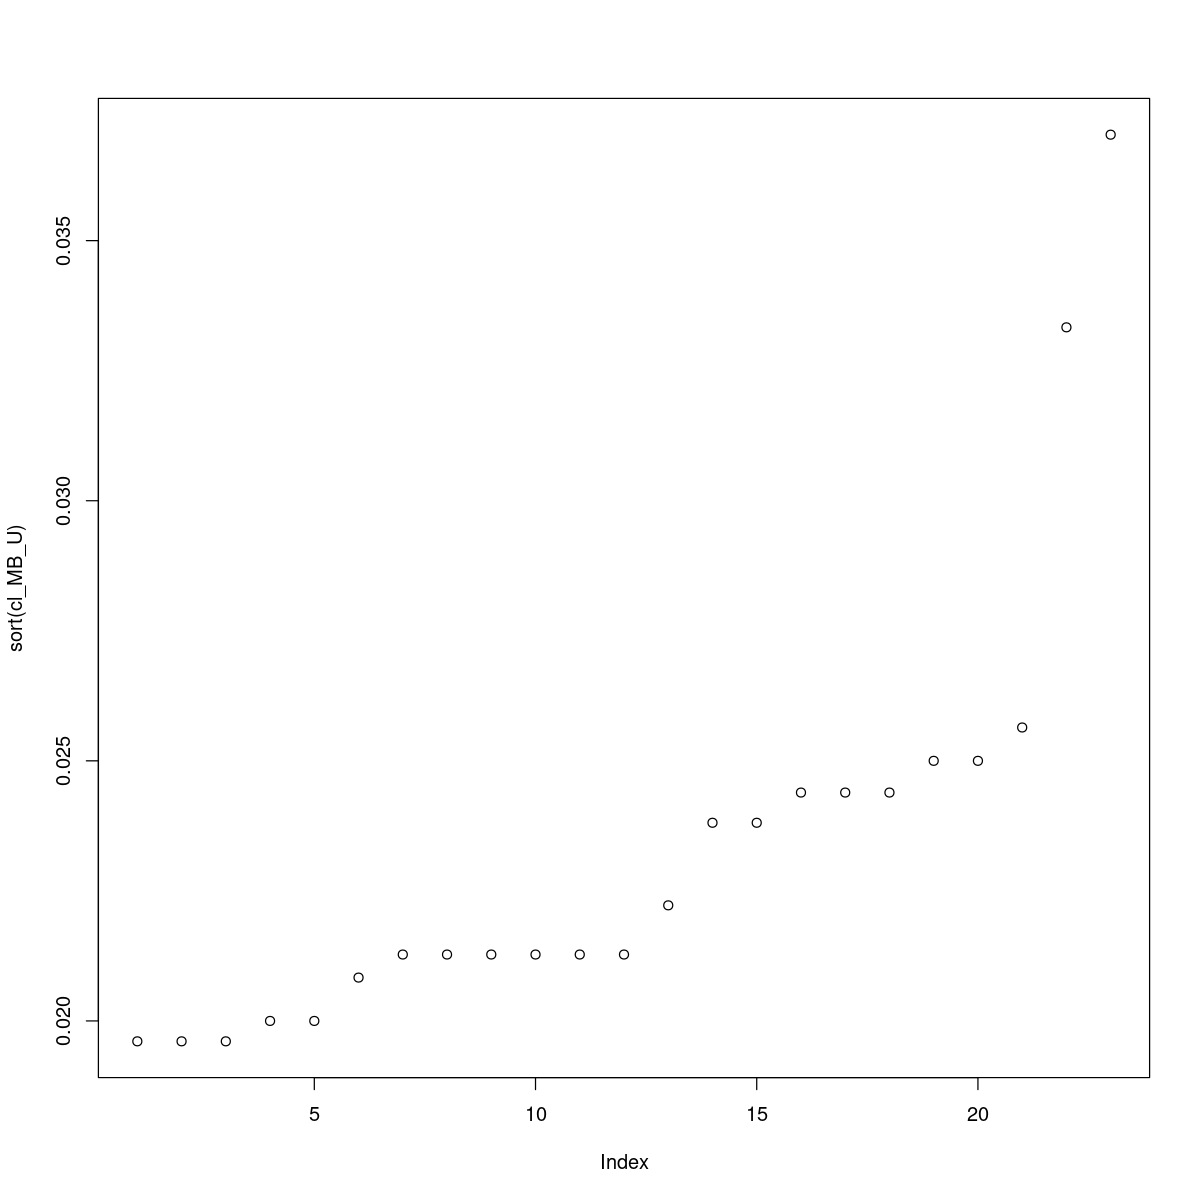

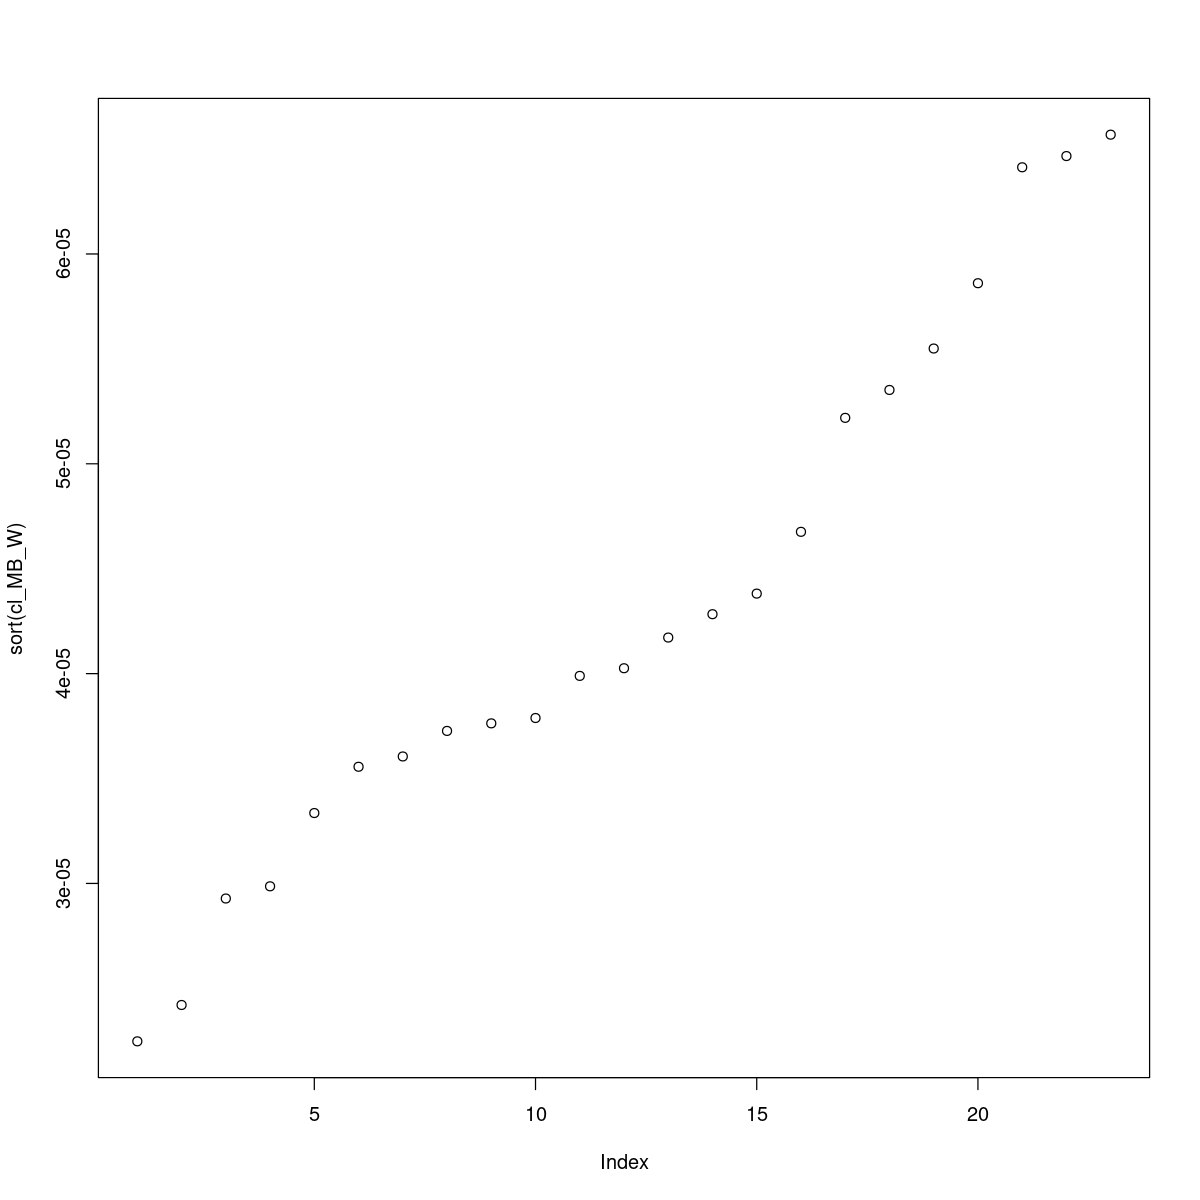

In [43]:
options(repr.plot.width=10, repr.plot.height=10)

range(cl_MB_U)
plot(sort(cl_MB_U))
range(cl_MB_W)
plot(sort(cl_MB_W))

So if we multiply the first values by 10,000 and the second ones by 1e7, we should get good ranges of variation.

In [44]:
range(cl_MB_U * 1e4)
range(cl_MB_W * 1e7)

[1] 196.0784 370.3704

[1] 224.7494 656.8576

Indeed, so that's what we do.

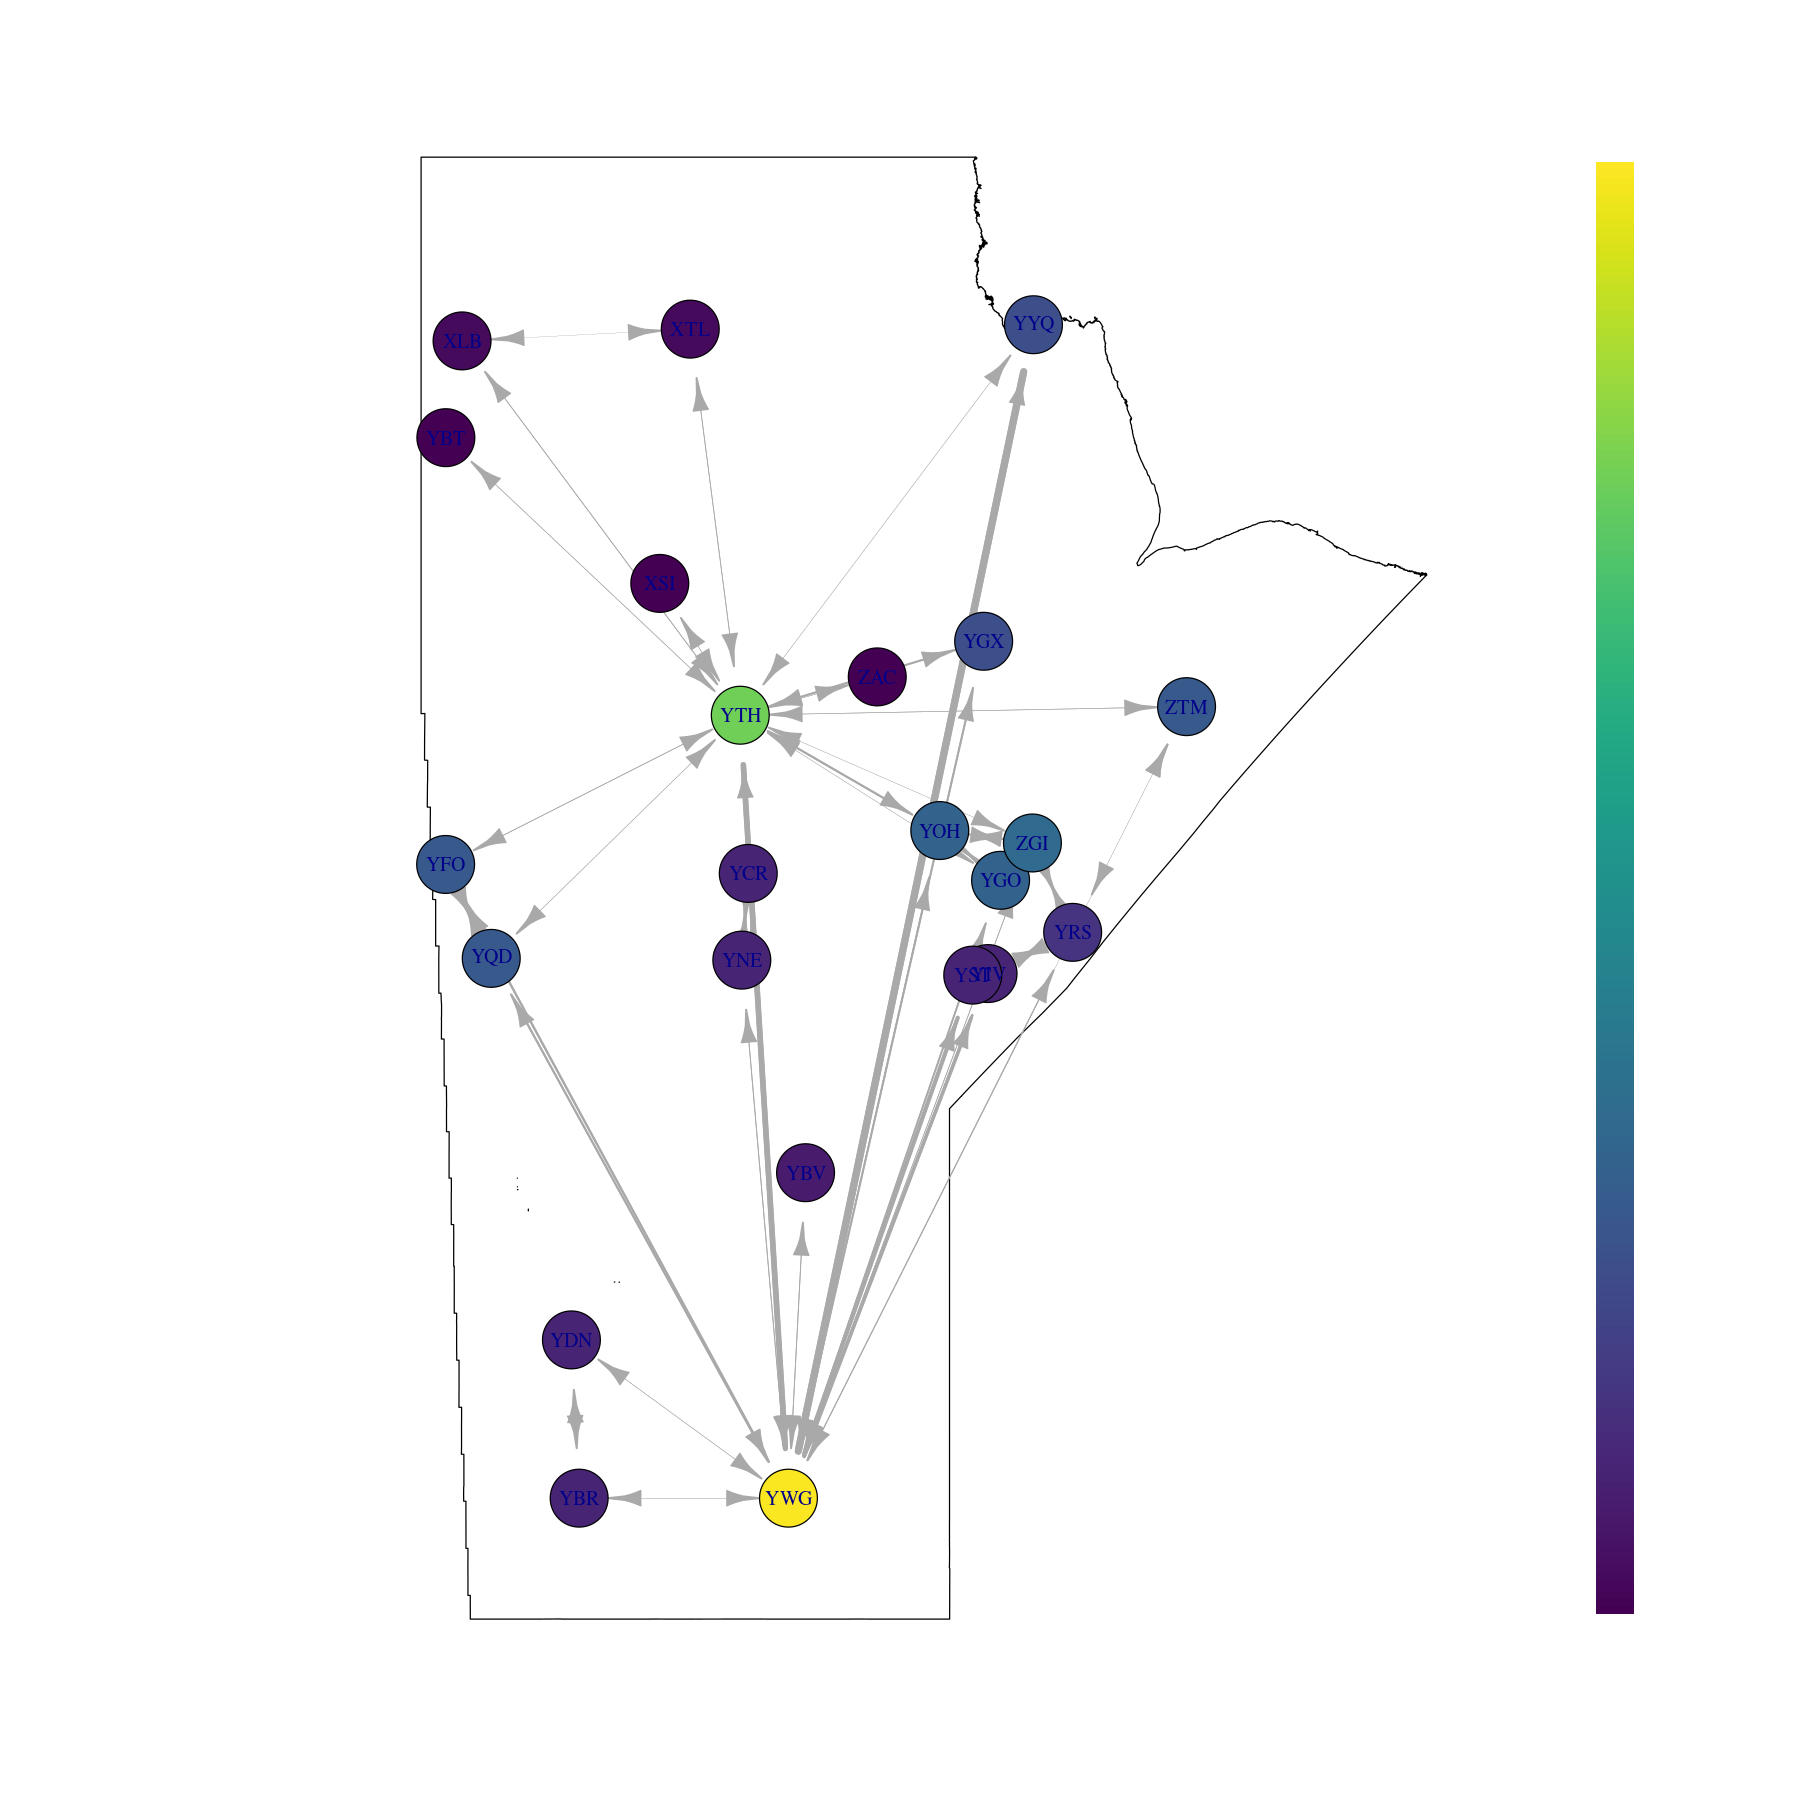

In [45]:
options(repr.plot.width=15, repr.plot.height=15)

cl_MB_U_tmp = cl_MB_U * 1e4
Delta_cl = ceiling(max(cl_MB_U_tmp)-min(cl_MB_U_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_U_tmp-min(cl_MB_U_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_U_tmp))

plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)
DescTools::ColorLegend(x = "right", col = colbar, 
                       width = 0.5, inset = 0.1,
                       labels = colbar_str)

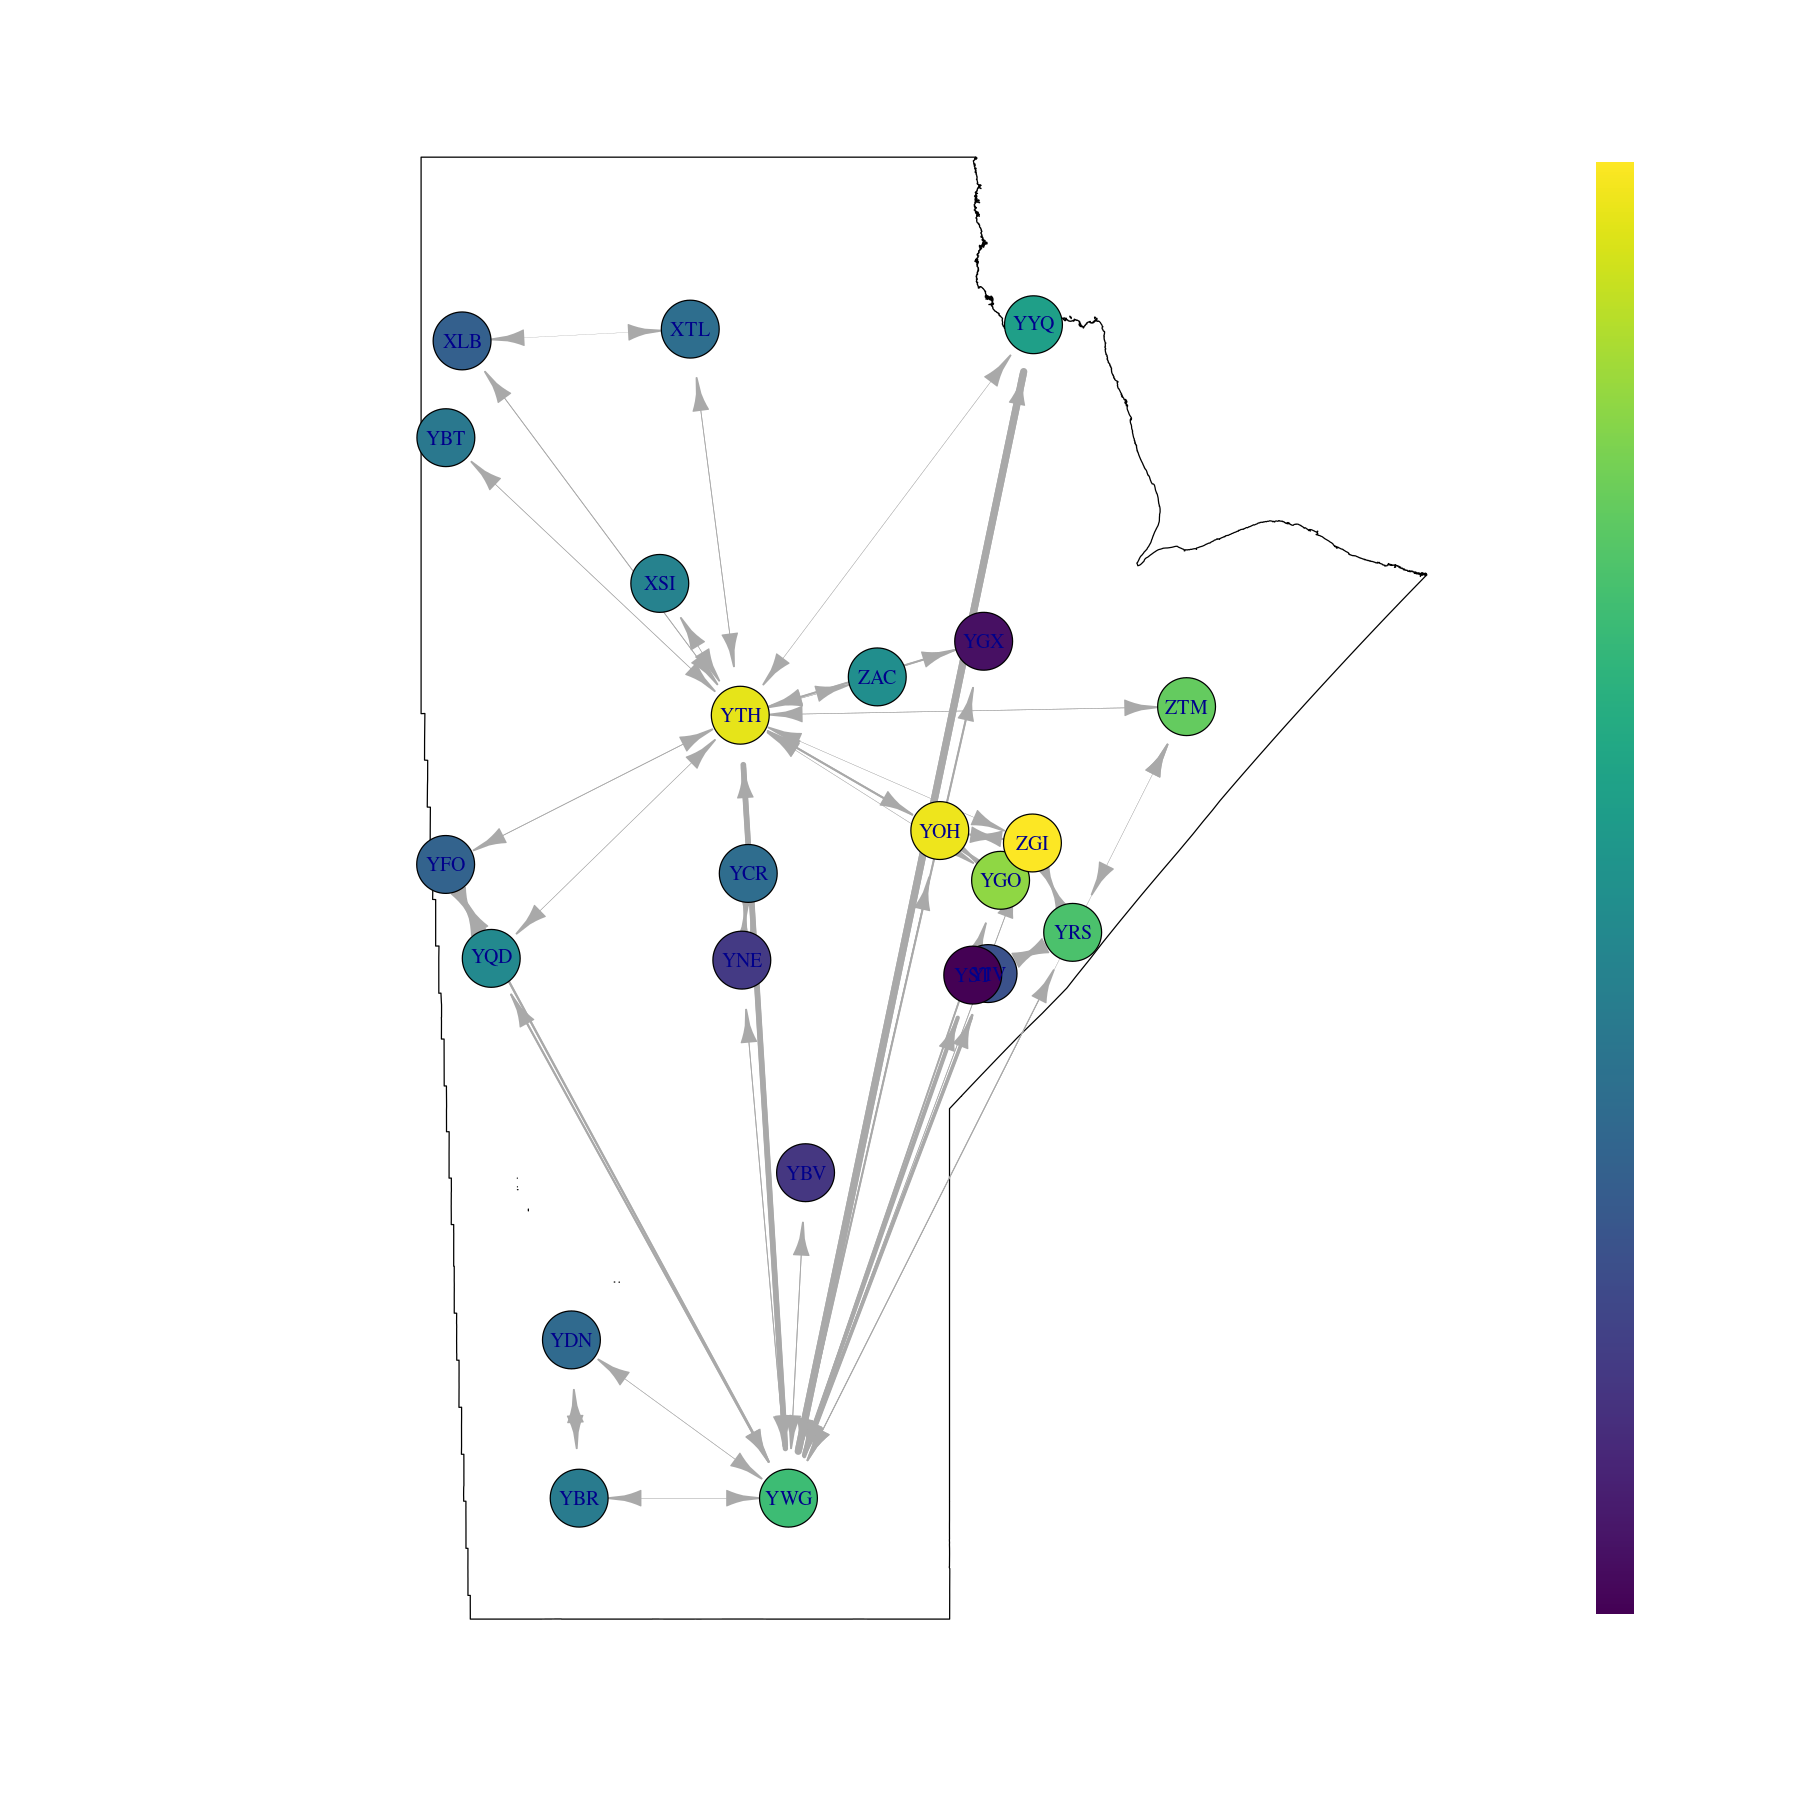

In [46]:
cl_MB_W_tmp = cl_MB_W * 1e7
Delta_cl = ceiling(max(cl_MB_W_tmp)-min(cl_MB_W_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_W_tmp-min(cl_MB_W_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_W_tmp))

plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)
DescTools::ColorLegend(x = "right", col = colbar, 
                       width = 0.5, inset = 0.1,
                       labels = colbar_str)

One interesting remark here: closeness radically changes when considering the unweighted and weighted version. Just to confirm this, let us plot the two graphs side by side.

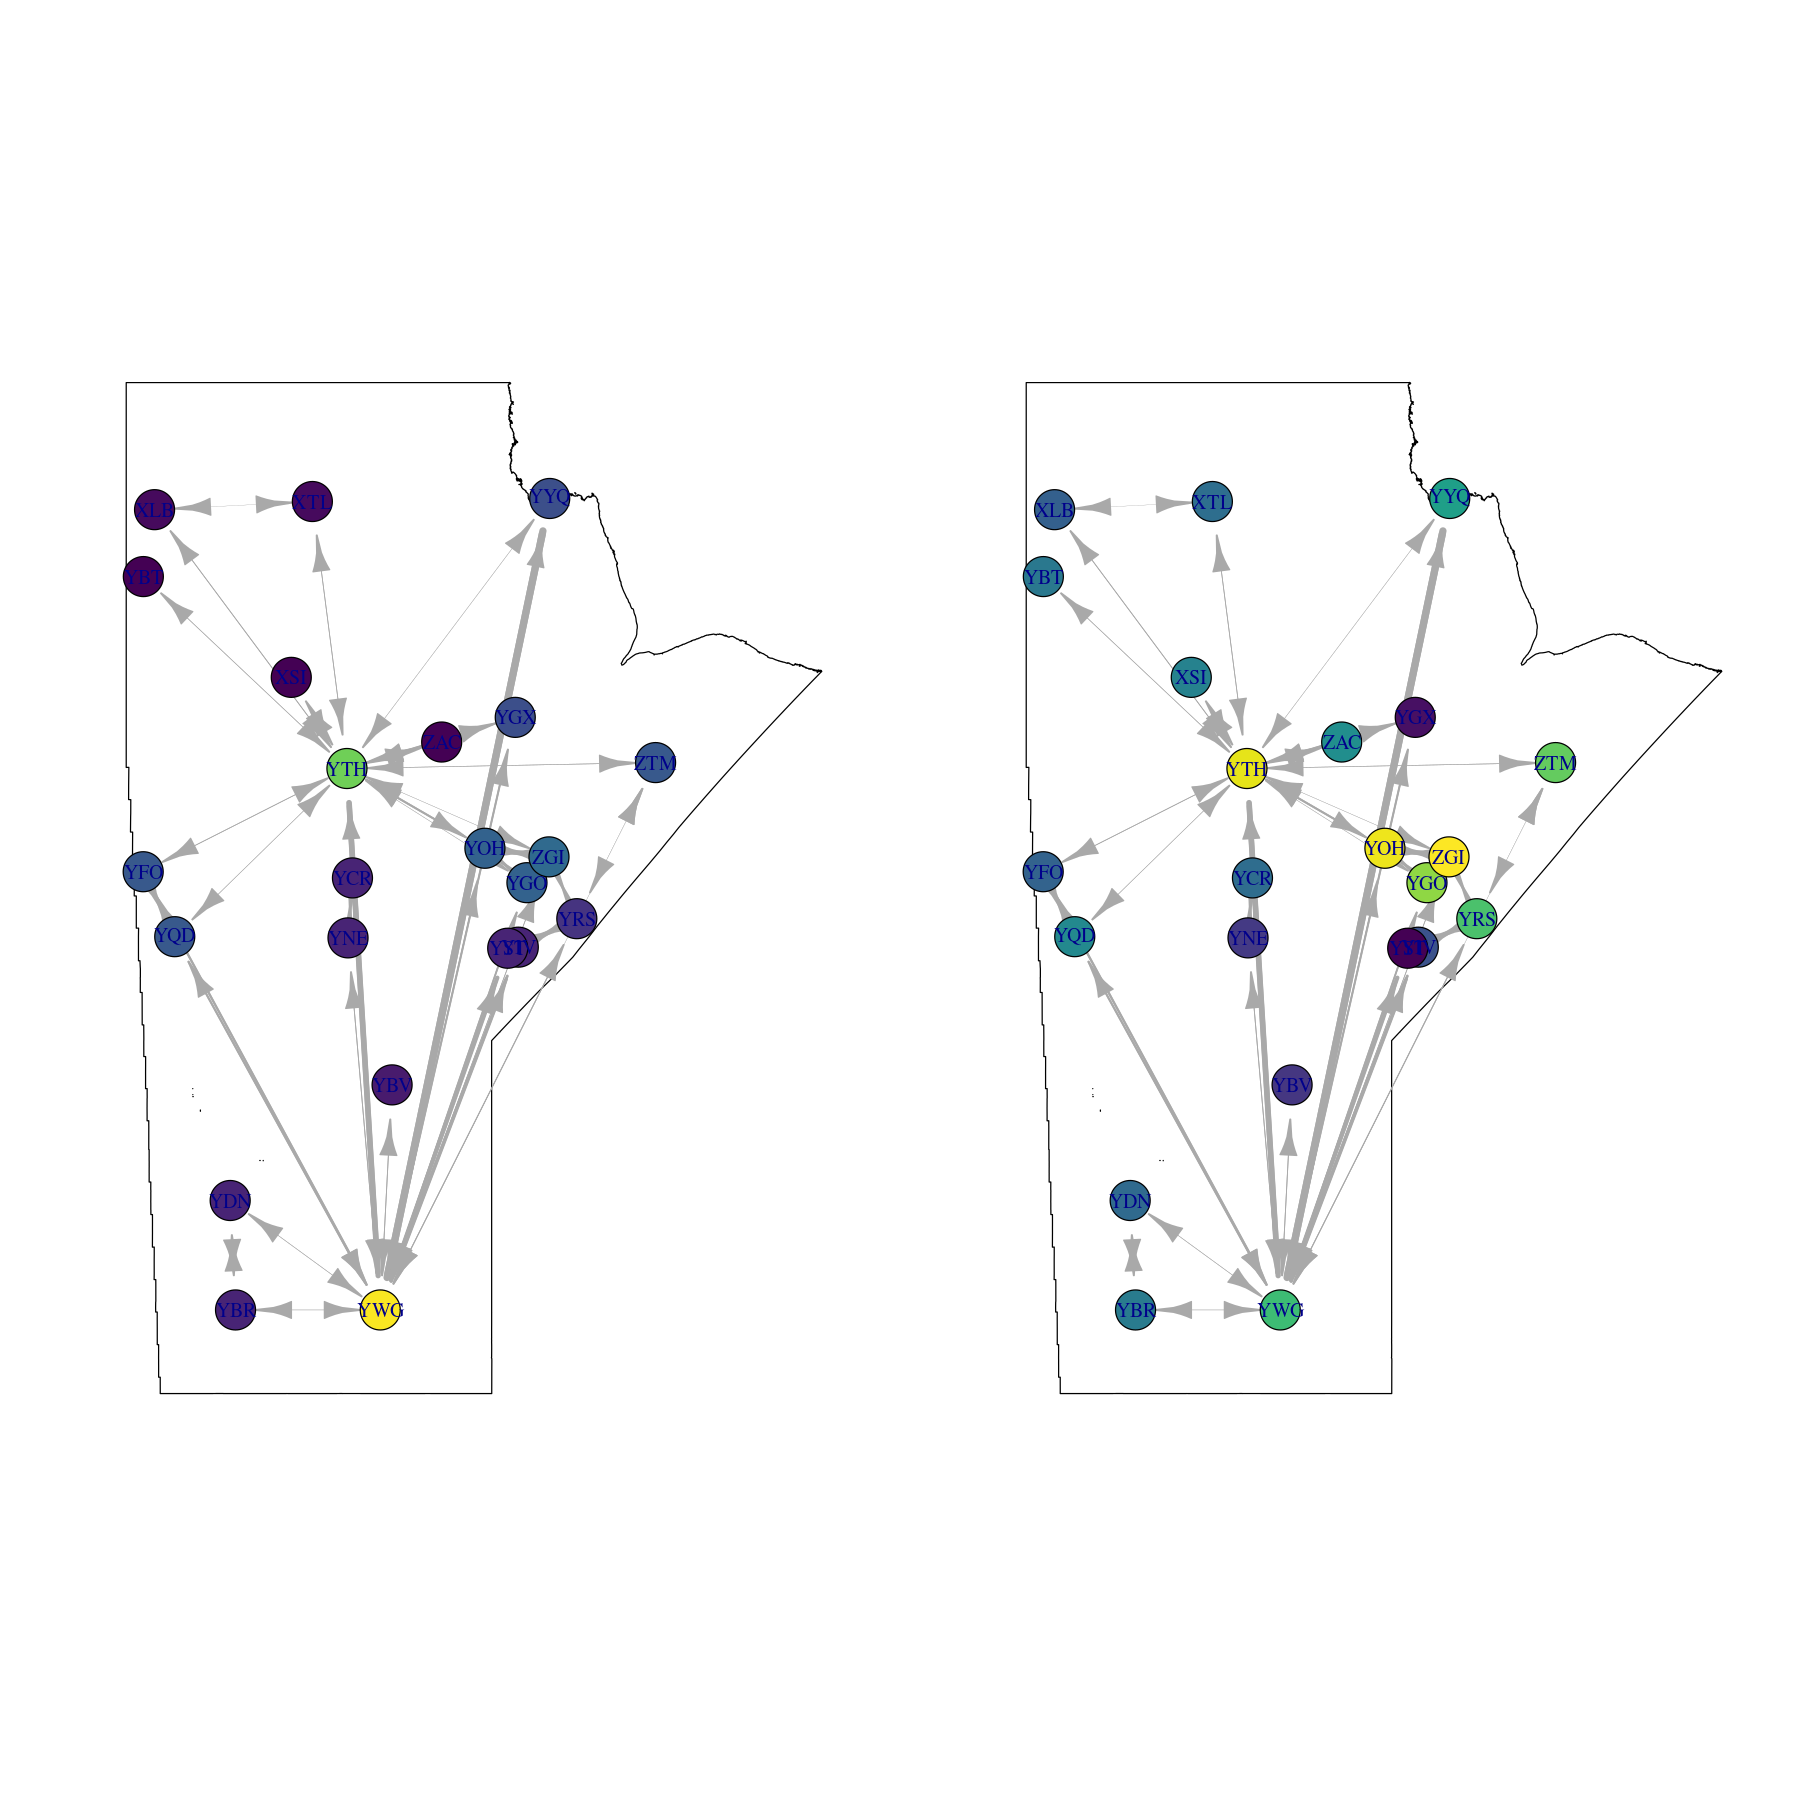

In [47]:
par(mfrow=c(1,2))

# Unweighted MB only
Delta_cl = ceiling(max(cl_MB_U_tmp)-min(cl_MB_U_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_U_tmp-min(cl_MB_U_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_U_tmp))
plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

# Weighted MB only
Delta_cl = ceiling(max(cl_MB_W_tmp)-min(cl_MB_W_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_W_tmp-min(cl_MB_W_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_W_tmp))
plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

So Thompson (YTH) is has higher closeness centrality than Winnipeg (YWG) when passenger volumes are considered. Does the situation change if we recall that Winnipeg is quite connected to the rest of the world? We prepare the computations and the plots as we had done earlier.

In [48]:
# Unweighted case
cl_MB_RoW_U = closeness(G, mode = "out")
range(cl_MB_RoW_U)
# Weighted case
cl_MB_RoW_W = closeness(G, mode = "out", weights = E(G)$vol)
range(cl_MB_RoW_W)

[1] 0.01960784 0.03571429

[1] 2.144864e-05 6.247267e-05

Ranges are quite similar to those earlier, so we can probably just do the same as before. We will plot the 4 figures this time. First row is as before, second row is with rest of the world information thrown in.

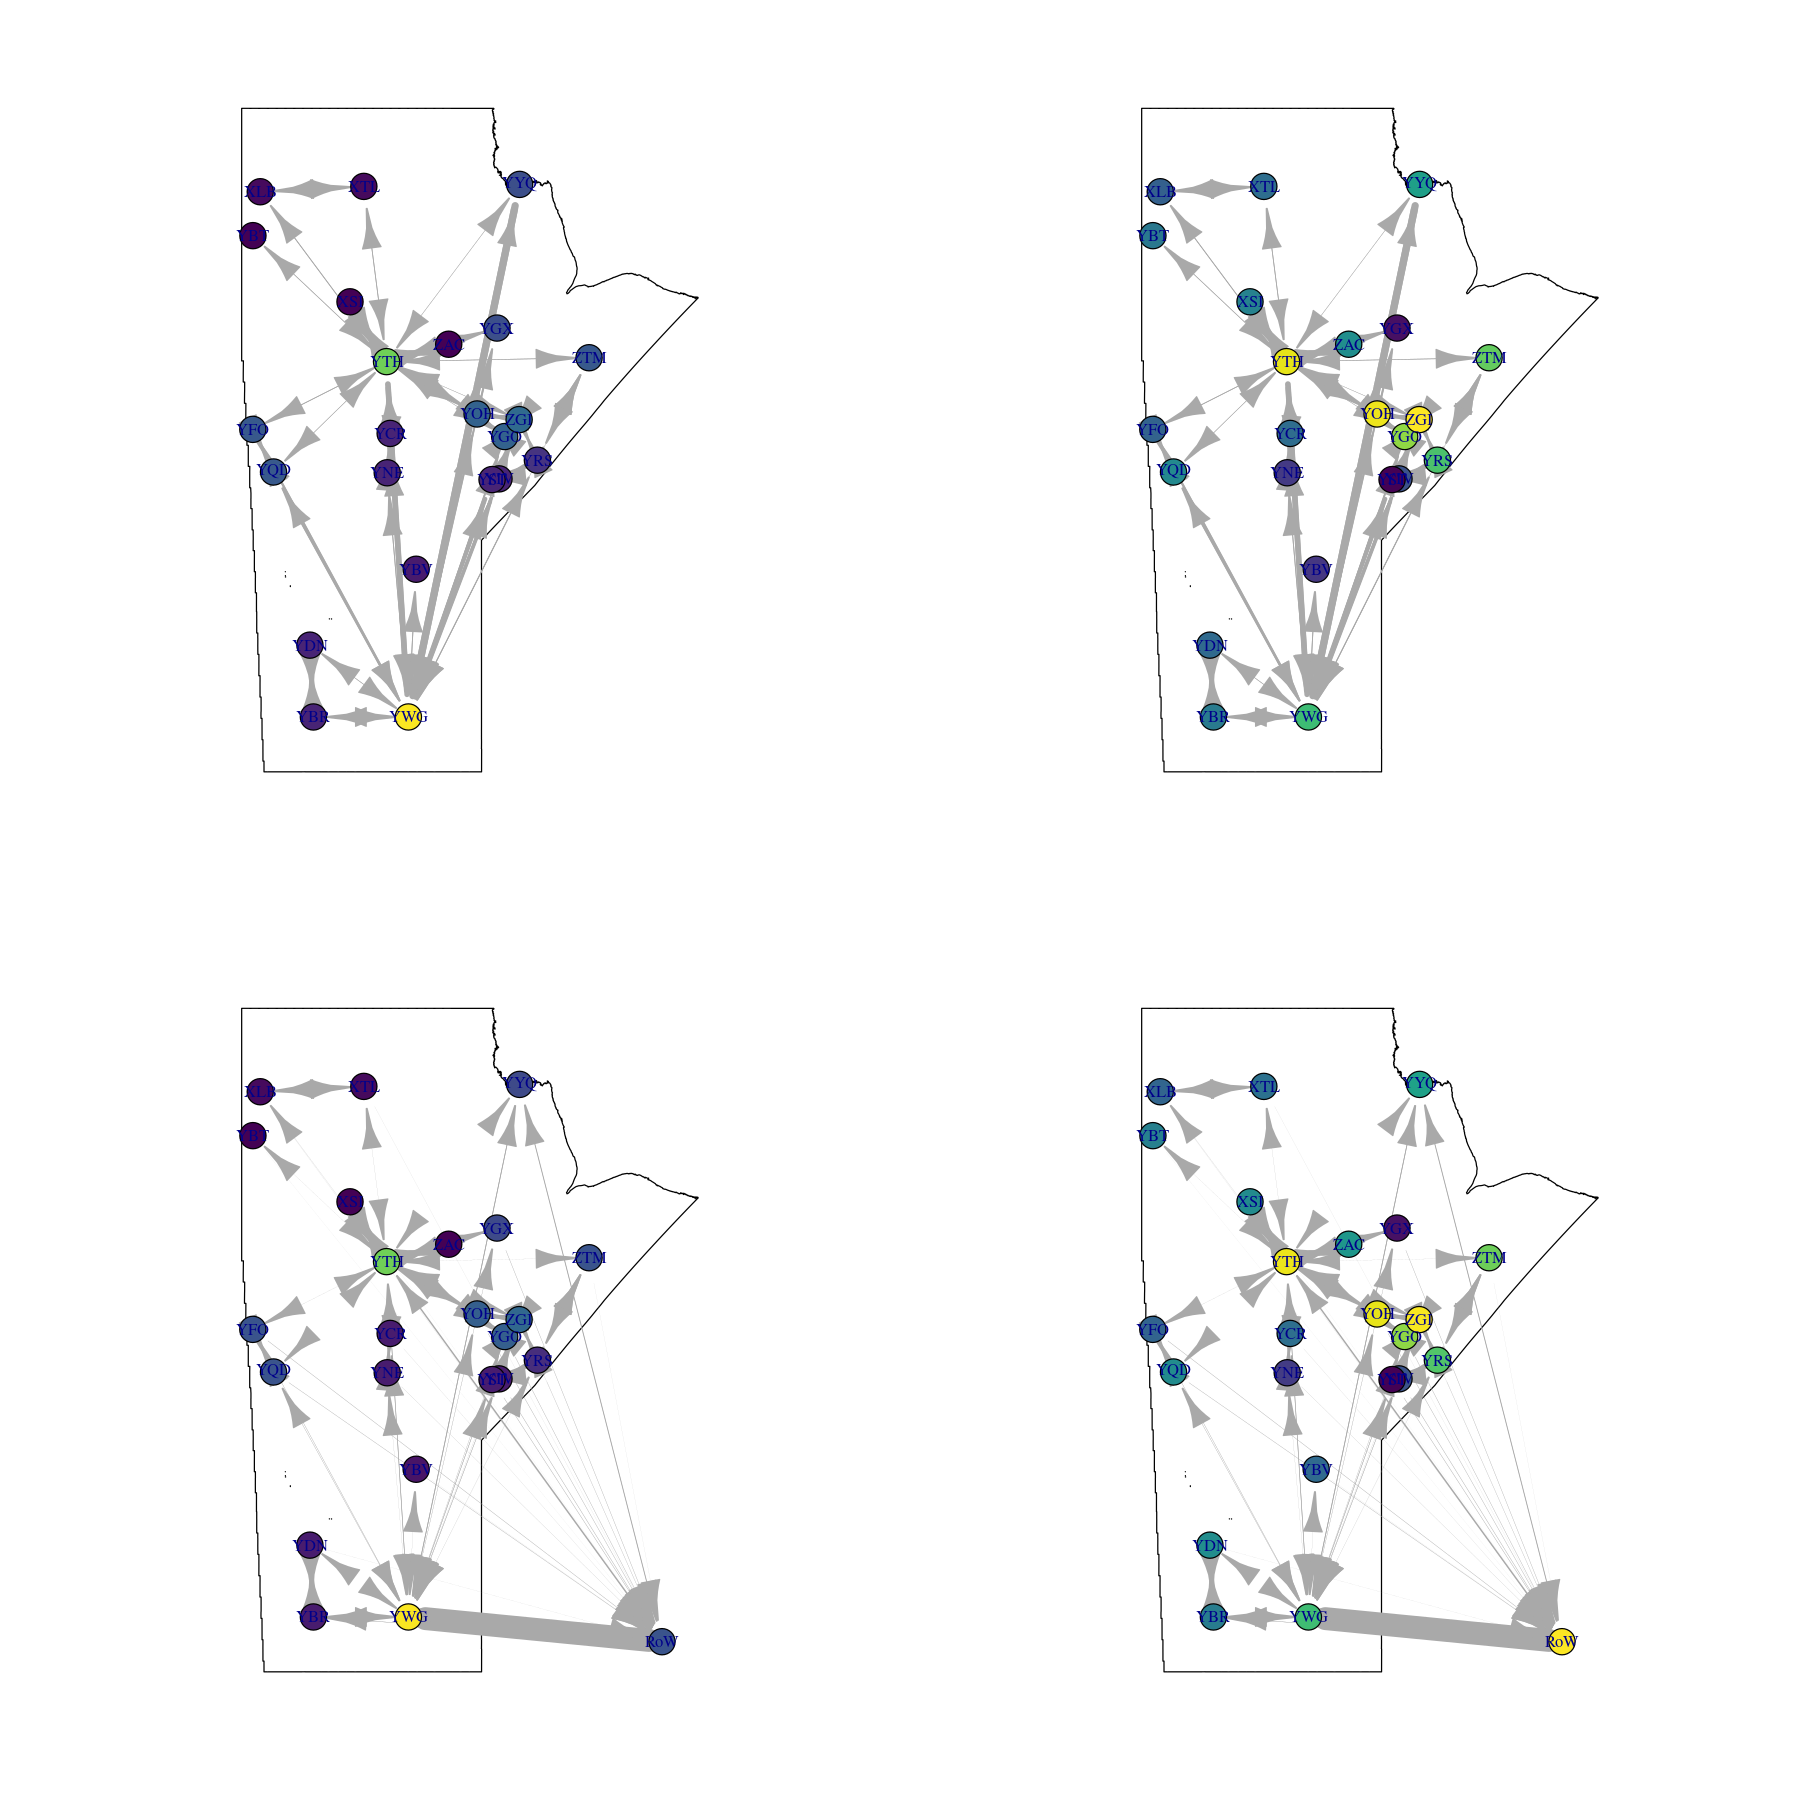

In [49]:
par(mfrow=c(2,2))

cl_MB_RoW_U_tmp = cl_MB_RoW_U * 1e4
cl_MB_RoW_W_tmp = cl_MB_RoW_W * 1e7

# Unweighted MB only
Delta_cl = ceiling(max(cl_MB_U_tmp)-min(cl_MB_U_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_U_tmp-min(cl_MB_U_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_U_tmp))
plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

# Weighted MB only
Delta_cl = ceiling(max(cl_MB_W_tmp)-min(cl_MB_W_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G_MB)$color <- colbar[round(cl_MB_W_tmp-min(cl_MB_W_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_W_tmp))
plot(MB)
V(G_MB)$size = rep(75,length(V(G_MB)))
plot(G_MB, add = TRUE, rescale = FALSE, 
     edge.width = E(G_MB)$vol*0.001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

# Unweighted MB with RoW
Delta_cl = ceiling(max(cl_MB_RoW_U_tmp)-min(cl_MB_RoW_U_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G)$color <- colbar[round(cl_MB_RoW_U_tmp-min(cl_MB_RoW_U_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_RoW_U_tmp))
plot(MB)
V(G)$size = rep(75,length(V(G)))
plot(G, add = TRUE, rescale = FALSE, 
     edge.width = E(G)$vol*0.0001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

# Weighted MB with RoW
Delta_cl = ceiling(max(cl_MB_RoW_W_tmp)-min(cl_MB_RoW_W_tmp))
colbar <- viridis::viridis(Delta_cl+1)
V(G)$color <- colbar[round(cl_MB_RoW_W_tmp-min(cl_MB_RoW_W_tmp))+1]
# For the label of the colour bar
colbar_str = sprintf("%f", range(cl_MB_RoW_W_tmp))
plot(MB)
V(G)$size = rep(75,length(V(G)))
plot(G, add = TRUE, rescale = FALSE, 
     edge.width = E(G)$vol*0.0001,
     edge.arrow.size = 0.5, 
     edge.arrow.width = 0.75)

Actually, things do not change, except that RoW becomes important as well.